In [107]:
import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import numpy as np
import pandas as pd
import wrf
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import xarray as xr
import datetime
from scipy import stats
import itertools
import pickle

# c1 site location
site_latitude  = 36.6050
site_longitude = -97.485

# interpolate wrf variables to this height
# also a specified height in lasso data
target_height_agl = 80

# omit number of cells on edges
cut_cells = 10

obs_dir = '/projects/mmc/jlee/sgp/sgp_obs/'
# wrf_runs_dir = '/projects/mmc/jlee/sgp/wrf-mmc/wrf-runs/'
wrf_runs_dir = '/scratch/jlee/mmc/'
nb_dir = !pwd

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

## load data

In [108]:
# when pkl file is produced

with open(nb_dir[0]+'/pkl/'+'c1_neighbor_1min_ws_w_0805.pkl', 'rb') as handle:
    ds_0805 = pickle.load(handle)
with open(nb_dir[0]+'/pkl/'+'c1_neighbor_mean_hgt_0805.pkl', 'rb') as handle:
    ds_0805_hgt = pickle.load(handle)
    
with open(nb_dir[0]+'/pkl/'+'c1_neighbor_1min_ws_w_0901.pkl', 'rb') as handle:
    ds_0901 = pickle.load(handle)
with open(nb_dir[0]+'/pkl/'+'c1_neighbor_mean_hgt_0901.pkl', 'rb') as handle:
    ds_0091_hgt = pickle.load(handle)

In [6]:
def get_neighbor_ws_w_da(eval_date, run, neighbor):
    
    date_col = data_dir_df[eval_date]
    loop = 0
    
    try:
        del(ws_da, w_da)
    except:
        pass

    for ind, hr in enumerate(np.arange(14, 23, 1)): 

        for minute in np.arange(0, 60, 10):

            if minute == 0:
                minute = '00'
            else:
                minute = str(minute)

            file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d04_'+eval_date+'_'+str(hr)+':'+minute+':00'
            print(file)

            wrf_single = Dataset(file, 'r')
            
            if loop == 0:
                site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)
                sn_ind, we_ind = site_loc_ij.values[1], site_loc_ij.values[0]
                height = wrf.getvar(wrf_single, 'height_agl').mean(dim=['south_north', 'west_east'])
                loop = 1

            var = wrf.getvar(wrf_single, 'wspd_wdir', timeidx=wrf.ALL_TIMES)
            wspd = var['wspd_wdir' == 'wspd']
    
            var = wrf.getvar(wrf_single, 'W', timeidx=wrf.ALL_TIMES)
            w = wrf.destagger(var, 1, meta=True)
            w = w.assign_coords(var.coords)
            
            wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)

            if wrf_time.shape[0] > 1:
                wspd_sel = wspd[:, :50, sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1]
                w_sel = w[:, :50, sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1]
            else: 
                wspd_sel = wspd[:50, sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1].values
                w_sel = w[:50, sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1].values

            try:
                ws_da = xr.concat([ws_da, wspd_sel], dim='Time')
                w_da = xr.concat([w_da, w_sel], dim='Time')
            except NameError:
                ws_da = wspd_sel
                w_da = w_sel

    return ws_da, w_da, height

In [ ]:
eval_date = '2018-08-05'
neighbor = 6
    
ws_da_mynn_0805, w_da_mynn_0805, hgt_mynn_0805 = get_neighbor_ws_w_da(eval_date, 'mynn', neighbor)
ws_da_mynn91_0805, w_da_mynn91_0805, hgt_mynn91_0805 = get_neighbor_ws_w_da(eval_date, 'mynn_d12-9s_d34-1s', 
                                                                       neighbor)
ws_da_edmf_0805, w_da_edmf_0805, hgt_edmf_0805 = get_neighbor_ws_w_da(eval_date, 'edmf', neighbor)
ws_da_edmf91_0805, w_da_edmf91_0805, hgt_edmf91_0805 = get_neighbor_ws_w_da(eval_date, 'edmf_d12-9s_d34-1s', 
                                                                            neighbor)

/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_14:00:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_14:10:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_14:20:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_14:30:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_14:40:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_14:50:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:00:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:10:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:20:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:30:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:40:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_15:50:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_16:00:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_16:10:00
/scratch/jlee/mmc/a1_0805m_30s/auxout/mmc_d04_2018-08-05_16:20:00
/scratch/j

/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_16:40:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_16:50:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_17:00:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_17:10:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_17:20:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_17:30:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_17:40:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_17:50:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_18:00:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_18:10:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_18:20:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_18:30:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_18:40:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_18:50:00
/scratch/jlee/mmc/a2_0805e_30s/auxout/mmc_d04_2018-08-05_19:00:00
/scratch/j

In [104]:
ds_0805 = xr.Dataset()

ds_0805['ws_mynn'] = ws_da_mynn_0805
ds_0805['w_mynn'] = w_da_mynn_0805
ds_0805['ws_mynn91'] = ws_da_mynn91_0805
ds_0805['w_mynn91'] = w_da_mynn91_0805

ds_0805['ws_edmf'] = ws_da_edmf_0805
ds_0805['w_edmf'] = w_da_edmf_0805
ds_0805['ws_edmf91'] = ws_da_edmf91_0805
ds_0805['w_edmf91'] = w_da_edmf91_0805

file_name = 'c1_neighbor_1min_ws_w_0805.pkl'
f = open(nb_dir[0]+'/pkl/'+file_name, 'wb')
pickle.dump(ds_0805, f)
f.close()

ds_0805_hgt = xr.Dataset()

ds_0805_hgt['hgt_mynn'] = hgt_mynn_0805
# ds_0805_hgt['hgt_mynn91'] = hgt_mynn91_0805
# ds_0805_hgt['hgt_edmf'] = hgt_edmf_0805
# ds_0805_hgt['hgt_edmf91'] = hgt_edmf91_0805

file_name = 'c1_neighbor_mean_hgt_0805.pkl'
f = open(nb_dir[0]+'/pkl/'+file_name, 'wb')
pickle.dump(ds_0805_hgt, f)
f.close()

In [103]:
eval_date = '2018-09-01'
neighbor = 6
    
ws_da_mynn_0901, w_da_mynn_0901, hgt_mynn_0901 = get_neighbor_ws_w_da(eval_date, 'mynn', neighbor)
ws_da_mynn91_0901, w_da_mynn91_0901, hgt_mynn91_0901 = get_neighbor_ws_w_da(eval_date, 'mynn_d12-9s_d34-1s', 
                                                                            neighbor)
ws_da_edmf_0901, w_da_edmf_0901, hgt_edmf_0901 = get_neighbor_ws_w_da(eval_date, 'edmf', neighbor)
ws_da_edmf91_0901, w_da_edmf91_0901, hgt_edmf91_0901 = get_neighbor_ws_w_da(eval_date, 'edmf_d12-9s_d34-1s', 
                                                                            neighbor)

/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_14:00:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_14:10:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_14:20:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_14:30:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_14:40:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_14:50:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:00:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:10:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:20:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:30:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:40:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_15:50:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_16:00:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_16:10:00
/scratch/jlee/mmc/o1_0901m_30s/auxout/mmc_d04_2018-09-01_16:20:00
/scratch/j

/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_16:40:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_16:50:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_17:00:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_17:10:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_17:20:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_17:30:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_17:40:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_17:50:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_18:00:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_18:10:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_18:20:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_18:30:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_18:40:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_18:50:00
/scratch/jlee/mmc/o2_0901e_30s/auxout/mmc_d04_2018-09-01_19:00:00
/scratch/j

In [105]:
ds_0901 = xr.Dataset()

ds_0901['ws_mynn'] = ws_da_mynn_0901
ds_0901['w_mynn'] = w_da_mynn_0901
ds_0901['ws_mynn91'] = ws_da_mynn91_0901
ds_0901['w_mynn91'] = w_da_mynn91_0901

ds_0901['ws_edmf'] = ws_da_edmf_0901
ds_0901['w_edmf'] = w_da_edmf_0901
ds_0901['ws_edmf91'] = ws_da_edmf91_0901
ds_0901['w_edmf91'] = w_da_edmf91_0901

file_name = 'c1_neighbor_1min_ws_w_0901.pkl'
f = open(nb_dir[0]+'/pkl/'+file_name, 'wb')
pickle.dump(ds_0901, f)
f.close()

ds_0901_hgt = xr.Dataset()

ds_0901_hgt['hgt_mynn'] = hgt_mynn_0901
# ds_0901_hgt['hgt_mynn91'] = hgt_mynn91_0901
# ds_0901_hgt['hgt_edmf'] = hgt_edmf_0901
# ds_0901_hgt['hgt_edmf91'] = hgt_edmf91_0901

file_name = 'c1_neighbor_mean_hgt_0901.pkl'
f = open(nb_dir[0]+'/pkl/'+file_name, 'wb')
pickle.dump(ds_0901_hgt, f)
f.close()

## std hist

In [435]:
def plot_std_hist(da_list, run_list, hgt_arr, met_var):
    
    al_pha = 0.3

    for hgt_i in [1, 8, 16, 30, 45]:
#     for hgt_i in [1, 8]:
#     for hgt_i in np.arange(10, 20):

        print(np.round(hgt_arr.values[hgt_i], 2), 'm')
    
        time = pd.Timestamp(hgt_arr['Time'].values)
        year = str(time.year)
        month = str(time.month)
        day = str(time.day)
        
        std_dict = {}
        arr_dict = {}
        v_min, v_max = 1e10, 0

        for da, run_name in zip(da_list, run_list):
            
            std = da[:, hgt_i, :, :].std(dim='Time')
            std_samples = np.array(std).flatten()
            
            plt.hist(std_samples.flatten(), label=run_name, alpha=al_pha)
            print(run_name, 'mean:', np.round(std.mean().values, 3), 
                  'std:', np.round(std.std().values, 3))
            
            std_dict[run_name] = std
            arr_dict[run_name] = std_samples
            
            if std.min() < v_min:
                v_min = std.min()
            if std.max() > v_max:
                v_max = std.max()

        plt.title(year+'-'+month+'-'+day+' '
                  +met_var+' temporal std around C1 at '+str(np.round(hgt_arr.values[hgt_i], 2))+' m')
        plt.legend()
        plt.show()
        
        print('statistically INDIFFERENT distributions:')
        
        for pair in itertools.combinations(arr_dict.keys(), 2):

            stat, pval = stats.ttest_ind(arr_dict[pair[0]], arr_dict[pair[1]])
            
            if pval >= 0.05:
                print(pair)
                
        print()    
            
        print('correlated distributions:')
        
        for pair in itertools.combinations(arr_dict.keys(), 2):
                
            corr = np.corrcoef(arr_dict[pair[0]], arr_dict[pair[1]])
            
            if (corr[1, 0] < -0.6) or (corr[1, 0] > 0.6):
                print(pair, corr[1, 0])
        
        fig, ax = plt.subplots(1, 4, figsize=(15, 4))
        ax_i = 0
        
        for run in std_dict.keys():
        
            std_dict[run].plot(ax=ax[ax_i], vmin=v_min, vmax=v_max)
            ax[ax_i].set_title(run+': mean std = '+str(np.round(std_dict[run].mean().values, 3)))
            
            ax_i += 1
            
        plt.suptitle(year+'-'+month+'-'+day+' '
                     +met_var+' temporal std around C1 at '+str(np.round(hgt_arr.values[hgt_i], 2))+' m')
        plt.tight_layout()
        plt.show()
        
        print()

7.34 m
mynn mean: 1.319 std: 0.038
mynn91 mean: 1.3 std: 0.057
edmf mean: 1.24 std: 0.029
edmf91 mean: 1.234 std: 0.05


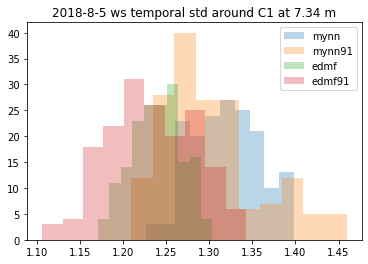

statistically INDIFFERENT distributions:
('edmf', 'edmf91')

correlated distributions:


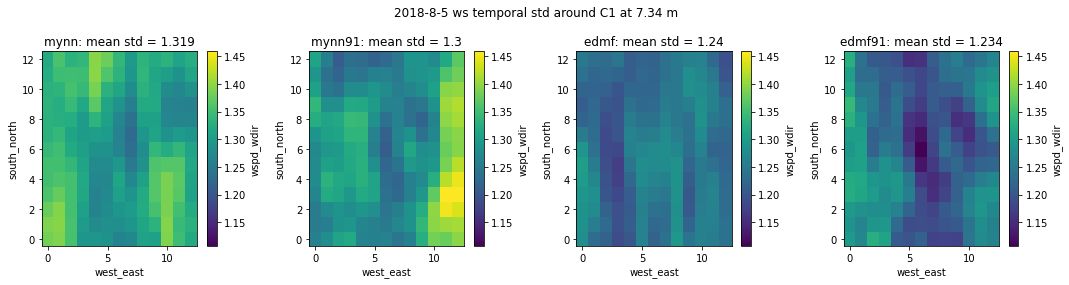


41.39 m
mynn mean: 1.661 std: 0.032
mynn91 mean: 1.423 std: 0.025
edmf mean: 1.536 std: 0.03
edmf91 mean: 1.468 std: 0.026


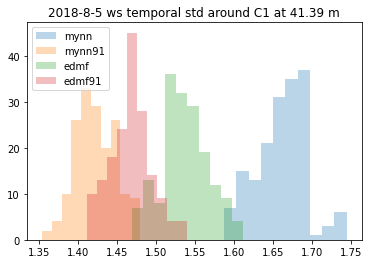

statistically INDIFFERENT distributions:

correlated distributions:


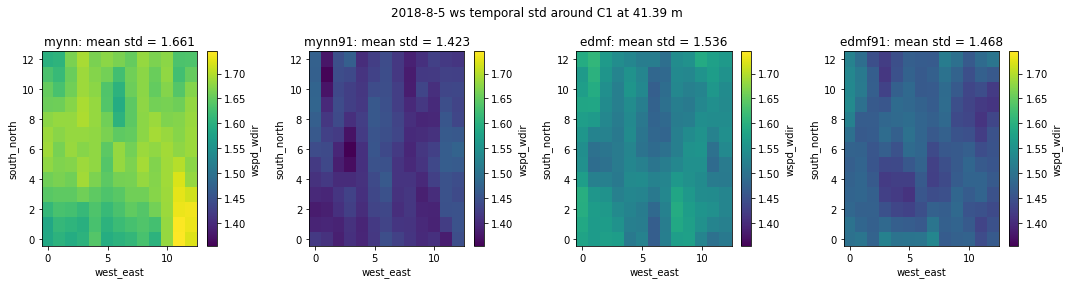


80.16 m
mynn mean: 1.506 std: 0.028
mynn91 mean: 1.286 std: 0.029
edmf mean: 1.386 std: 0.046
edmf91 mean: 1.327 std: 0.024


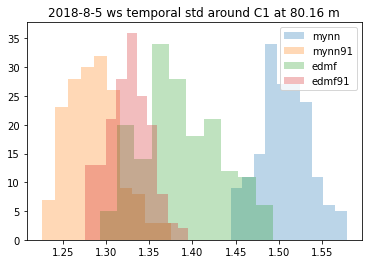

statistically INDIFFERENT distributions:

correlated distributions:


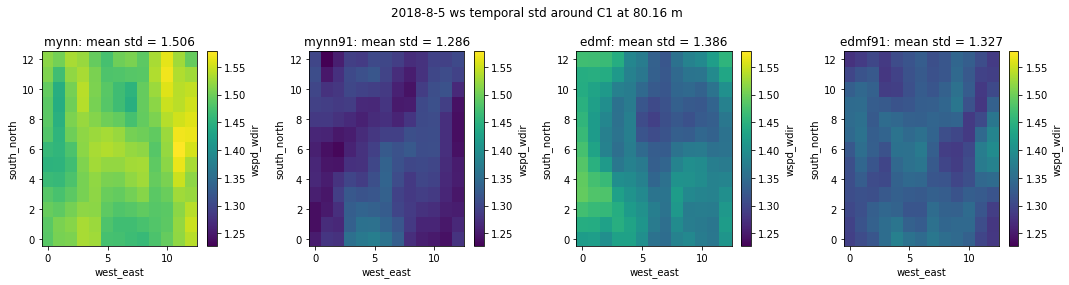


167.59 m
mynn mean: 1.423 std: 0.03
mynn91 mean: 1.212 std: 0.031
edmf mean: 1.307 std: 0.034
edmf91 mean: 1.217 std: 0.036


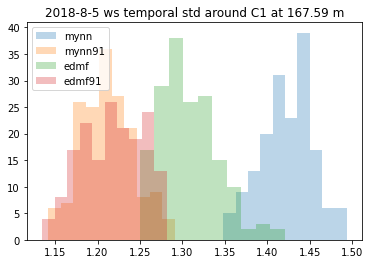

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:


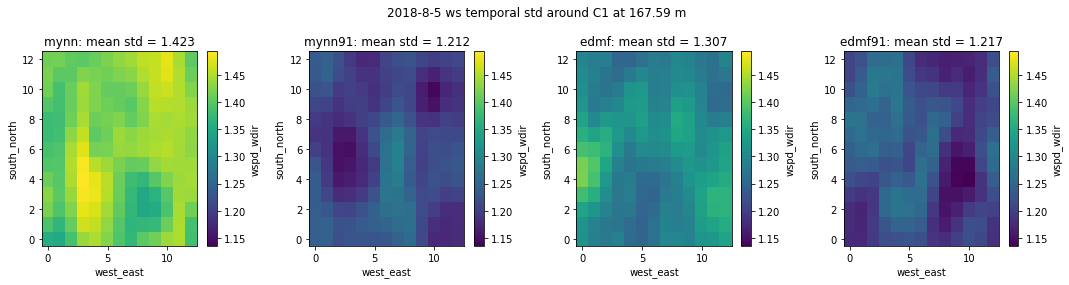


401.28 m
mynn mean: 1.589 std: 0.034
mynn91 mean: 1.366 std: 0.045
edmf mean: 1.421 std: 0.029
edmf91 mean: 1.46 std: 0.044


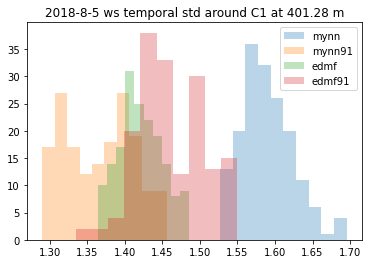

statistically INDIFFERENT distributions:

correlated distributions:
('mynn91', 'edmf91') -0.6980117427402288


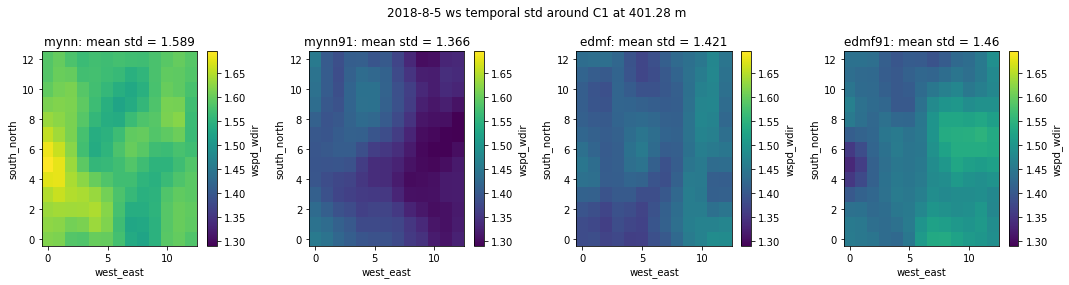

In [436]:
da_list = [ws_da_mynn_0805, ws_da_mynn91_0805, ws_da_edmf_0805, ws_da_edmf91_0805]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = hgt_mynn_0805

plot_std_hist(da_list, run_list, hgt_arr, 'ws')

7.13 m
mynn mean: 1.285 std: 0.042
mynn91 mean: 1.313 std: 0.057
edmf mean: 1.279 std: 0.045
edmf91 mean: 1.345 std: 0.059


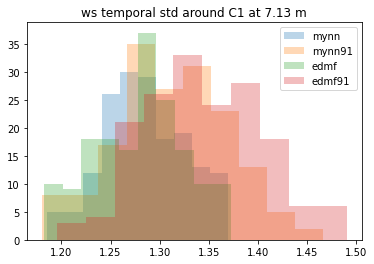

statistically INDIFFERENT distributions:
('mynn', 'edmf')


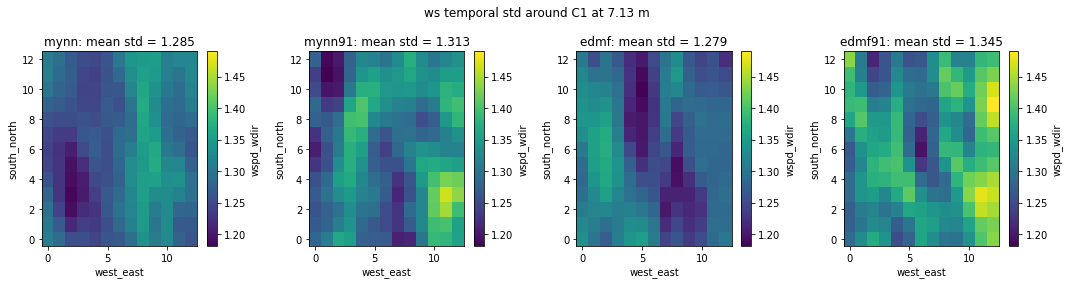


40.2 m
mynn mean: 1.817 std: 0.029
mynn91 mean: 1.778 std: 0.051
edmf mean: 1.738 std: 0.058
edmf91 mean: 1.796 std: 0.038


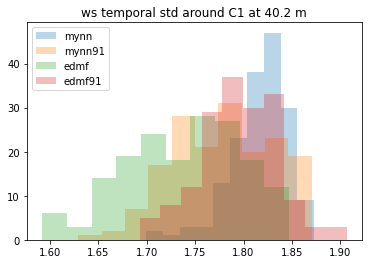

statistically INDIFFERENT distributions:


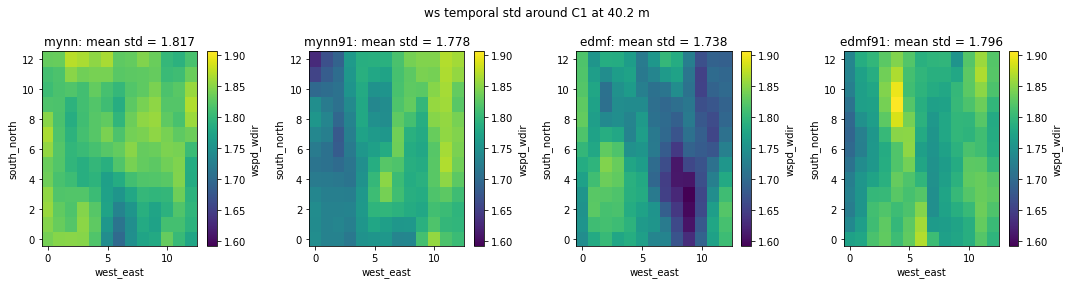


77.89 m
mynn mean: 1.738 std: 0.031
mynn91 mean: 1.657 std: 0.04
edmf mean: 1.638 std: 0.044
edmf91 mean: 1.67 std: 0.03


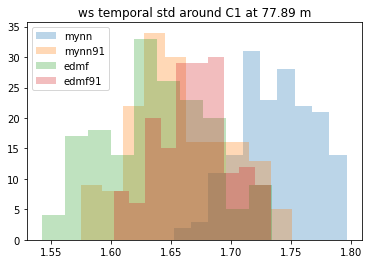

statistically INDIFFERENT distributions:


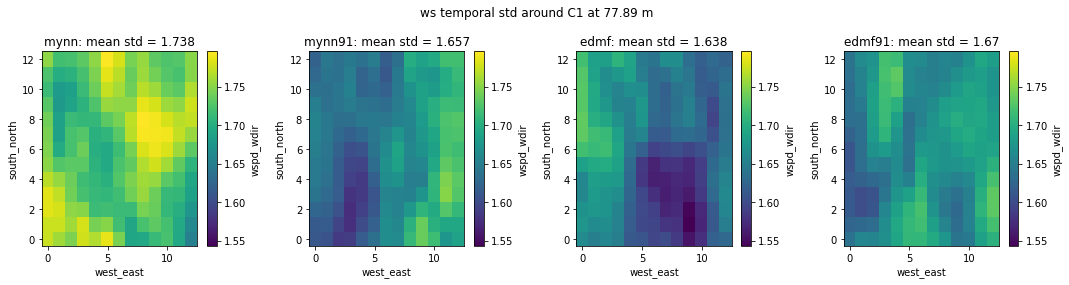


162.9 m
mynn mean: 1.685 std: 0.025
mynn91 mean: 1.598 std: 0.036
edmf mean: 1.61 std: 0.063
edmf91 mean: 1.627 std: 0.052


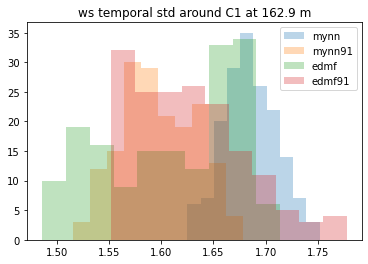

statistically INDIFFERENT distributions:


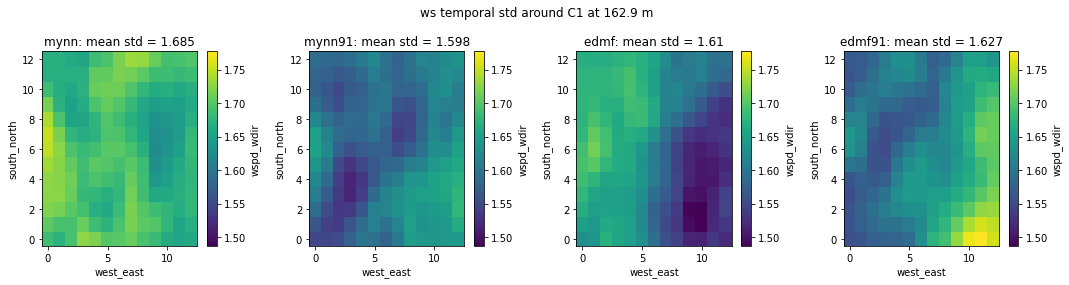


390.43 m
mynn mean: 2.168 std: 0.033
mynn91 mean: 2.091 std: 0.031
edmf mean: 2.088 std: 0.045
edmf91 mean: 2.119 std: 0.057


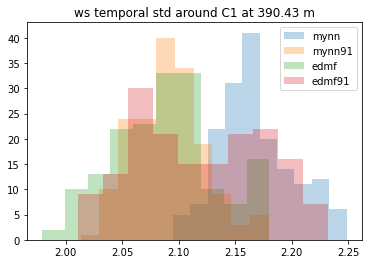

statistically INDIFFERENT distributions:
('mynn91', 'edmf')


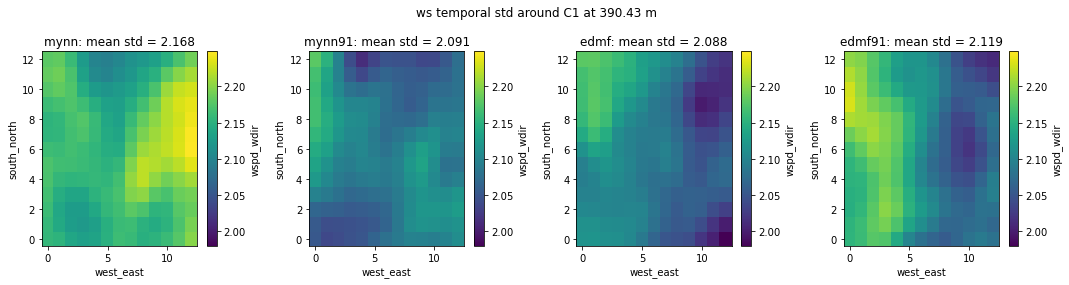

In [354]:
da_list = [ws_da_mynn_0901, ws_da_mynn91_0901, ws_da_edmf_0901, ws_da_edmf91_0901]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = hgt_mynn_0901

plot_std_hist(da_list, run_list, hgt_arr, 'ws')

7.34 m
mynn mean: 0.116 std: 0.005
mynn91 mean: 0.131 std: 0.017
edmf mean: 0.114 std: 0.005
edmf91 mean: 0.123 std: 0.014


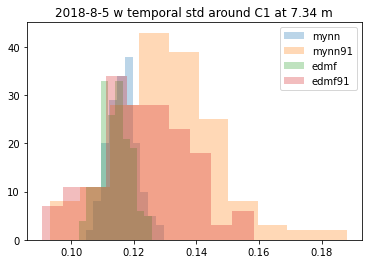

statistically INDIFFERENT distributions:

correlated distributions:
('mynn91', 'edmf91') 0.8779932517824545


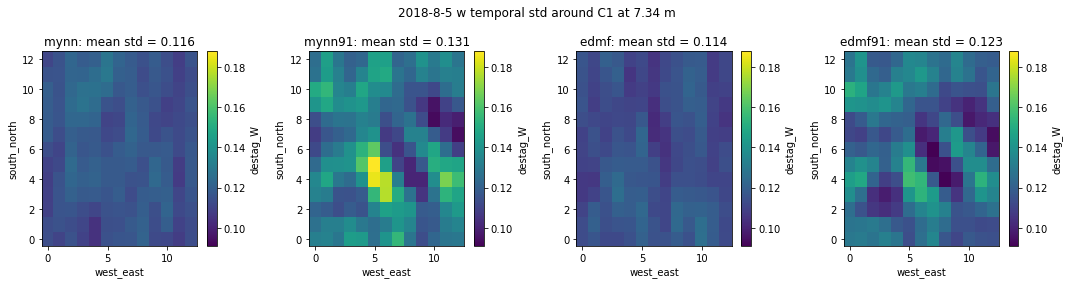


41.39 m
mynn mean: 0.595 std: 0.019
mynn91 mean: 0.593 std: 0.025
edmf mean: 0.59 std: 0.022
edmf91 mean: 0.563 std: 0.022


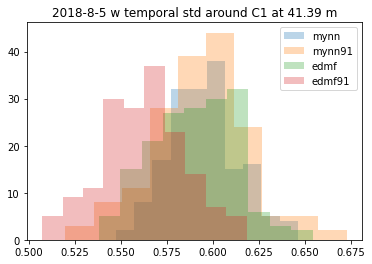

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn91', 'edmf')

correlated distributions:


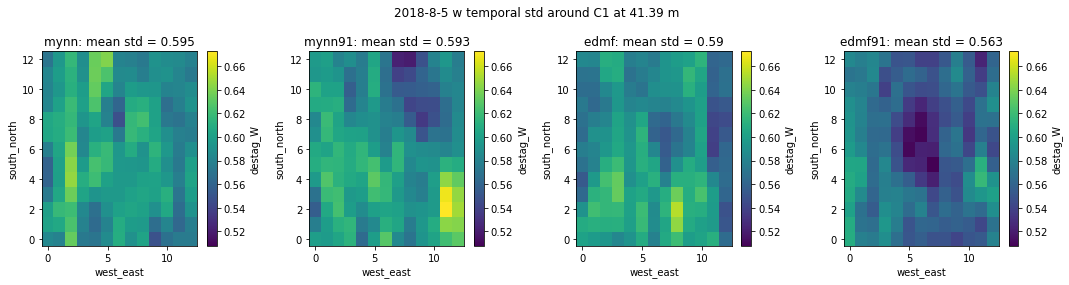


80.16 m
mynn mean: 0.913 std: 0.026
mynn91 mean: 0.904 std: 0.034
edmf mean: 0.917 std: 0.028
edmf91 mean: 0.869 std: 0.027


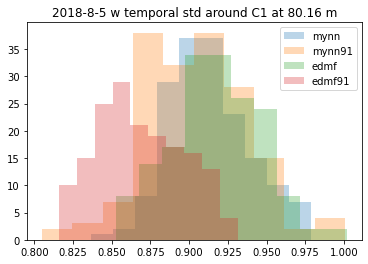

statistically INDIFFERENT distributions:
('mynn', 'edmf')

correlated distributions:


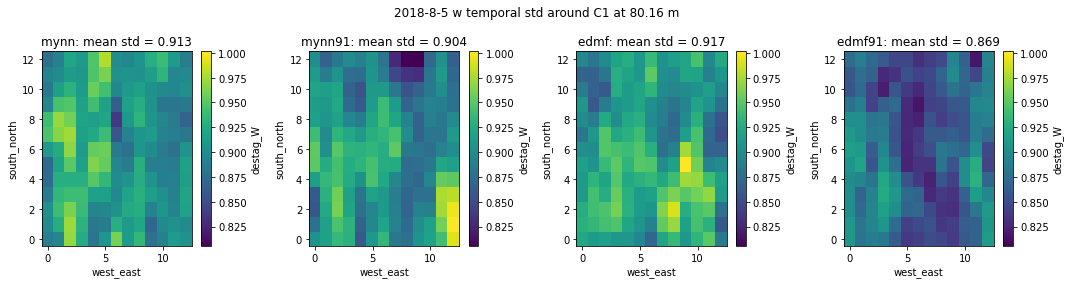


167.59 m
mynn mean: 1.246 std: 0.036
mynn91 mean: 1.189 std: 0.036
edmf mean: 1.253 std: 0.035
edmf91 mean: 1.196 std: 0.028


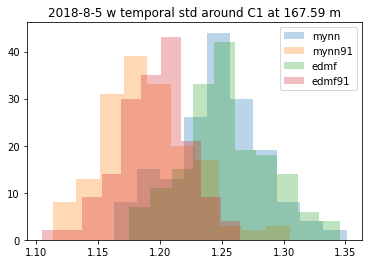

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')

correlated distributions:


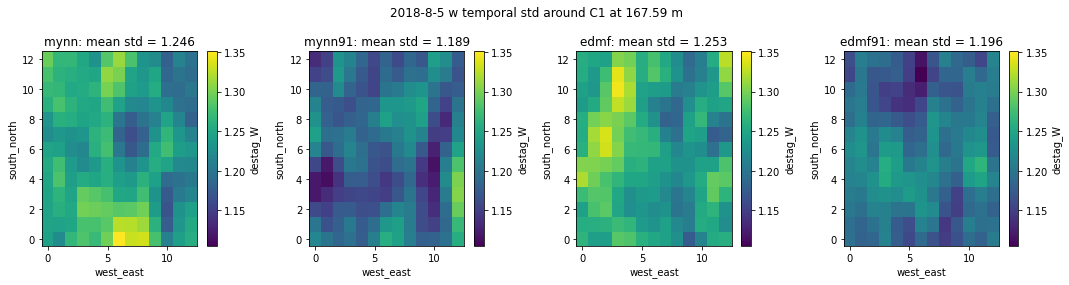


401.28 m
mynn mean: 1.467 std: 0.051
mynn91 mean: 1.343 std: 0.051
edmf mean: 1.466 std: 0.052
edmf91 mean: 1.403 std: 0.045


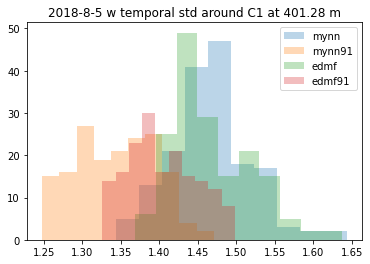

statistically INDIFFERENT distributions:
('mynn', 'edmf')

correlated distributions:


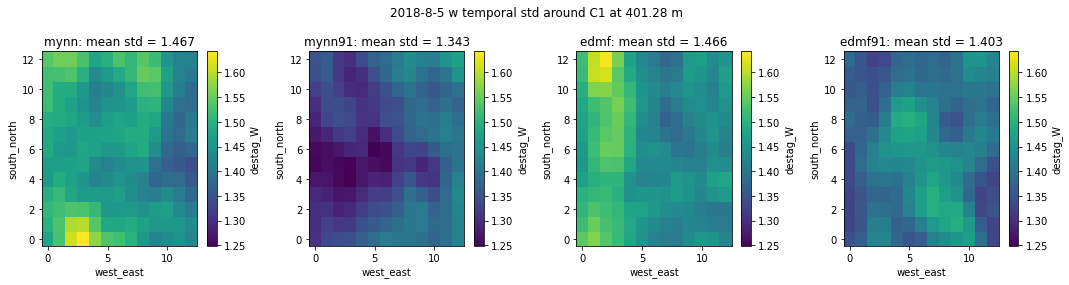

In [437]:
da_list = [w_da_mynn_0805, w_da_mynn91_0805, w_da_edmf_0805, w_da_edmf91_0805]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = hgt_mynn_0805

plot_std_hist(da_list, run_list, hgt_arr, 'w')

7.13 m
mynn mean: 0.099 std: 0.004
mynn91 mean: 0.119 std: 0.018
edmf mean: 0.098 std: 0.004
edmf91 mean: 0.122 std: 0.02


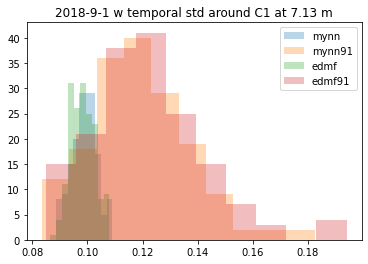

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')

correlated distributions:
('mynn91', 'edmf91') 0.9513224392125023


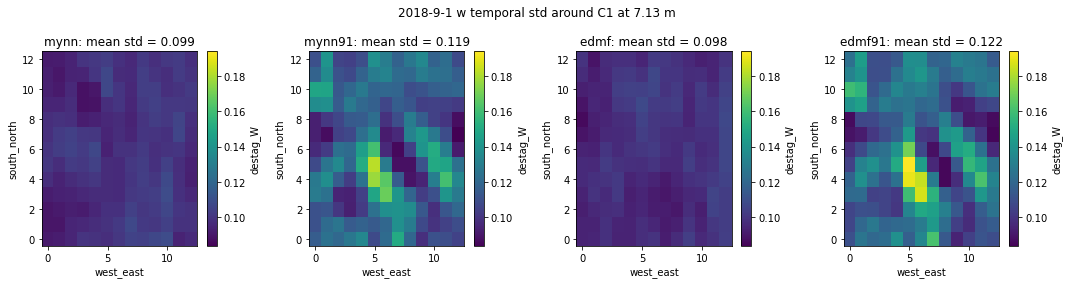


40.2 m
mynn mean: 0.512 std: 0.02
mynn91 mean: 0.518 std: 0.026
edmf mean: 0.508 std: 0.021
edmf91 mean: 0.517 std: 0.02


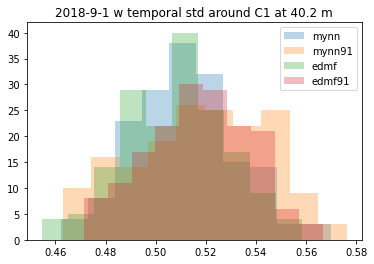

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')

correlated distributions:


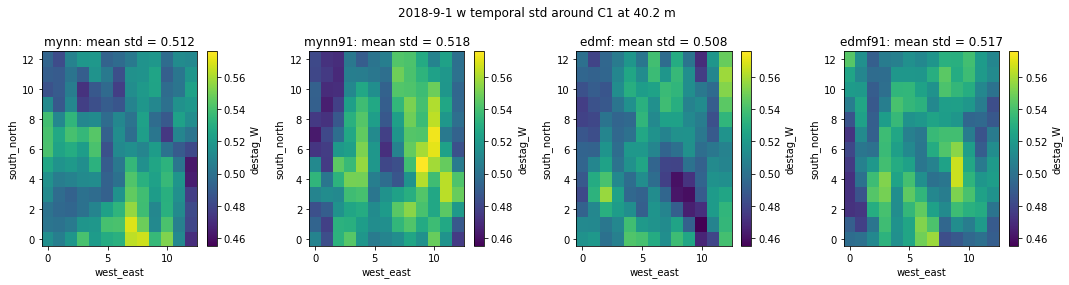


77.89 m
mynn mean: 0.796 std: 0.026
mynn91 mean: 0.807 std: 0.039
edmf mean: 0.794 std: 0.029
edmf91 mean: 0.81 std: 0.03


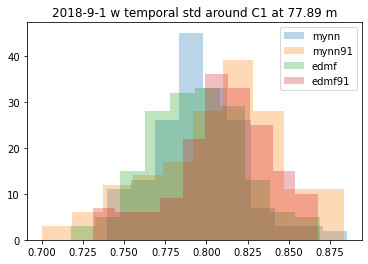

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')

correlated distributions:


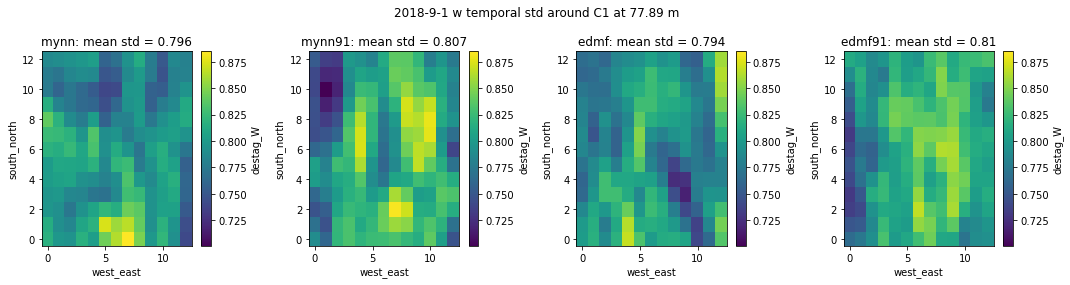


162.9 m
mynn mean: 1.068 std: 0.034
mynn91 mean: 1.124 std: 0.048
edmf mean: 1.102 std: 0.034
edmf91 mean: 1.138 std: 0.048


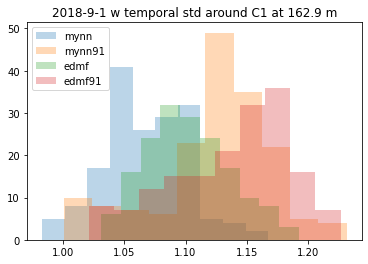

statistically INDIFFERENT distributions:

correlated distributions:


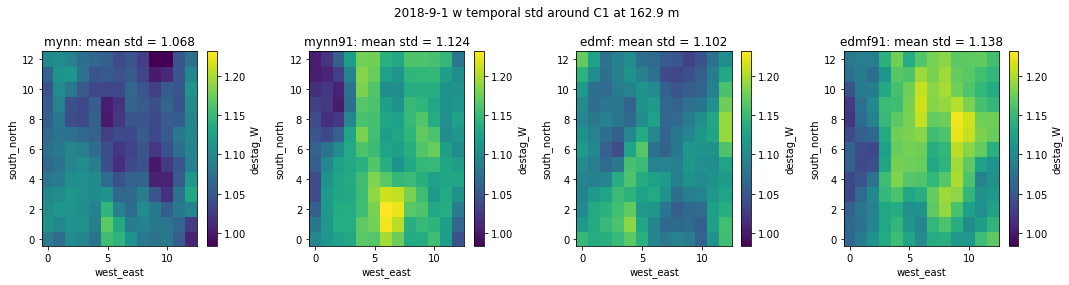


390.43 m
mynn mean: 1.206 std: 0.032
mynn91 mean: 1.251 std: 0.047
edmf mean: 1.285 std: 0.035
edmf91 mean: 1.283 std: 0.036


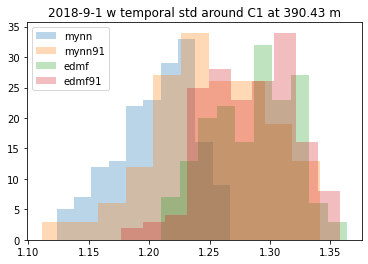

statistically INDIFFERENT distributions:
('edmf', 'edmf91')

correlated distributions:


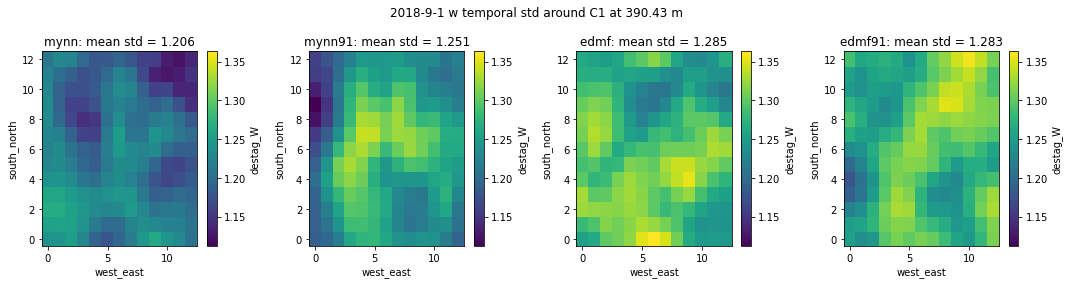

In [438]:
da_list = [w_da_mynn_0901, w_da_mynn91_0901, w_da_edmf_0901, w_da_edmf91_0901]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = hgt_mynn_0901

plot_std_hist(da_list, run_list, hgt_arr, 'w')

51.08 m
mynn mean: 0.693 std: 0.021
mynn91 mean: 0.69 std: 0.028
edmf mean: 0.69 std: 0.025
edmf91 mean: 0.656 std: 0.024


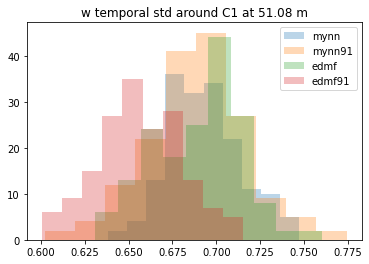

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')


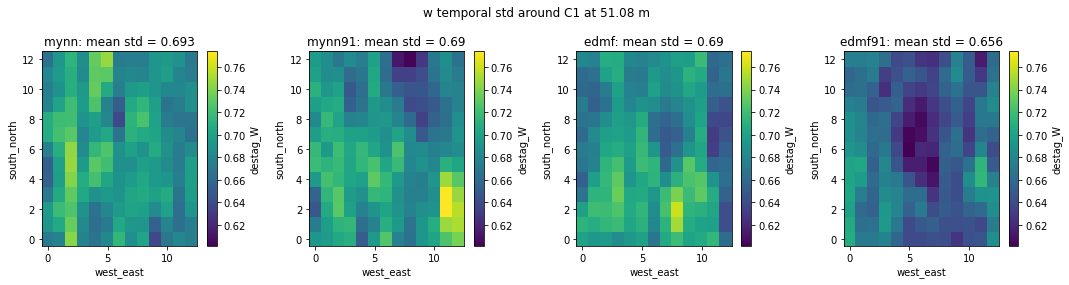


55.96 m
mynn mean: 0.737 std: 0.022
mynn91 mean: 0.733 std: 0.029
edmf mean: 0.735 std: 0.026
edmf91 mean: 0.698 std: 0.025


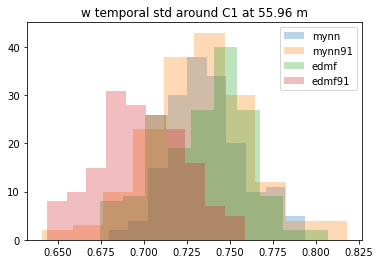

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')


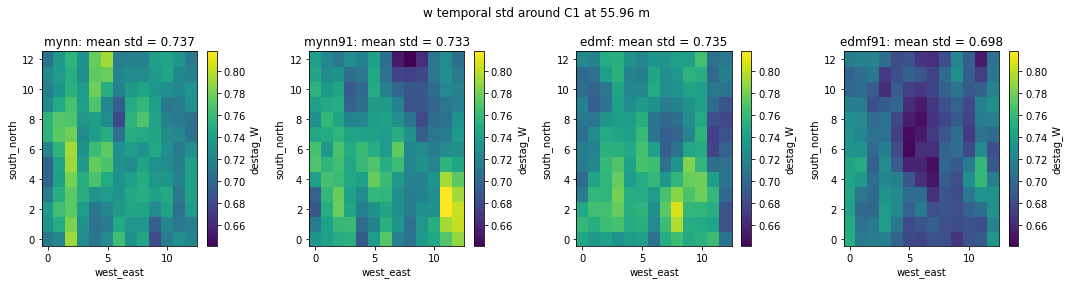


60.81 m
mynn mean: 0.778 std: 0.023
mynn91 mean: 0.773 std: 0.03
edmf mean: 0.777 std: 0.027
edmf91 mean: 0.737 std: 0.025


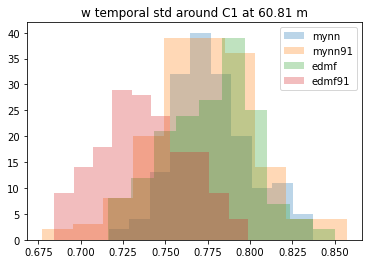

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')


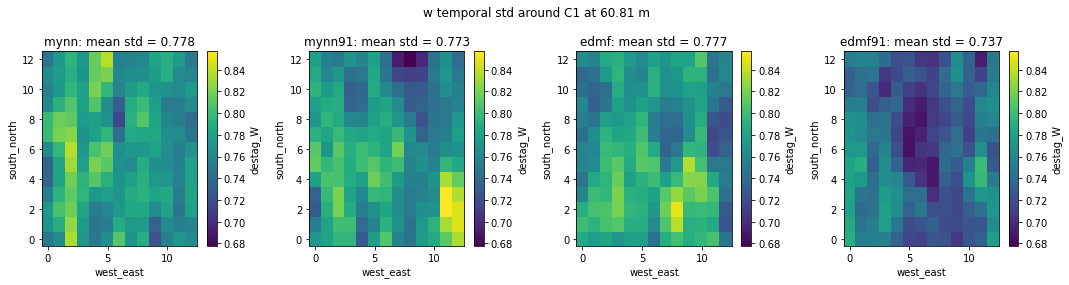


65.65 m
mynn mean: 0.815 std: 0.024
mynn91 mean: 0.81 std: 0.031
edmf mean: 0.816 std: 0.027
edmf91 mean: 0.773 std: 0.026


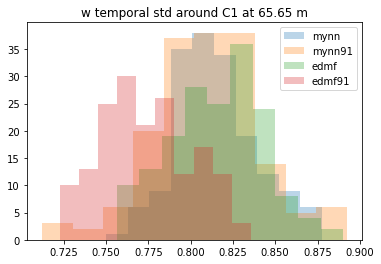

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')


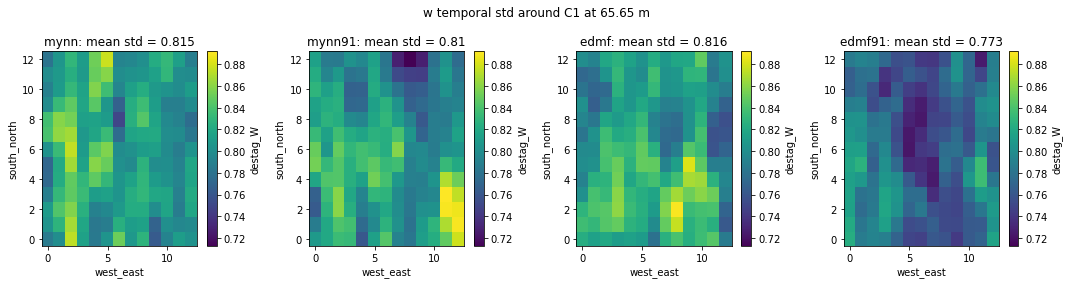


70.5 m
mynn mean: 0.85 std: 0.025
mynn91 mean: 0.844 std: 0.032
edmf mean: 0.852 std: 0.028
edmf91 mean: 0.807 std: 0.026


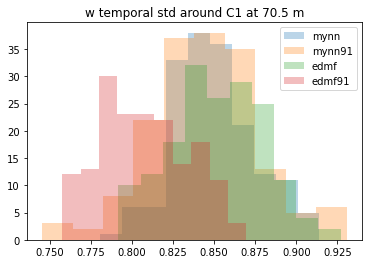

statistically INDIFFERENT distributions:
('mynn', 'edmf')


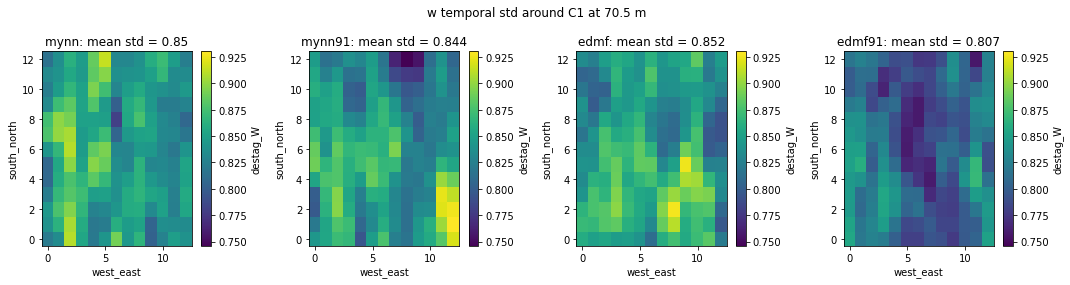


75.31 m
mynn mean: 0.883 std: 0.025
mynn91 mean: 0.875 std: 0.033
edmf mean: 0.886 std: 0.028
edmf91 mean: 0.839 std: 0.027


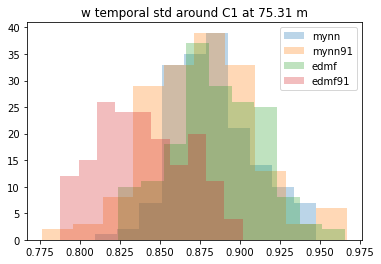

statistically INDIFFERENT distributions:
('mynn', 'edmf')


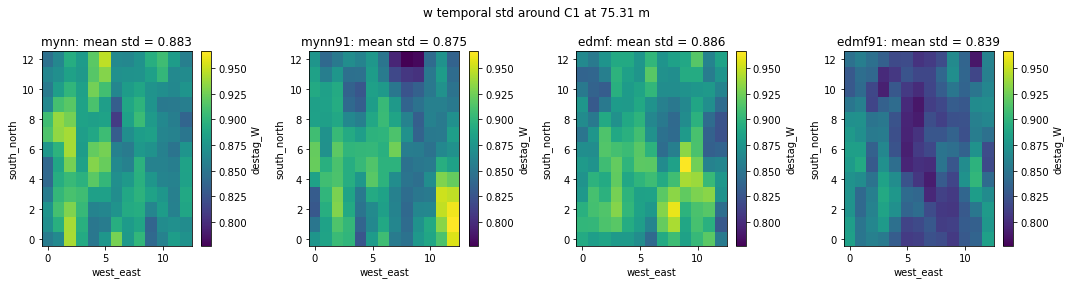


80.16 m
mynn mean: 0.913 std: 0.026
mynn91 mean: 0.904 std: 0.034
edmf mean: 0.917 std: 0.028
edmf91 mean: 0.869 std: 0.027


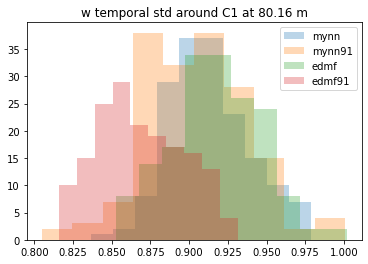

statistically INDIFFERENT distributions:
('mynn', 'edmf')


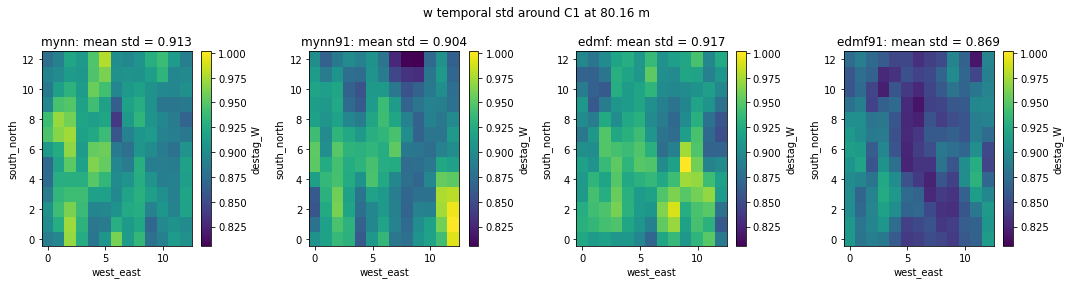


85.01 m
mynn mean: 0.942 std: 0.027
mynn91 mean: 0.931 std: 0.034
edmf mean: 0.947 std: 0.029
edmf91 mean: 0.897 std: 0.028


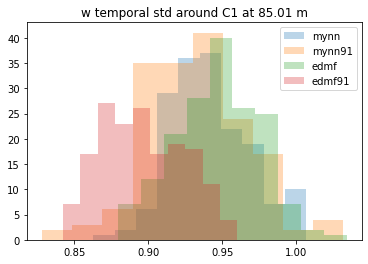

statistically INDIFFERENT distributions:
('mynn', 'edmf')


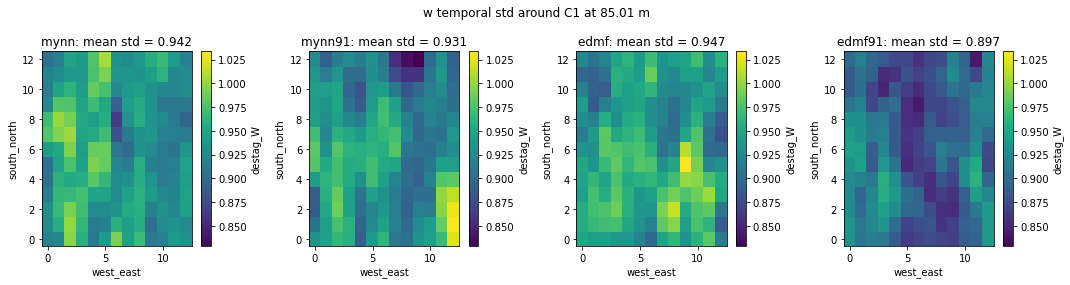


89.86 m
mynn mean: 0.969 std: 0.027
mynn91 mean: 0.956 std: 0.034
edmf mean: 0.975 std: 0.029
edmf91 mean: 0.923 std: 0.028


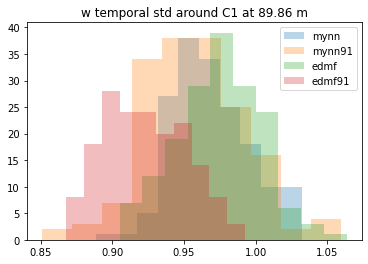

statistically INDIFFERENT distributions:
('mynn', 'edmf')


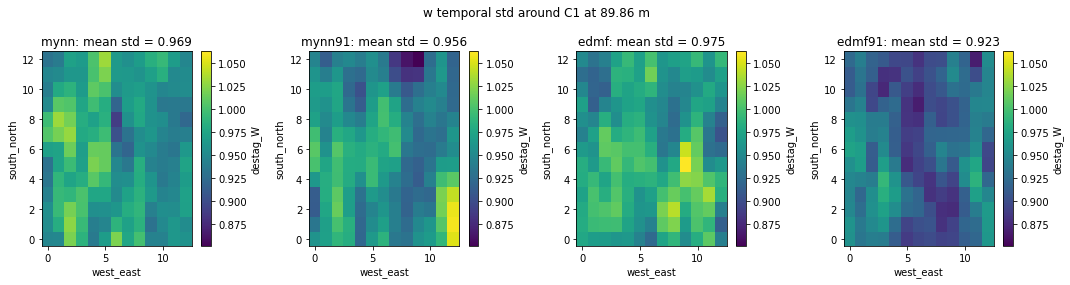


94.71 m
mynn mean: 0.994 std: 0.027
mynn91 mean: 0.98 std: 0.034
edmf mean: 1.001 std: 0.029
edmf91 mean: 0.948 std: 0.029


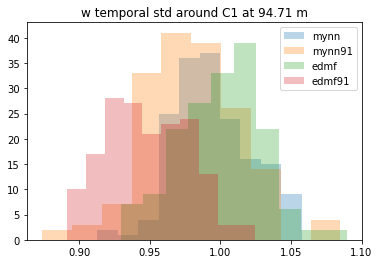

statistically INDIFFERENT distributions:


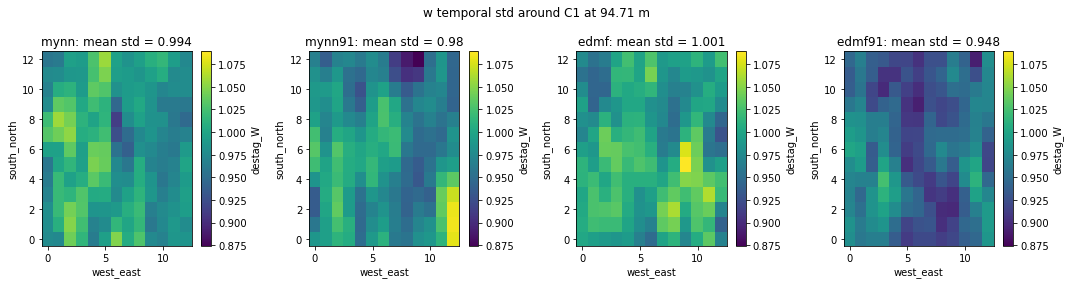

In [358]:
da_list = [w_da_mynn_0805, w_da_mynn91_0805, w_da_edmf_0805, w_da_edmf91_0805]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = hgt_mynn_0805

plot_std_hist(da_list, run_list, hgt_arr, 'w')

49.62 m
mynn mean: 0.6 std: 0.023
mynn91 mean: 0.605 std: 0.031
edmf mean: 0.595 std: 0.024
edmf91 mean: 0.605 std: 0.022


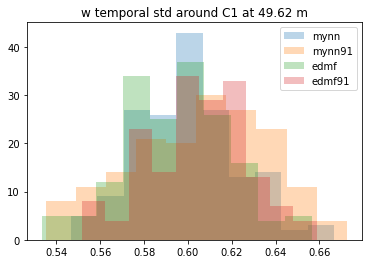

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf91')


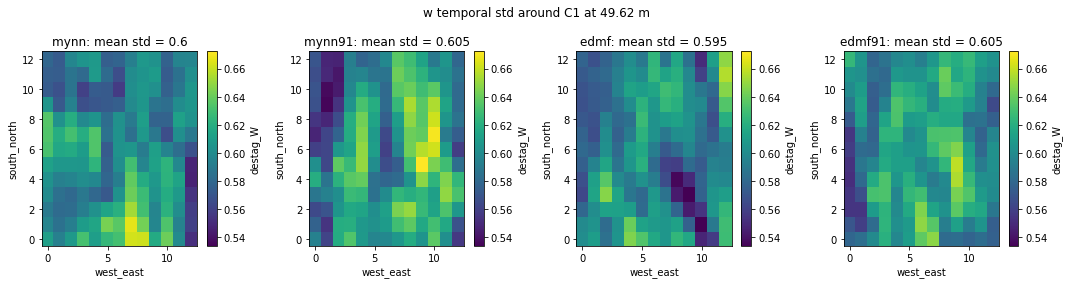


54.37 m
mynn mean: 0.639 std: 0.024
mynn91 mean: 0.645 std: 0.033
edmf mean: 0.635 std: 0.025
edmf91 mean: 0.645 std: 0.023


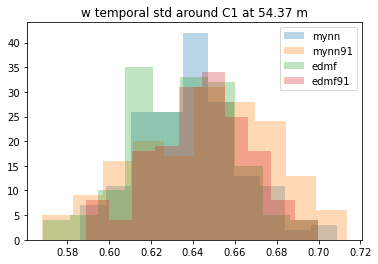

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf91')


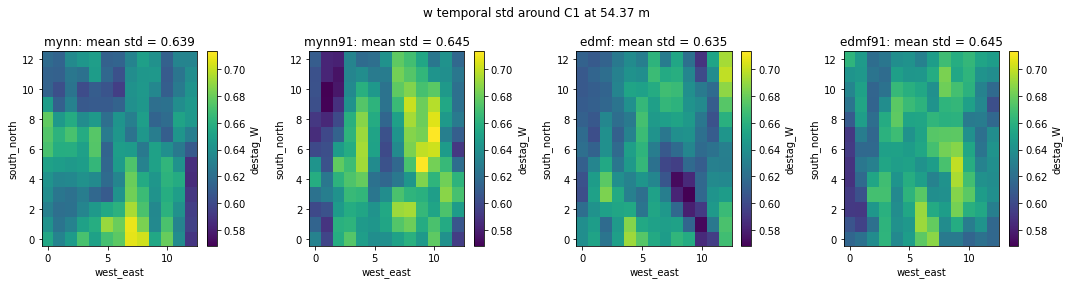


59.08 m
mynn mean: 0.676 std: 0.025
mynn91 mean: 0.682 std: 0.034
edmf mean: 0.671 std: 0.026
edmf91 mean: 0.683 std: 0.025


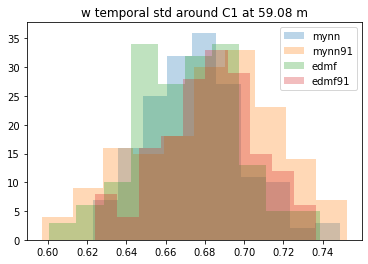

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf91')


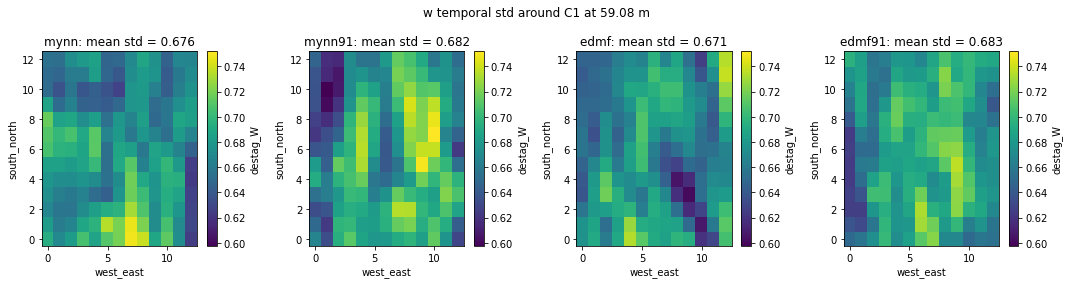


63.79 m
mynn mean: 0.709 std: 0.025
mynn91 mean: 0.716 std: 0.036
edmf mean: 0.705 std: 0.027
edmf91 mean: 0.718 std: 0.026


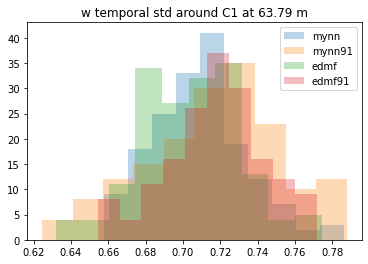

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')


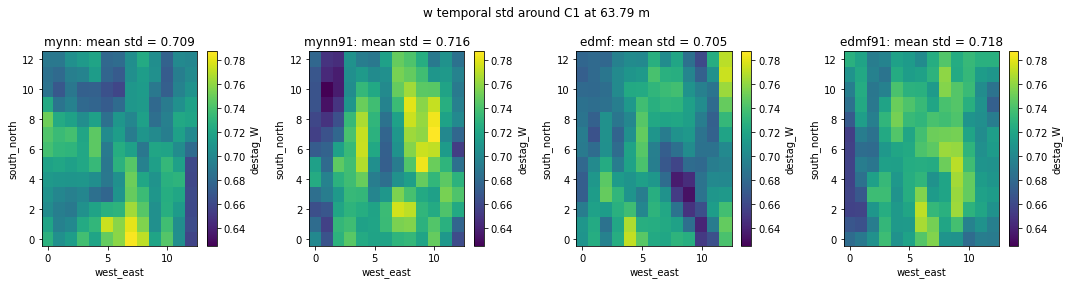


68.5 m
mynn mean: 0.74 std: 0.026
mynn91 mean: 0.749 std: 0.037
edmf mean: 0.737 std: 0.028
edmf91 mean: 0.751 std: 0.027


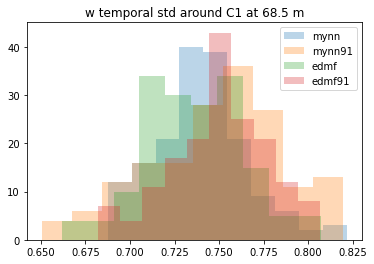

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')


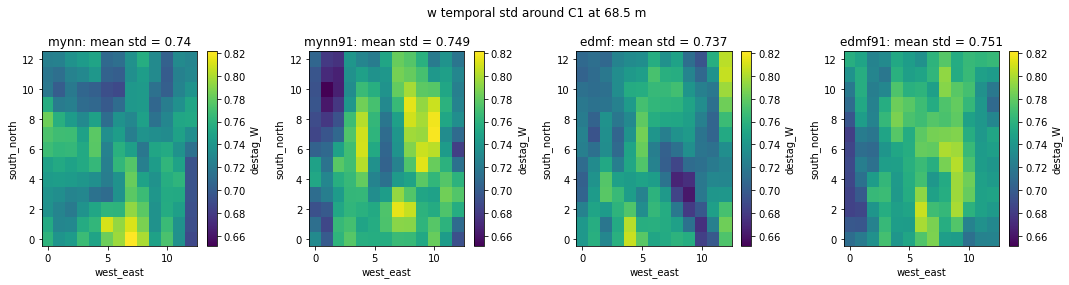


73.18 m
mynn mean: 0.769 std: 0.026
mynn91 mean: 0.779 std: 0.038
edmf mean: 0.766 std: 0.028
edmf91 mean: 0.781 std: 0.028


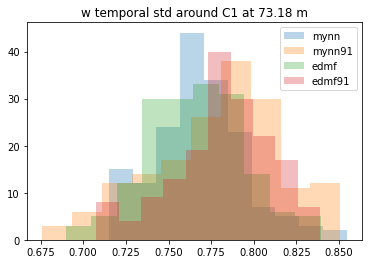

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')


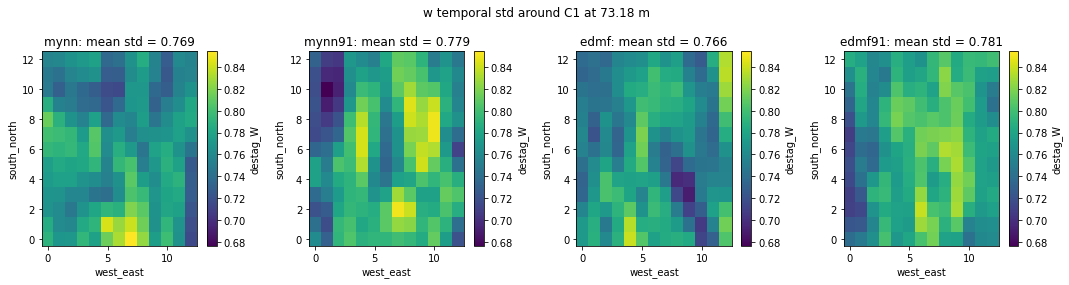


77.89 m
mynn mean: 0.796 std: 0.026
mynn91 mean: 0.807 std: 0.039
edmf mean: 0.794 std: 0.029
edmf91 mean: 0.81 std: 0.03


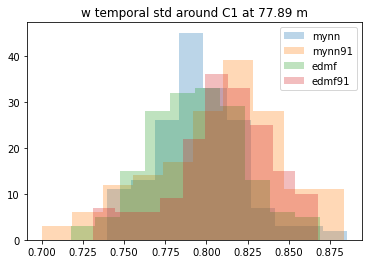

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')


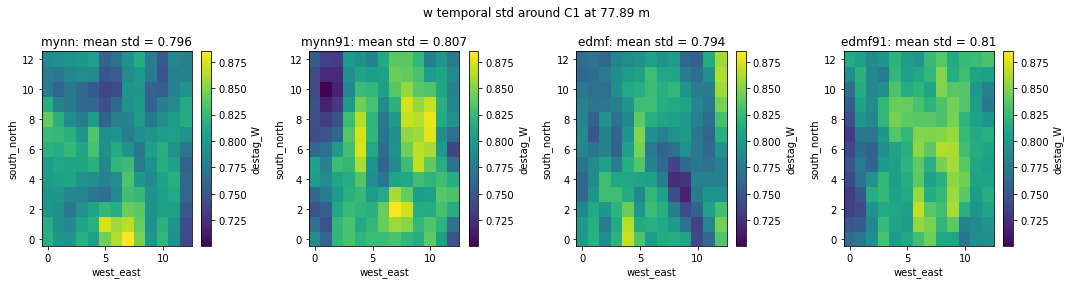


82.61 m
mynn mean: 0.82 std: 0.027
mynn91 mean: 0.834 std: 0.04
edmf mean: 0.82 std: 0.029
edmf91 mean: 0.838 std: 0.031


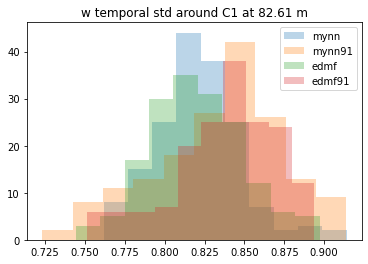

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')


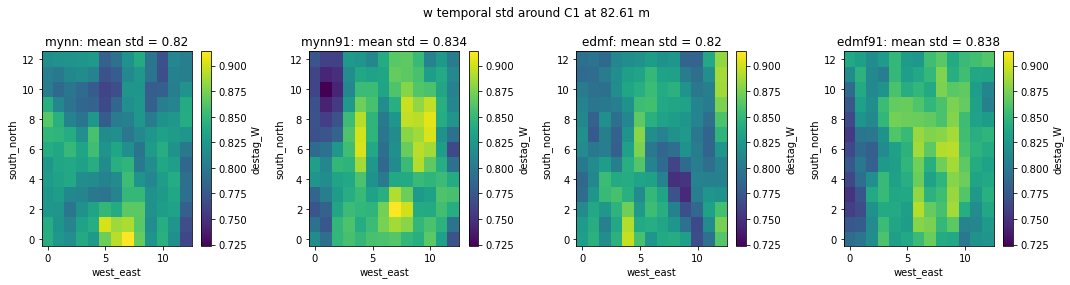


87.33 m
mynn mean: 0.843 std: 0.027
mynn91 mean: 0.859 std: 0.04
edmf mean: 0.844 std: 0.029
edmf91 mean: 0.864 std: 0.033


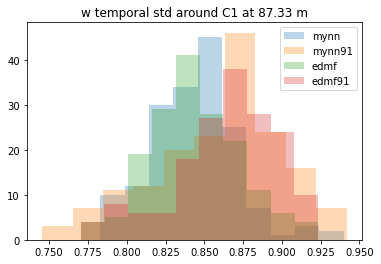

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')


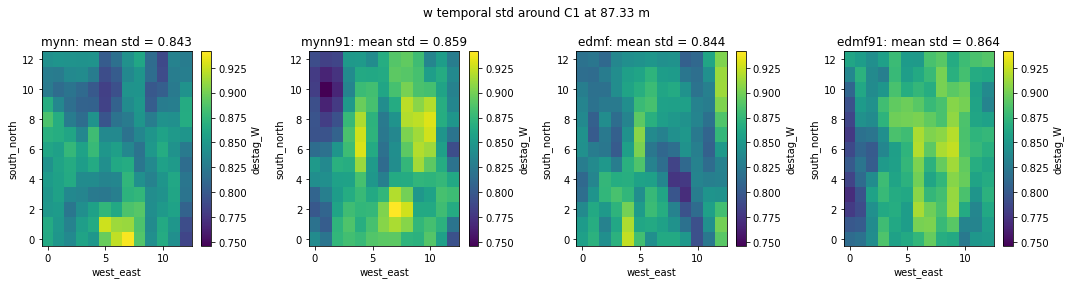


92.05 m
mynn mean: 0.865 std: 0.027
mynn91 mean: 0.883 std: 0.041
edmf mean: 0.868 std: 0.029
edmf91 mean: 0.889 std: 0.035


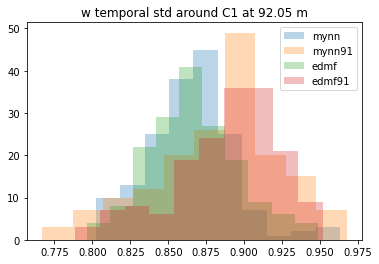

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')


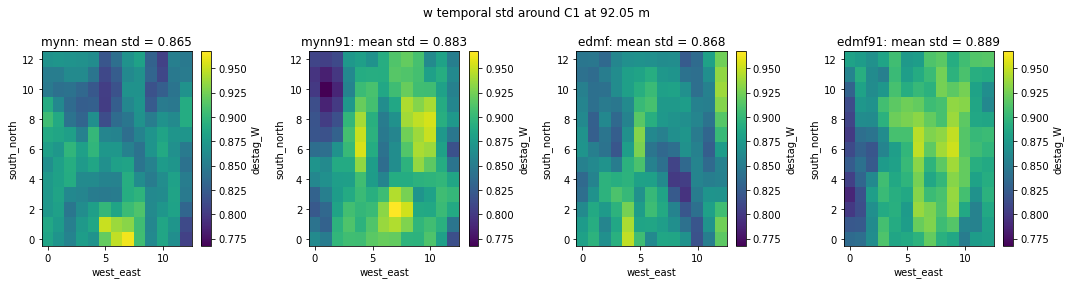

In [359]:
da_list = [w_da_mynn_0901, w_da_mynn91_0901, w_da_edmf_0901, w_da_edmf91_0901]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = hgt_mynn_0901

plot_std_hist(da_list, run_list, hgt_arr, 'w')

In [386]:
def print_std_ttest(da_list, run_list, hgt_arr, met_var):
    
    al_pha = 0.3

#     for hgt_i in [1, 8, 16, 30, 45]:
#     for hgt_i in [1, 8]:
    for hgt_i in np.arange(5, 25):

        print(np.round(hgt_arr.values[hgt_i], 2), 'm')
        
#         std_dict = {}
        arr_dict = {}
#         v_min, v_max = 1e10, 0

        for da, run_name in zip(da_list, run_list):
            
            std = da[:, hgt_i, :, :].std(dim='Time')
            std_samples = np.array(std).flatten()
            
#             plt.hist(std_samples.flatten(), label=run_name, alpha=al_pha)
#             print(run_name, 'mean:', np.round(std.mean().values, 3), 
#                   'std:', np.round(std.std().values, 3))
            
#             std_dict[run_name] = std
            arr_dict[run_name] = std_samples
            
#             if std.min() < v_min:
#                 v_min = std.min()
#             if std.max() > v_max:
#                 v_max = std.max()

#         plt.title(met_var+' temporal std around C1 at '+str(np.round(hgt_arr.values[hgt_i], 2))+' m')
#         plt.legend()
#         plt.show()
        
        print('statistically INDIFFERENT distributions:')
        
        for pair in itertools.combinations(arr_dict.keys(), 2):

            stat, pval = stats.ttest_ind(arr_dict[pair[0]], arr_dict[pair[1]])
            
            if pval >= 0.05:
                print(pair)

        print('correlated distributions:')
        
        for pair in itertools.combinations(arr_dict.keys(), 2):
                
            corr = np.corrcoef(arr_dict[pair[0]], arr_dict[pair[1]])
            
            if (corr[1, 0] < -0.6) or (corr[1, 0] > 0.6):
                print()
                print()
                print()
                print(pair, corr[1, 0], '!!!')
                print()
                print()
                print()
        
#         fig, ax = plt.subplots(1, 4, figsize=(15, 4))
#         ax_i = 0
        
#         for run in std_dict.keys():
        
#             std_dict[run].plot(ax=ax[ax_i], vmin=v_min, vmax=v_max)
#             ax[ax_i].set_title(run+': mean std = '+str(np.round(std_dict[run].mean().values, 3)))
            
#             ax_i += 1
            
#         plt.suptitle(met_var+' temporal std around C1 at '+str(np.round(hgt_arr.values[hgt_i], 2))+' m')
#         plt.tight_layout()
#         plt.show()
        
#         print()

In [387]:
da_list = [w_da_mynn_0805, w_da_mynn91_0805, w_da_edmf_0805, w_da_edmf91_0805]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = hgt_mynn_0805

print_std_ttest(da_list, run_list, hgt_arr, 'w')

26.82 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')
correlated distributions:
31.7 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')
correlated distributions:
36.55 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn91', 'edmf')
correlated distributions:
41.39 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn91', 'edmf')
correlated distributions:
46.23 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')
correlated distributions:
51.08 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')
correlated distributions:
55.96 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')
correlated distributions:
60.81 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')
correlated distributions:
65.65 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')

In [388]:
da_list = [w_da_mynn_0901, w_da_mynn91_0901, w_da_edmf_0901, w_da_edmf91_0901]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = hgt_mynn_0901

print_std_ttest(da_list, run_list, hgt_arr, 'w')

26.04 m
statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')
correlated distributions:
30.79 m
statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')
correlated distributions:
35.49 m
statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')
correlated distributions:
40.2 m
statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')
correlated distributions:
44.91 m
statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf91')
correlated distributions:
49.62 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf91')
correlated distributions:
54.37 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf91')
correlated distributions:
59.08 m
statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf91')
correlated distributions:
63.79 m
statistically INDIFFERENT distri

In [259]:
def plot_std_profile(da_list, run_list, hgt_arr, ylow, yup):

    for da, run_name in zip(da_list, run_list):

        line = da.std(dim='Time').mean(dim=['south_north', 'west_east'])
        shade = da.std(dim='Time').std(dim=['south_north', 'west_east'])

        plt.plot(line, hgt_arr, label=run_name)
        plt.fill_betweenx(hgt_arr, line-shade, line+shade, alpha=0.2)

    plt.ylim(0, 300)
    plt.xlim(ylow, yup)
    plt.legend()
    plt.show()

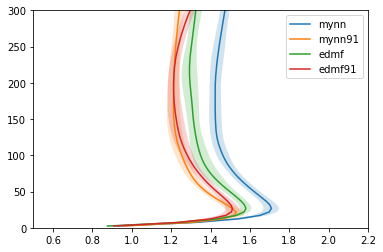

In [260]:
da_list = [ws_da_mynn_0805, ws_da_mynn91_0805, ws_da_edmf_0805, ws_da_edmf91_0805]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = hgt_mynn_0805
ylow, yup = 0.5, 2.2

plot_std_profile(da_list, run_list, hgt_arr, ylow, yup)

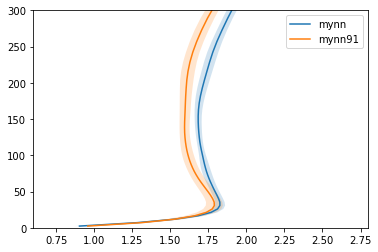

In [263]:
da_list = [ws_da_mynn_0901, ws_da_mynn91_0901]
run_list = ['mynn', 'mynn91']
# da_list = [ws_da_mynn_0901, ws_da_mynn91_0901, ws_da_edmf_0901, ws_da_edmf91_0901]
# run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = hgt_mynn_0901
ylow, yup = 0.6, 2.8

plot_std_profile(da_list, run_list, hgt_arr, ylow, yup)

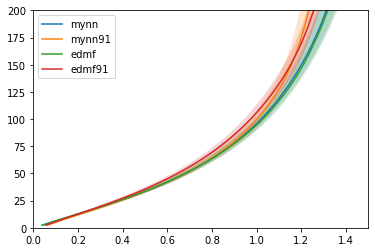

In [166]:
da_list = [w_da_mynn_0805, w_da_mynn91_0805, w_da_edmf_0805, w_da_edmf91_0805]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = hgt_mynn_0805
ylow, yup = 0, 1.5

plot_std_profile(da_list, run_list, hgt_arr, ylow, yup)

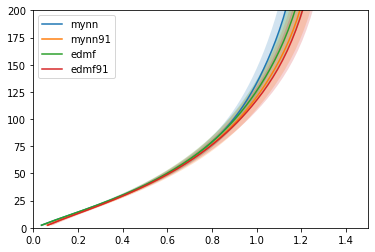

In [168]:
da_list = [w_da_mynn_0901, w_da_mynn91_0901, w_da_edmf_0901, w_da_edmf91_0901]
hgt_arr = hgt_mynn_0901
ylow, yup = 0, 1.5

plot_std_profile(da_list, run_list, hgt_arr, ylow, yup)

In [212]:
ws_da_mynn_0805[:, 0, 0, 0]

<xarray.DataArray 'wspd_wdir' (Time: 540)>
array([ 2.997243 ,  4.1362314,  4.446641 ,  3.771892 ,  2.820937 ,
        3.857314 ,  5.2798805,  4.6541533,  3.6083272,  3.555434 ,
        4.211775 ,  4.9464335,  4.281453 ,  3.6291401,  2.4317164,
        3.139323 ,  3.2527442,  3.788664 ,  4.3914413,  3.644892 ,
        5.1376314,  4.569133 ,  4.056358 ,  5.084041 ,  3.8009775,
        4.495952 ,  5.3105273,  5.351306 ,  3.6323662,  3.3273695,
        4.8116345,  4.49368  ,  5.147577 ,  5.738247 ,  4.544325 ,
        4.0410776,  3.1377864,  2.7208169,  3.356798 ,  4.067085 ,
        4.3383203,  4.8844576,  4.808723 ,  3.9731083,  3.1152623,
        4.531242 ,  4.5389166,  5.1478906,  4.752286 ,  3.9912896,
        3.74056  ,  3.131477 ,  2.9090214,  4.278167 ,  4.1733947,
        3.5890665,  3.4664109,  2.8180802,  2.4461954,  5.733034 ,
        4.5699277,  4.201884 ,  4.024184 ,  2.768943 ,  3.222665 ,
        4.0288434,  3.9116642,  5.1603856,  3.4762156,  3.1665494,
        4.897018 ,  3.3334305,  3.1311507,  2.4696634,  2.5033255,
        3.1254635,  3.9036975,  2.904099 ,  2.4647593,  3.3422678,
        2.307437 ,  2.7262087,  3.7132537,  3.484778 ,  3.8676512,
        3.3320143,  3.1411154,  3.6374733,  3.4200134,  3.4843755,
        5.1308937,  4.9668365,  3.970357 ,  2.7224202,  3.47898  ,
        3.4816906,  3.667333 ,  4.3524485,  4.07709  ,  3.0992897,
...
        2.813309 ,  3.1697938,  3.6469011,  3.276226 ,  2.8012702,
        3.7285361,  2.8927505,  2.8747375,  3.564885 ,  3.0415227,
        4.771545 ,  2.8625722,  2.7398956,  4.101029 ,  5.353655 ,
        5.865189 ,  6.876045 ,  4.191821 ,  4.2578144,  4.187763 ,
        3.629552 ,  3.2534897,  2.5360124,  2.387407 ,  4.3292713,
        4.6206784,  2.7032404,  3.3684988,  2.3544903,  3.6682532,
        4.91175  ,  4.468548 ,  3.611952 ,  2.8049421,  6.04977  ,
        3.6139119,  4.1406026,  3.251938 ,  2.6181188,  2.741974 ,
        3.502272 ,  4.847048 ,  4.82704  ,  3.4640698,  3.7660532,
        4.970157 ,  5.6474485,  6.6887097,  5.0186596,  6.114597 ,
        6.015603 ,  3.7530568,  3.5111902,  5.216675 ,  5.6617665,
        6.6382465,  4.000229 ,  2.6912189,  2.978813 ,  2.2713897,
        6.4493766,  3.1659615,  4.19999  ,  3.5110526,  3.8055913,
        5.333195 ,  5.943775 ,  4.442664 ,  3.5324824,  5.0841074,
        4.379839 ,  3.916779 ,  4.6834598,  5.0946865,  4.053702 ,
        3.5570285,  3.9242053,  2.6275928,  2.408417 ,  3.6165488,
        4.658429 ,  4.731348 ,  3.8540297,  4.5720983,  3.510359 ,
        3.005872 ,  4.7574143,  4.8335376,  4.280936 ,  3.7047143,
        3.298843 ,  3.921619 ,  5.5596147,  5.562305 ,  3.8714356],
      dtype=float32)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XLONG      float32 -97.49
    XLAT       float32 36.6
    XTIME      (Time) float32 1.56e+03 1.561e+03 ... 2.098e+03 2.099e+03
  * Time       (Time) datetime64[ns] 2018-08-05T14:00:00 ... 2018-08-05T22:59:00
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  wspd,wdir in projection space
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

## deviation from temporal mean

/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


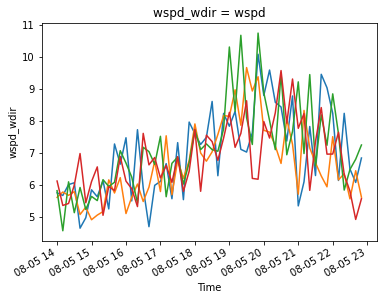

In [256]:
hgt_i = 16
fig, ax = plt.subplots()

for da in [ws_da_mynn_0805, ws_da_mynn91_0805, ws_da_edmf_0805, ws_da_edmf91_0805]:
# da = ws_da_mynn_0805

    ti = 100*abs(da - da.rolling(Time=10, center=True).mean())/da.rolling(Time=10, center=True).mean()
    ti_mean = ti[:, hgt_i, :, :].mean(dim=['south_north', 'west_east']).resample(Time='10min').mean()
    ti_std = ti[:, hgt_i, :, :].std(dim=['south_north', 'west_east']).resample(Time='10min').mean()

    ti_std.plot(ax=ax)
#     ti_mean.plot(ax=ax)
#     ax.fill_between(ti_mean['Time'], ti_mean-ti_std, ti_mean+ti_std, alpha=0.2)

/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


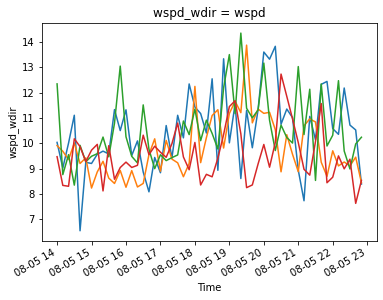

In [262]:
hgt_i = 3
fig, ax = plt.subplots()

for da in [ws_da_mynn_0805, ws_da_mynn91_0805, ws_da_edmf_0805, ws_da_edmf91_0805]:
# da = ws_da_mynn_0805

    ti = 100*abs(da - da.rolling(Time=10, center=True).mean())/da.rolling(Time=10, center=True).mean()
    ti_mean = ti[:, hgt_i, :, :].mean(dim=['south_north', 'west_east']).resample(Time='10min').mean()
    ti_std = ti[:, hgt_i, :, :].std(dim=['south_north', 'west_east']).resample(Time='10min').mean()

    ti_std.plot(ax=ax)
#     ti_mean.plot(ax=ax)
#     ax.fill_between(ti_mean['Time'], ti_mean-ti_std, ti_mean+ti_std, alpha=0.2)

In [158]:
def plot_dev_std_hist(da_list, run_list, hgt_arr, met_var, minute_period, std_or_mean='std'):
    
    al_pha = 0.3

#     for hgt_i in [1, 8, 16, 30, 45]:
#     for hgt_i in [1, 8]:
    for hgt_i in np.arange(0, 10):

        print(np.round(hgt_arr.values[hgt_i], 2), 'm')
    
        time = pd.Timestamp(hgt_arr['Time'].values)
        year = str(time.year)
        month = str(time.month)
        day = str(time.day)
        
        std_dict = {}
        arr_dict = {}
        v_min, v_max = 1e10, 0

        for da, run_name in zip(da_list, run_list):
            
            da_1h = da[:, hgt_i, :, :]
            
            if met_var == 'ws':
                ti = (100*abs(da_1h - da_1h.rolling(Time=minute_period, center=True).mean())
                      /da_1h.rolling(Time=minute_period, center=True).mean())
            elif met_var == 'w':
                ti = (abs(da_1h - da_1h.rolling(Time=minute_period, center=True).mean()))
            
            if std_or_mean == 'mean':
                std = ti.mean(dim='Time')
            elif std_or_mean == 'std':
                std = ti.std(dim='Time')
                
            std_samples = np.array(std).flatten()
            
            plt.hist(std_samples.flatten(), label=run_name, alpha=al_pha)
            print(run_name, 'mean:', np.round(std.mean().values, 3), 
                  'std:', np.round(std.std().values, 3))
            
            std_dict[run_name] = std
            arr_dict[run_name] = std_samples
            
            if std.min() < v_min:
                v_min = std.min()
            if std.max() > v_max:
                v_max = std.max()

        plt.title(year+'-'+month+'-'+day+' '+met_var+' deviation from '+str(minute_period)
                  +' min mean temporal std around C1 at '+str(np.round(hgt_arr.values[hgt_i], 2))+' m')
        plt.legend()
        plt.show()
        
        print('statistically INDIFFERENT distributions:')
        
        for pair in itertools.combinations(arr_dict.keys(), 2):

            stat, pval = stats.ttest_ind(arr_dict[pair[0]], arr_dict[pair[1]])
            
            if pval >= 0.05:
                print(pair)
                
        print()    
            
        print('correlated distributions:')
        
        for pair in itertools.combinations(arr_dict.keys(), 2):
                
            corr = np.corrcoef(arr_dict[pair[0]], arr_dict[pair[1]])
            
            if (corr[1, 0] < -0.6) or (corr[1, 0] > 0.6):
                print(pair, corr[1, 0])
        
        fig, ax = plt.subplots(1, 4, figsize=(15, 4))
        ax_i = 0
        
        for run in std_dict.keys():
        
            std_dict[run].plot(ax=ax[ax_i], vmin=v_min, vmax=v_max)
            ax[ax_i].set_title(run+': mean std = '+str(np.round(std_dict[run].mean().values, 3)))
            
            ax_i += 1
            
        plt.suptitle(year+'-'+month+'-'+day+' '+met_var+' deviation from '+str(minute_period)
                     +' min mean temporal std around C1 at '+str(np.round(hgt_arr.values[hgt_i], 2))+' m')
        plt.tight_layout()
        plt.show()
        
        print()

7.14 m
mynn mean: 13.045 std: 0.576
mynn91 mean: 12.26 std: 0.773
edmf mean: 13.151 std: 0.468
edmf91 mean: 12.084 std: 0.66


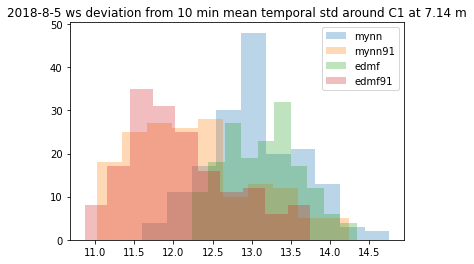

statistically INDIFFERENT distributions:
('mynn', 'edmf')

correlated distributions:


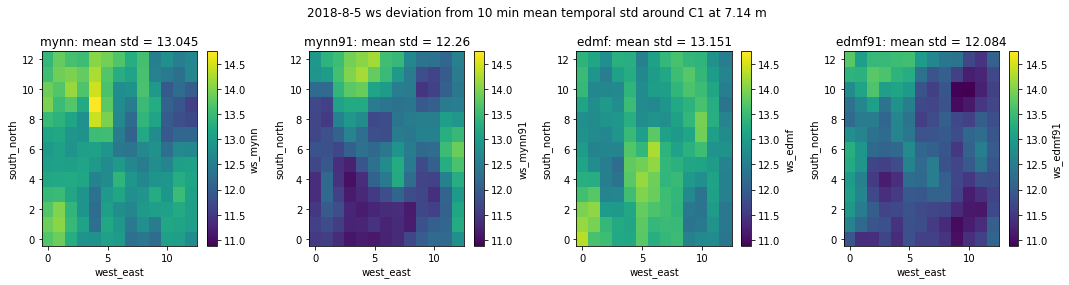


40.27 m
mynn mean: 10.024 std: 0.507
mynn91 mean: 9.258 std: 0.335
edmf mean: 10.276 std: 0.465
edmf91 mean: 9.473 std: 0.289


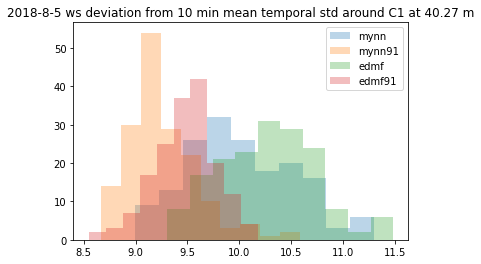

statistically INDIFFERENT distributions:

correlated distributions:


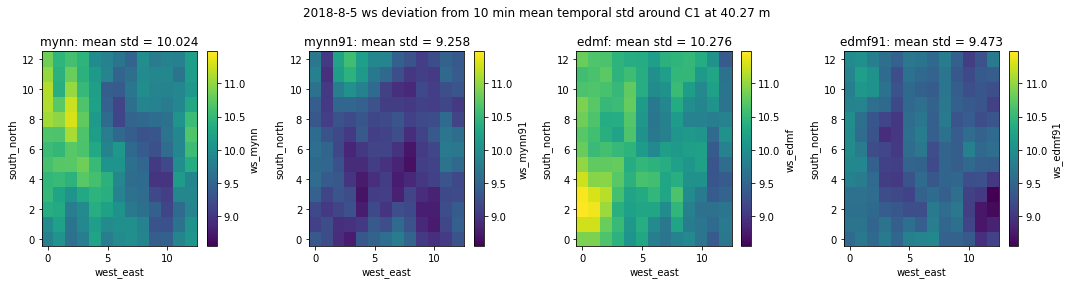


78.01 m
mynn mean: 8.659 std: 0.379
mynn91 mean: 8.206 std: 0.304
edmf mean: 8.939 std: 0.463
edmf91 mean: 8.346 std: 0.278


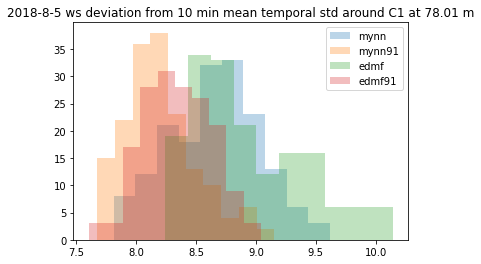

statistically INDIFFERENT distributions:

correlated distributions:


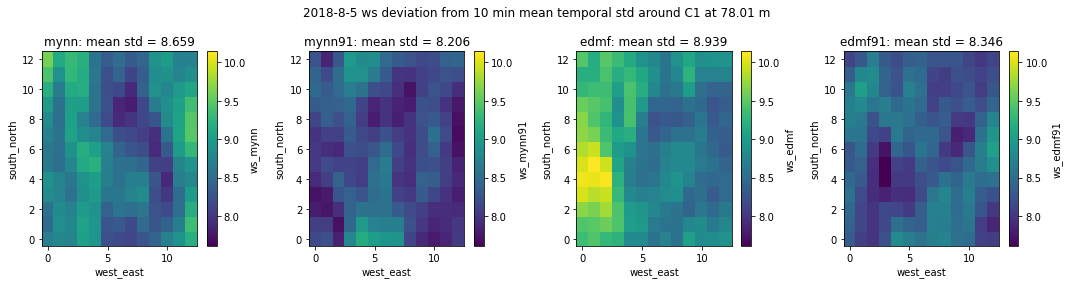


163.19 m
mynn mean: 8.113 std: 0.281
mynn91 mean: 7.636 std: 0.268
edmf mean: 8.205 std: 0.402
edmf91 mean: 7.449 std: 0.219


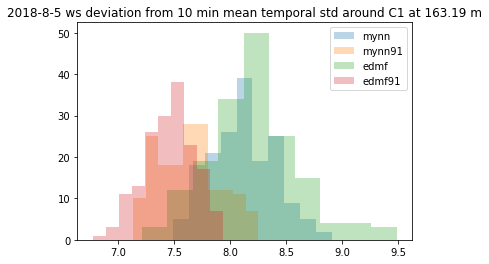

statistically INDIFFERENT distributions:

correlated distributions:


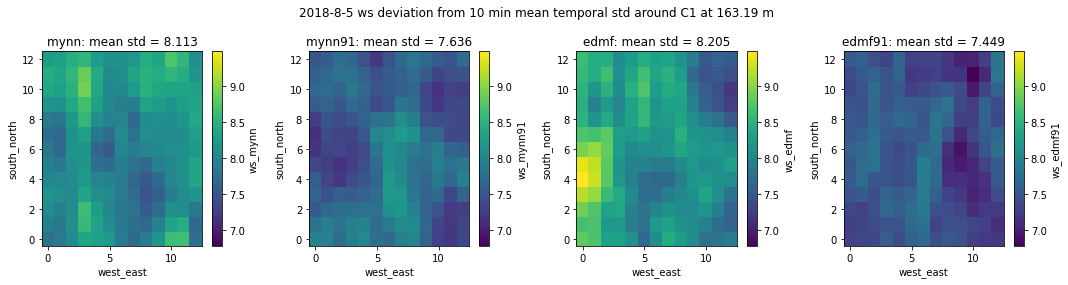


391.27 m
mynn mean: 7.94 std: 0.278
mynn91 mean: 7.102 std: 0.291
edmf mean: 7.862 std: 0.297
edmf91 mean: 7.657 std: 0.366


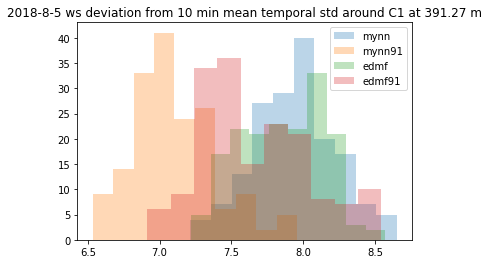

statistically INDIFFERENT distributions:

correlated distributions:


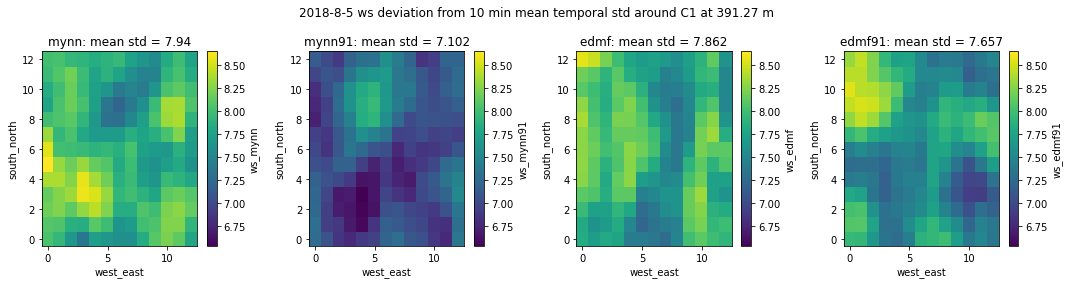

In [110]:
da_list = [ds_0805['ws_mynn'], ds_0805['ws_mynn91'], ds_0805['ws_edmf'], ds_0805['ws_edmf91']]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = ds_0805_hgt['hgt_mynn']

plot_dev_std_hist(da_list, run_list, hgt_arr, 'ws', 10)

7.14 m
mynn mean: 14.069 std: 0.581
mynn91 mean: 12.729 std: 0.731
edmf mean: 13.841 std: 0.53
edmf91 mean: 12.614 std: 0.665


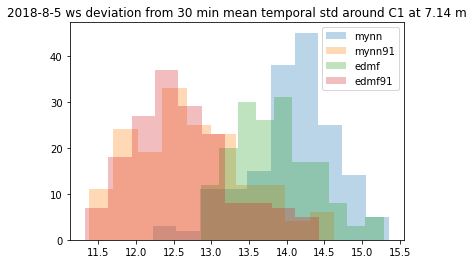

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:


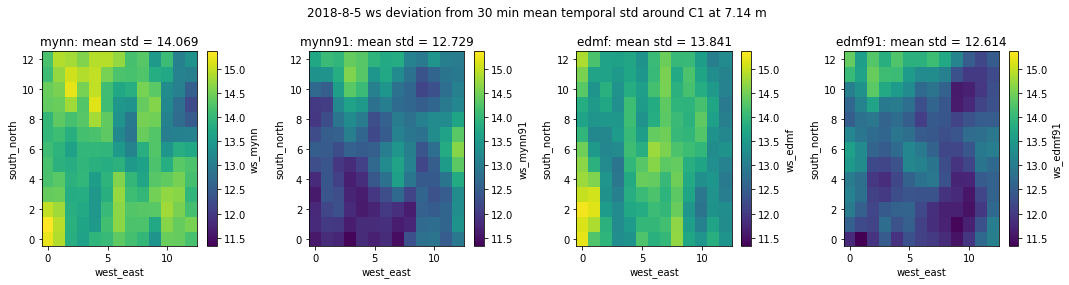


40.27 m
mynn mean: 10.961 std: 0.388
mynn91 mean: 9.557 std: 0.346
edmf mean: 10.88 std: 0.403
edmf91 mean: 10.07 std: 0.229


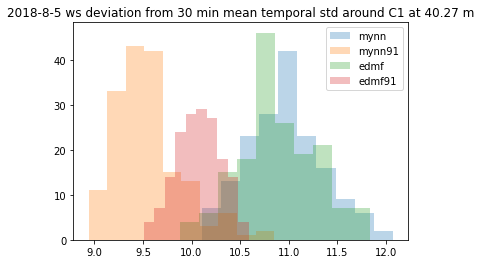

statistically INDIFFERENT distributions:
('mynn', 'edmf')

correlated distributions:


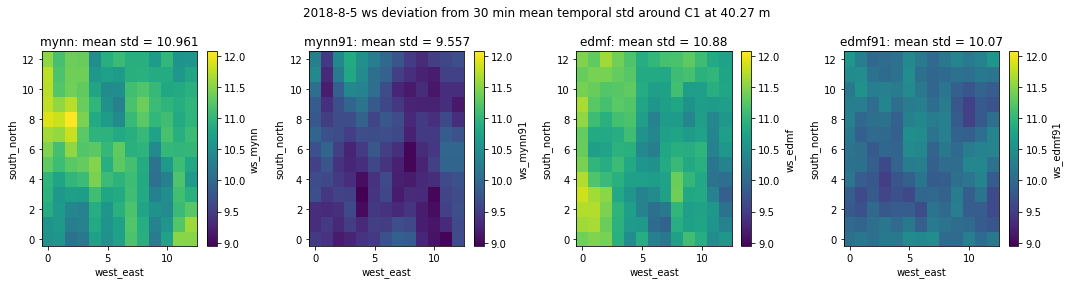


78.01 m
mynn mean: 9.54 std: 0.304
mynn91 mean: 8.493 std: 0.287
edmf mean: 9.453 std: 0.396
edmf91 mean: 8.903 std: 0.298


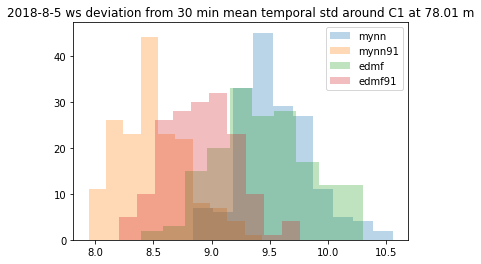

statistically INDIFFERENT distributions:

correlated distributions:


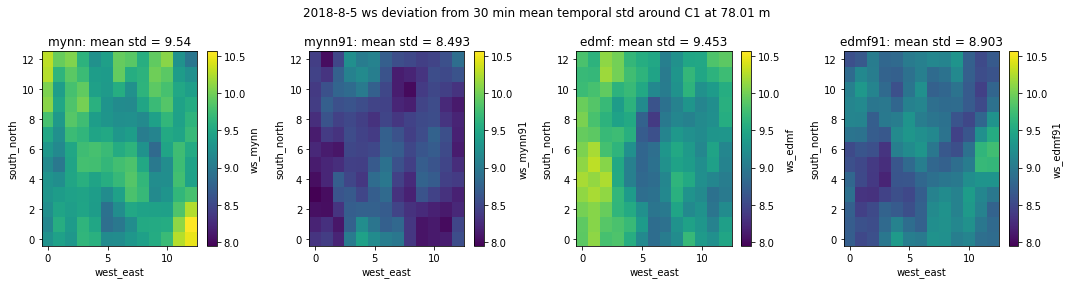


163.19 m
mynn mean: 8.848 std: 0.36
mynn91 mean: 7.98 std: 0.269
edmf mean: 8.704 std: 0.374
edmf91 mean: 7.959 std: 0.288


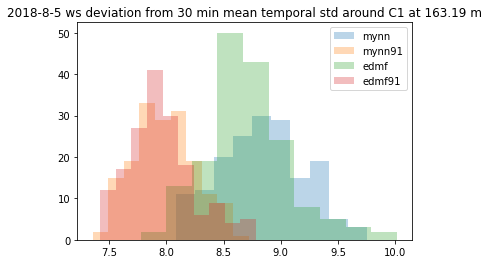

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:


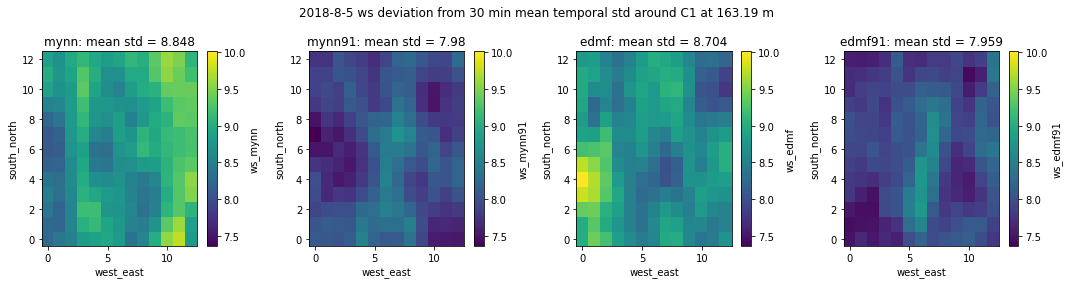


391.27 m
mynn mean: 8.644 std: 0.317
mynn91 mean: 7.549 std: 0.25
edmf mean: 8.791 std: 0.249
edmf91 mean: 8.223 std: 0.358


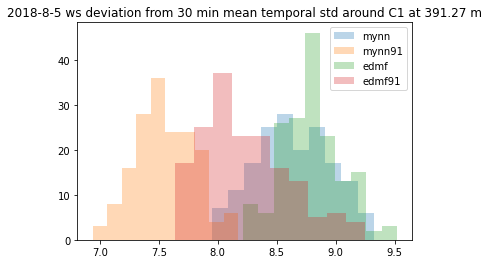

statistically INDIFFERENT distributions:

correlated distributions:


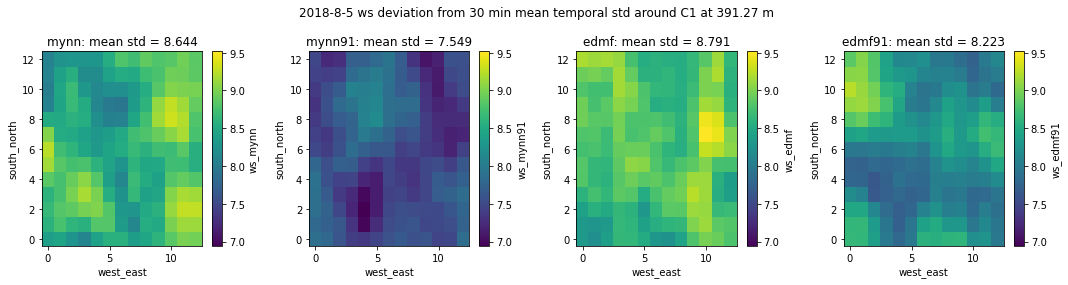

In [111]:
da_list = [ds_0805['ws_mynn'], ds_0805['ws_mynn91'], ds_0805['ws_edmf'], ds_0805['ws_edmf91']]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = ds_0805_hgt['hgt_mynn']

plot_dev_std_hist(da_list, run_list, hgt_arr, 'ws', 30)

7.14 m
mynn mean: 0.072 std: 0.004
mynn91 mean: 0.078 std: 0.009
edmf mean: 0.072 std: 0.004
edmf91 mean: 0.075 std: 0.007


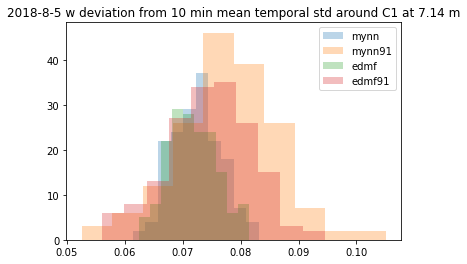

statistically INDIFFERENT distributions:
('mynn', 'edmf')

correlated distributions:
('mynn91', 'edmf91') 0.7175465550396809


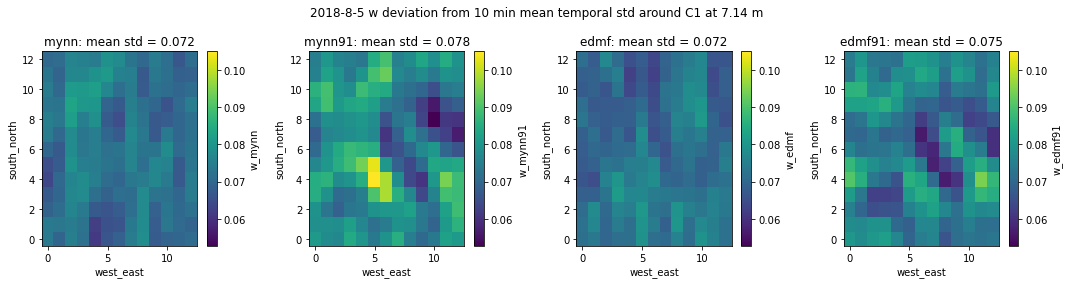


40.27 m
mynn mean: 0.363 std: 0.018
mynn91 mean: 0.36 std: 0.019
edmf mean: 0.361 std: 0.017
edmf91 mean: 0.342 std: 0.016


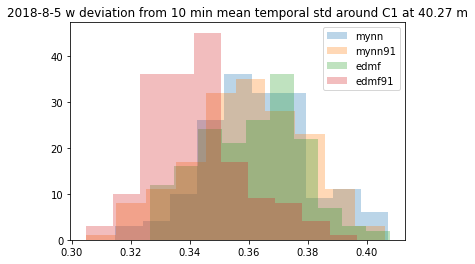

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')

correlated distributions:


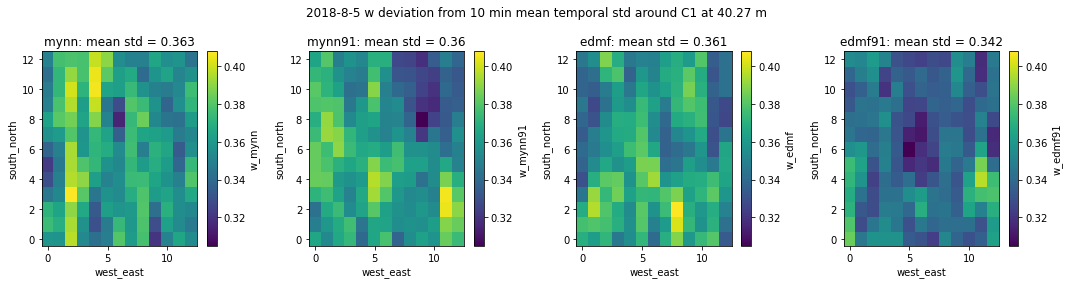


78.01 m
mynn mean: 0.542 std: 0.024
mynn91 mean: 0.535 std: 0.027
edmf mean: 0.541 std: 0.022
edmf91 mean: 0.513 std: 0.018


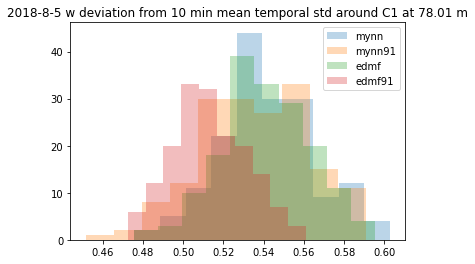

statistically INDIFFERENT distributions:
('mynn', 'edmf')

correlated distributions:


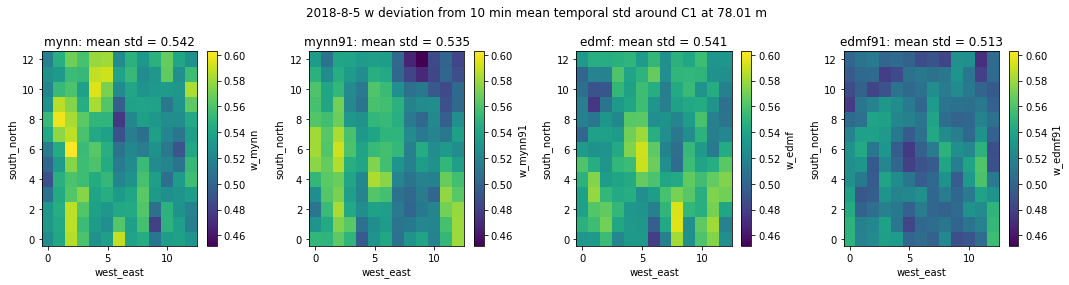


163.19 m
mynn mean: 0.714 std: 0.034
mynn91 mean: 0.693 std: 0.027
edmf mean: 0.705 std: 0.026
edmf91 mean: 0.689 std: 0.022


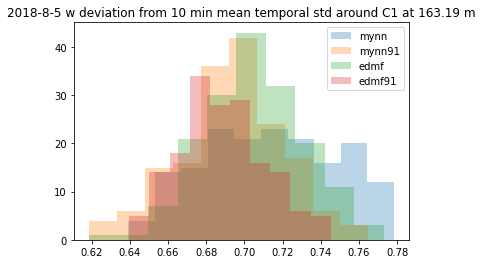

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:


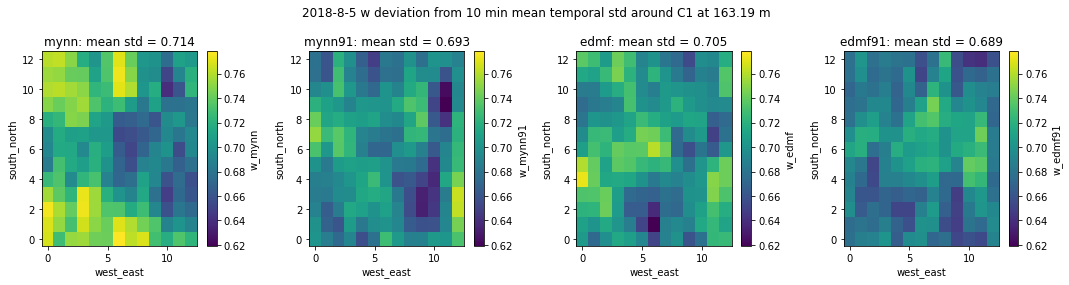


391.27 m
mynn mean: 0.836 std: 0.041
mynn91 mean: 0.779 std: 0.03
edmf mean: 0.803 std: 0.027
edmf91 mean: 0.803 std: 0.036


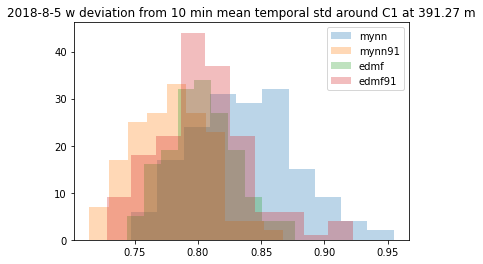

statistically INDIFFERENT distributions:
('edmf', 'edmf91')

correlated distributions:


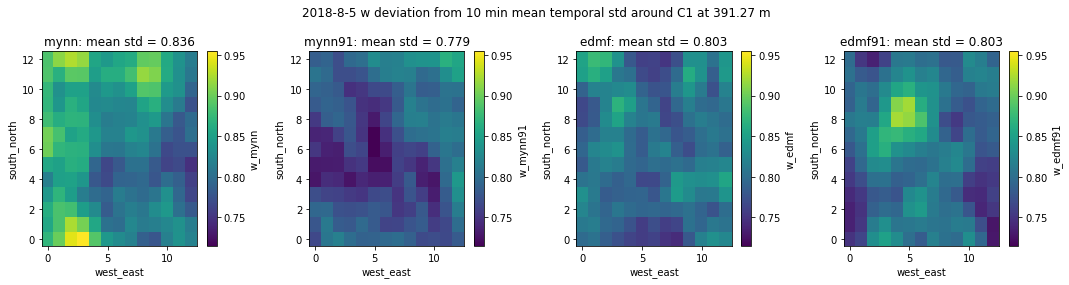

In [114]:
da_list = [ds_0805['w_mynn'], ds_0805['w_mynn91'], ds_0805['w_edmf'], ds_0805['w_edmf91']]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = ds_0805_hgt['hgt_mynn']

plot_dev_std_hist(da_list, run_list, hgt_arr, 'w', 10)

7.13 m
mynn mean: 0.062 std: 0.004
mynn91 mean: 0.067 std: 0.007
edmf mean: 0.061 std: 0.004
edmf91 mean: 0.068 std: 0.007


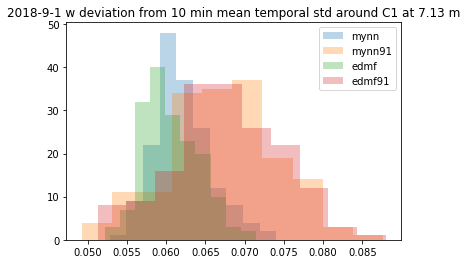

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:
('mynn91', 'edmf91') 0.7670608557957798


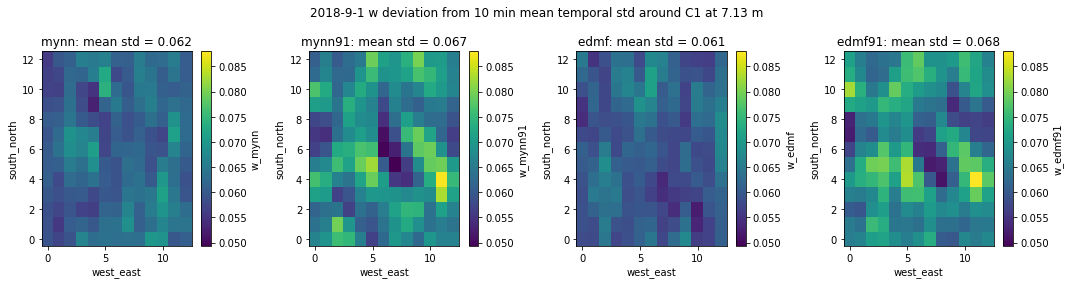


40.2 m
mynn mean: 0.32 std: 0.016
mynn91 mean: 0.314 std: 0.019
edmf mean: 0.309 std: 0.017
edmf91 mean: 0.315 std: 0.017


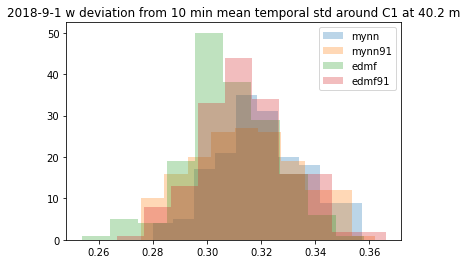

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:


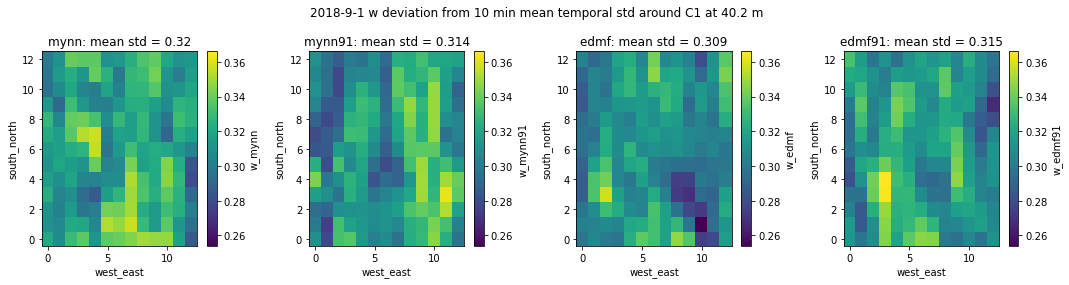


77.89 m
mynn mean: 0.484 std: 0.021
mynn91 mean: 0.476 std: 0.027
edmf mean: 0.464 std: 0.023
edmf91 mean: 0.474 std: 0.022


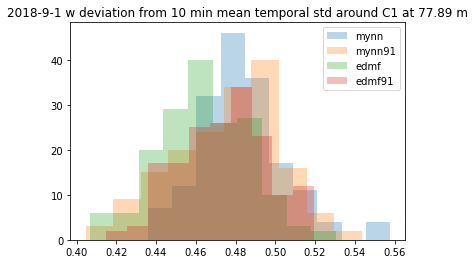

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:


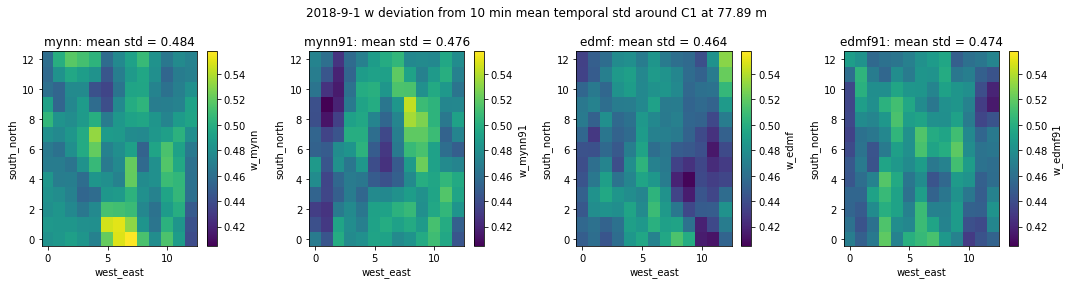


162.9 m
mynn mean: 0.627 std: 0.03
mynn91 mean: 0.637 std: 0.028
edmf mean: 0.616 std: 0.021
edmf91 mean: 0.633 std: 0.03


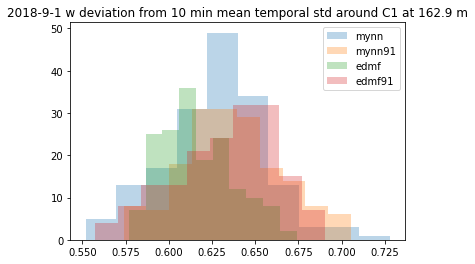

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:


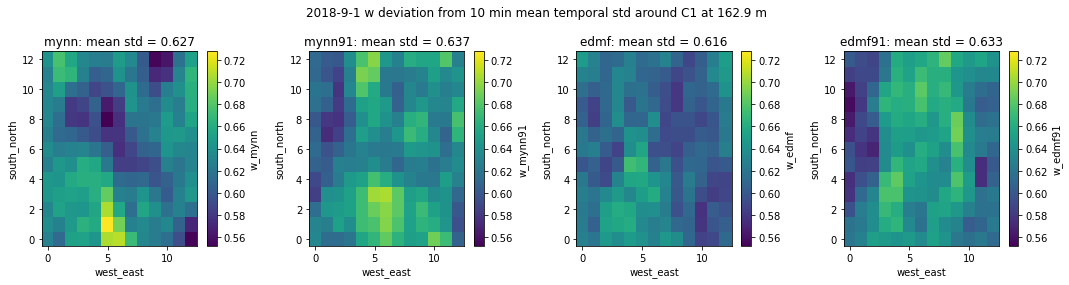


390.43 m
mynn mean: 0.69 std: 0.029
mynn91 mean: 0.71 std: 0.028
edmf mean: 0.7 std: 0.024
edmf91 mean: 0.724 std: 0.026


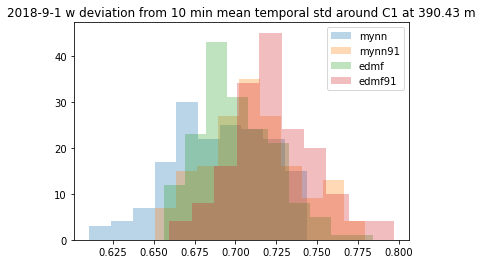

statistically INDIFFERENT distributions:

correlated distributions:


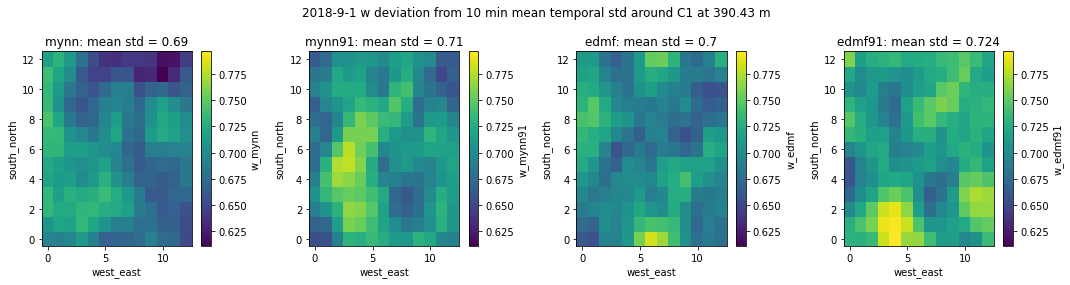

In [120]:
da_list = [ds_0901['w_mynn'], ds_0901['w_mynn91'], ds_0901['w_edmf'], ds_0901['w_edmf91']]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = ds_0901_hgt['hgt_mynn']

plot_dev_std_hist(da_list, run_list, hgt_arr, 'w', 10)

2.38 m
mynn mean: 0.026 std: 0.002
mynn91 mean: 0.036 std: 0.009
edmf mean: 0.026 std: 0.002
edmf91 mean: 0.034 std: 0.007


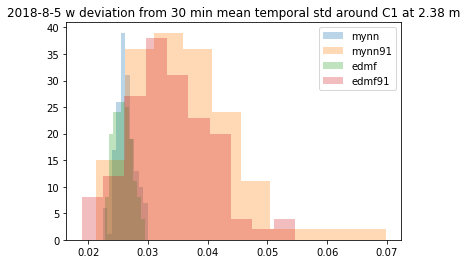

statistically INDIFFERENT distributions:

correlated distributions:
('mynn91', 'edmf91') 0.9411747135455586


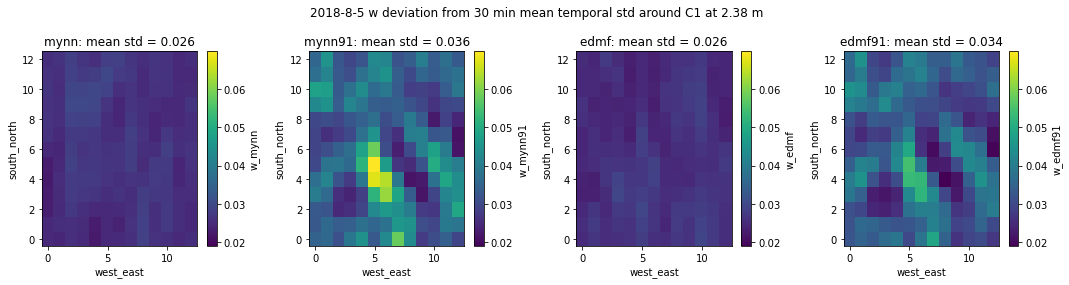


7.14 m
mynn mean: 0.077 std: 0.004
mynn91 mean: 0.083 std: 0.009
edmf mean: 0.076 std: 0.004
edmf91 mean: 0.079 std: 0.008


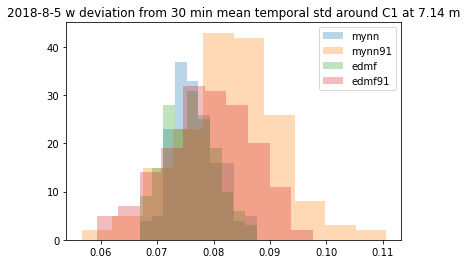

statistically INDIFFERENT distributions:
('mynn', 'edmf')

correlated distributions:
('mynn91', 'edmf91') 0.7759947016073513


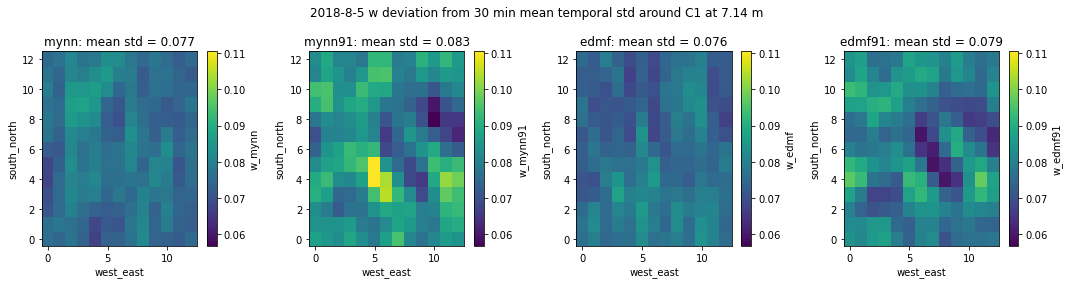


11.9 m
mynn mean: 0.129 std: 0.007
mynn91 mean: 0.133 std: 0.011
edmf mean: 0.128 std: 0.007
edmf91 mean: 0.127 std: 0.01


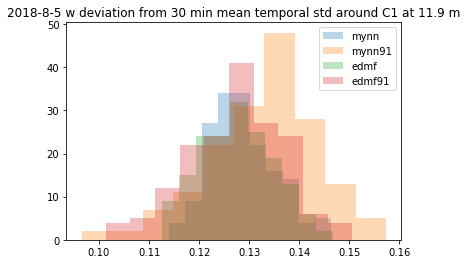

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn', 'edmf91')
('edmf', 'edmf91')

correlated distributions:
('mynn91', 'edmf91') 0.6352029469266683


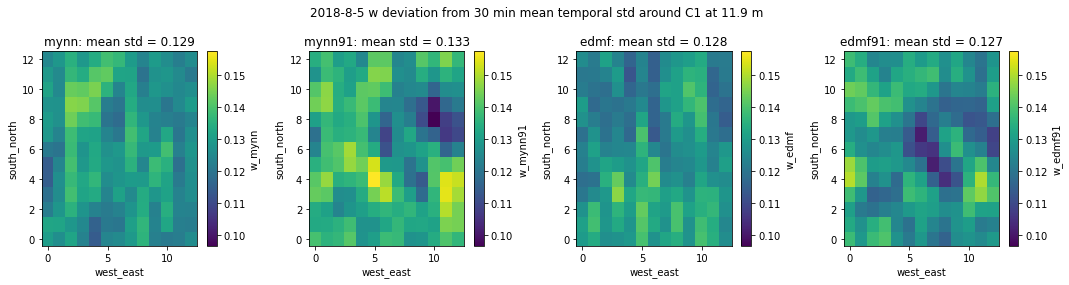


16.62 m
mynn mean: 0.18 std: 0.009
mynn91 mean: 0.182 std: 0.013
edmf mean: 0.178 std: 0.01
edmf91 mean: 0.175 std: 0.011


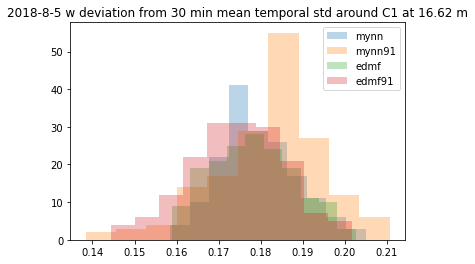

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')

correlated distributions:


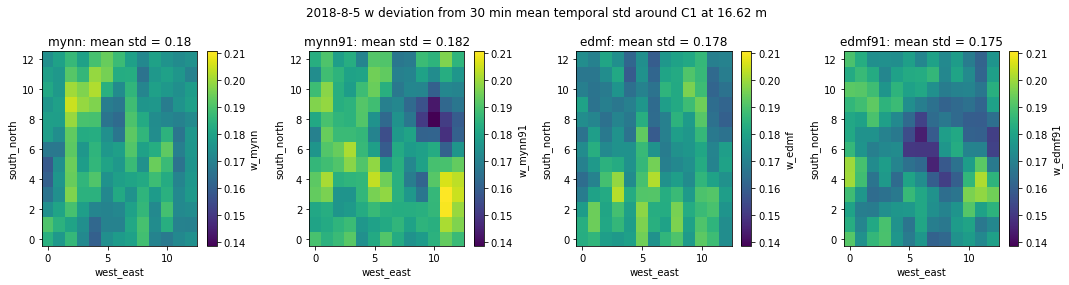


21.33 m
mynn mean: 0.228 std: 0.011
mynn91 mean: 0.228 std: 0.014
edmf mean: 0.226 std: 0.012
edmf91 mean: 0.219 std: 0.013


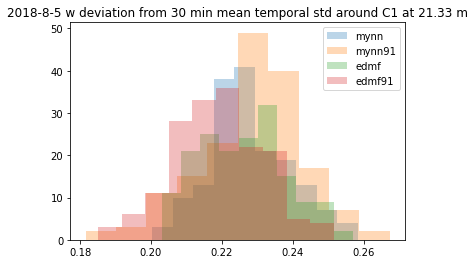

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')

correlated distributions:


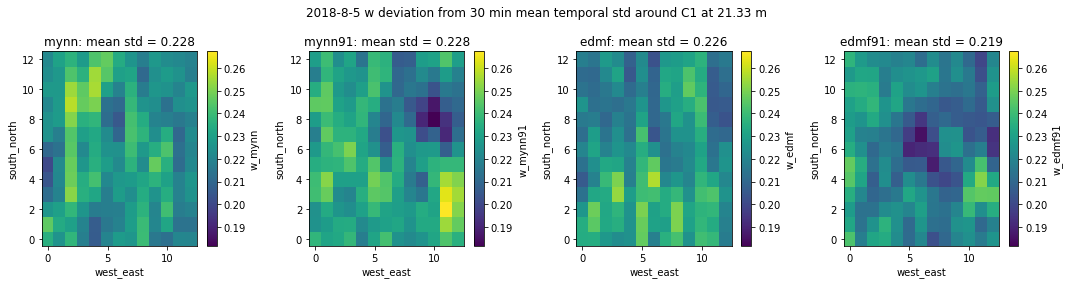


26.09 m
mynn mean: 0.273 std: 0.013
mynn91 mean: 0.272 std: 0.016
edmf mean: 0.271 std: 0.014
edmf91 mean: 0.261 std: 0.014


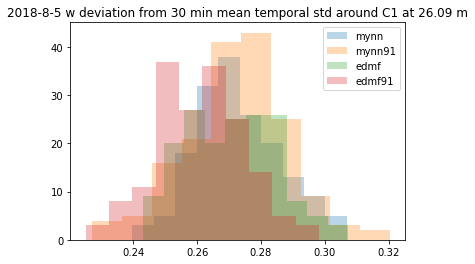

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')

correlated distributions:


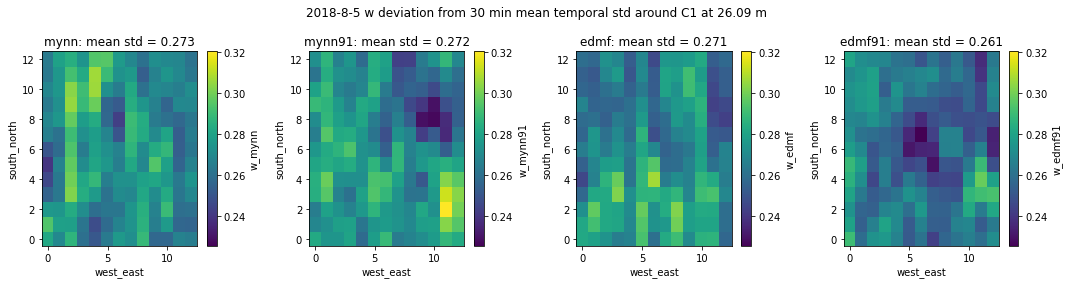


30.84 m
mynn mean: 0.314 std: 0.015
mynn91 mean: 0.313 std: 0.017
edmf mean: 0.312 std: 0.016
edmf91 mean: 0.299 std: 0.014


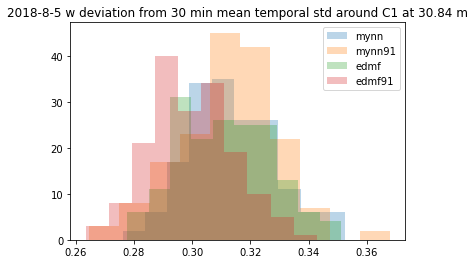

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')

correlated distributions:


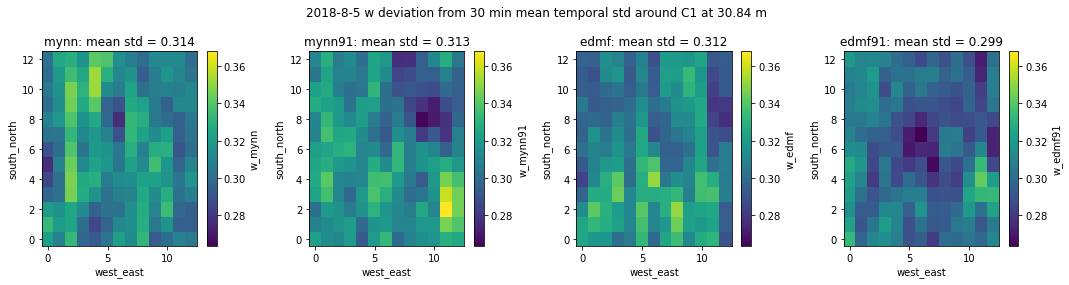


35.56 m
mynn mean: 0.351 std: 0.016
mynn91 mean: 0.349 std: 0.018
edmf mean: 0.349 std: 0.018
edmf91 mean: 0.334 std: 0.015


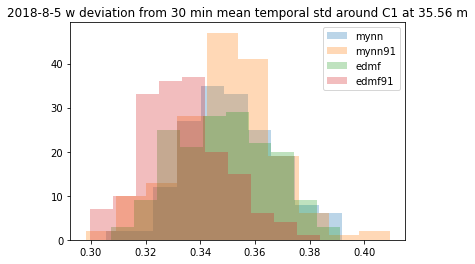

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')

correlated distributions:


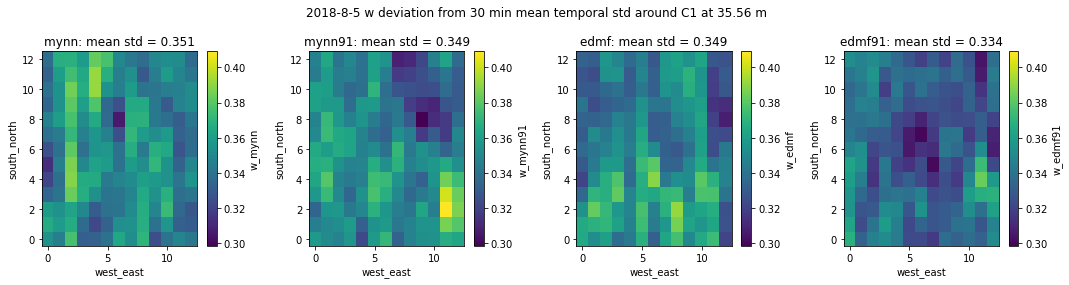


40.27 m
mynn mean: 0.385 std: 0.017
mynn91 mean: 0.382 std: 0.019
edmf mean: 0.383 std: 0.019
edmf91 mean: 0.366 std: 0.016


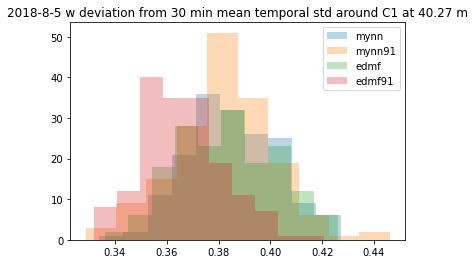

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf')
('mynn91', 'edmf')

correlated distributions:


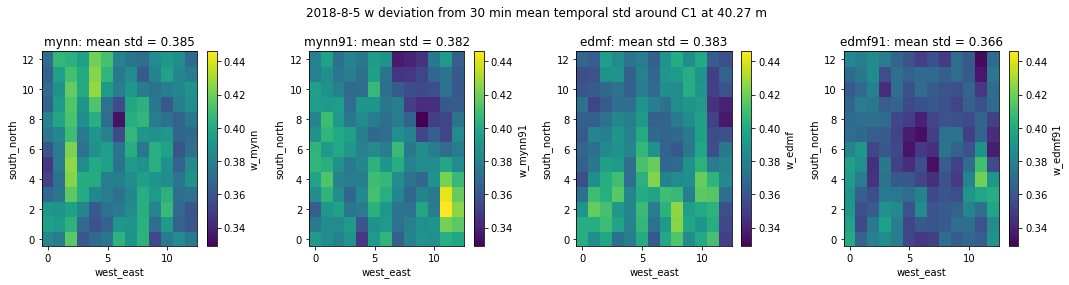


44.98 m
mynn mean: 0.417 std: 0.018
mynn91 mean: 0.412 std: 0.02
edmf mean: 0.415 std: 0.02
edmf91 mean: 0.395 std: 0.016


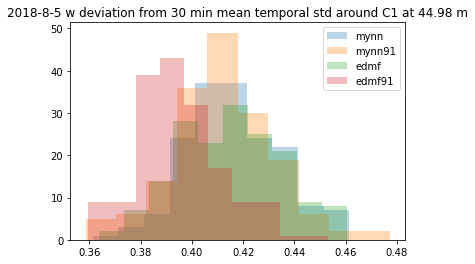

statistically INDIFFERENT distributions:
('mynn', 'edmf')
('mynn91', 'edmf')

correlated distributions:


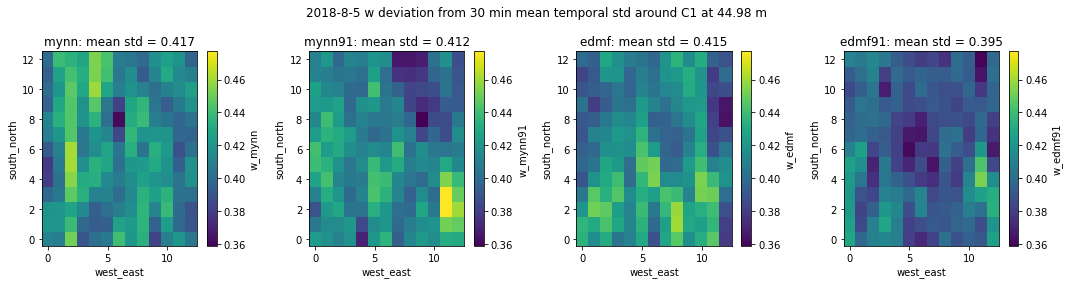

In [159]:
da_list = [ds_0805['w_mynn'], ds_0805['w_mynn91'], ds_0805['w_edmf'], ds_0805['w_edmf91']]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = ds_0805_hgt['hgt_mynn']

plot_dev_std_hist(da_list, run_list, hgt_arr, 'w', 30)

2.38 m
mynn mean: 0.023 std: 0.001
mynn91 mean: 0.031 std: 0.007
edmf mean: 0.022 std: 0.001
edmf91 mean: 0.031 std: 0.007


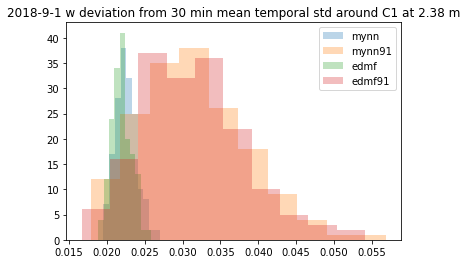

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:
('mynn91', 'edmf91') 0.9553671605850704


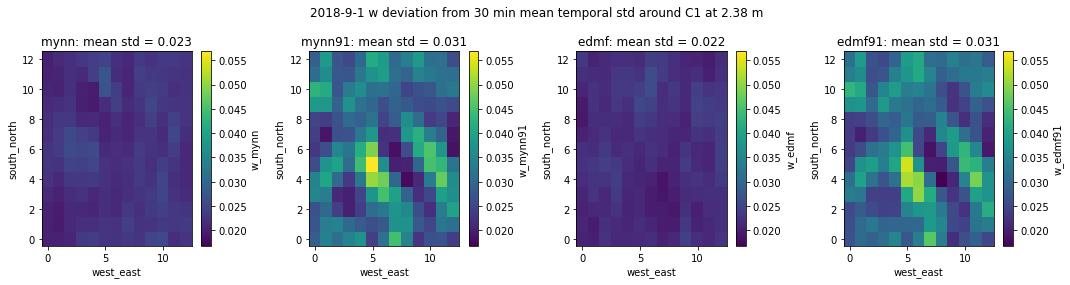


7.13 m
mynn mean: 0.066 std: 0.004
mynn91 mean: 0.072 std: 0.007
edmf mean: 0.064 std: 0.004
edmf91 mean: 0.072 std: 0.007


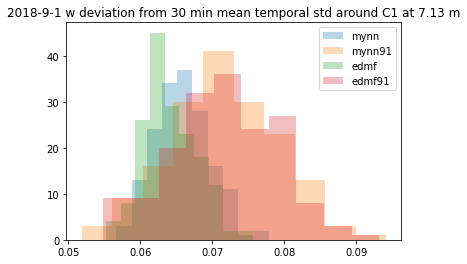

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:
('mynn91', 'edmf91') 0.7743557127023933


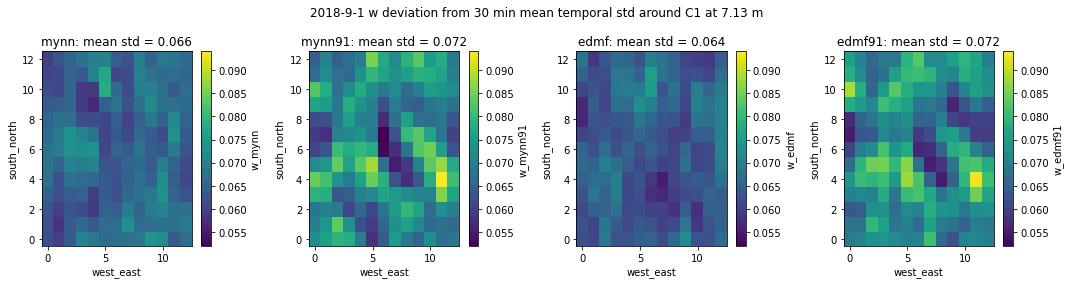


11.88 m
mynn mean: 0.111 std: 0.006
mynn91 mean: 0.115 std: 0.009
edmf mean: 0.108 std: 0.006
edmf91 mean: 0.115 std: 0.009


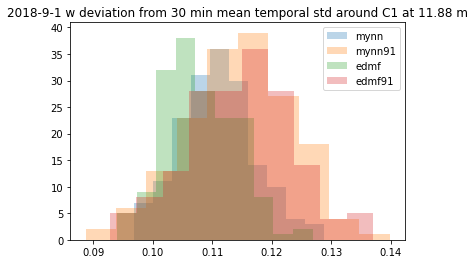

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:


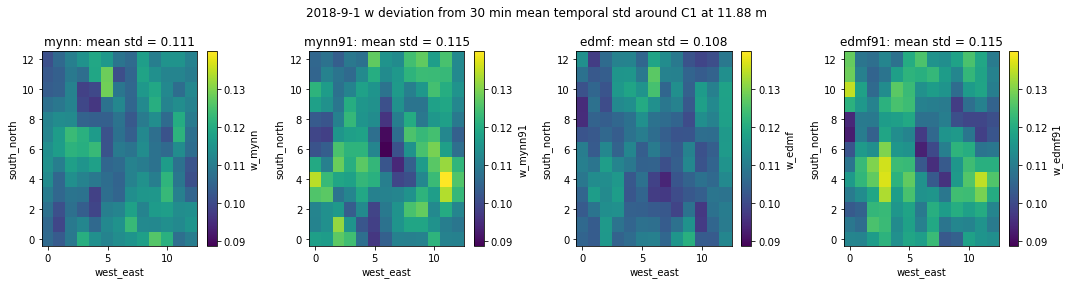


16.59 m
mynn mean: 0.155 std: 0.008
mynn91 mean: 0.157 std: 0.011
edmf mean: 0.151 std: 0.008
edmf91 mean: 0.157 std: 0.011


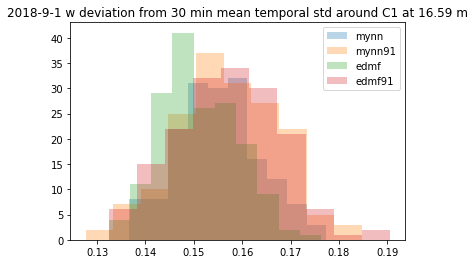

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf91')
('mynn91', 'edmf91')

correlated distributions:


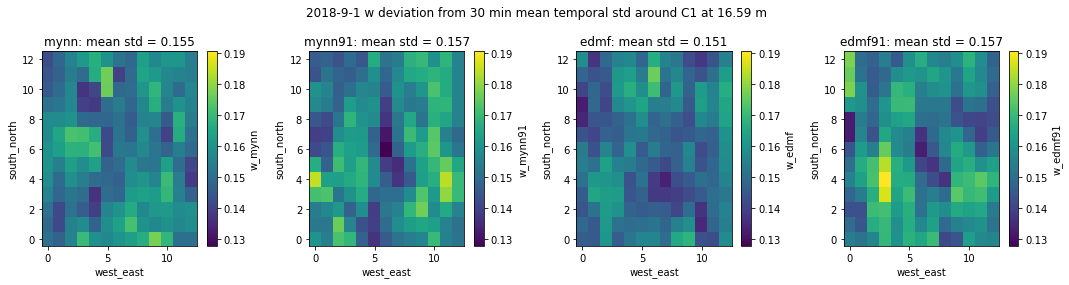


21.29 m
mynn mean: 0.198 std: 0.011
mynn91 mean: 0.198 std: 0.013
edmf mean: 0.192 std: 0.01
edmf91 mean: 0.198 std: 0.013


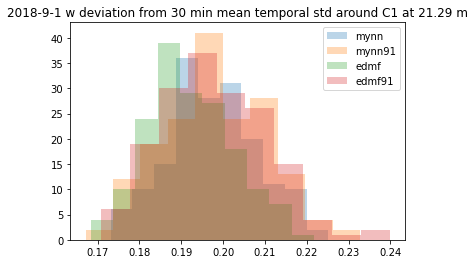

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf91')
('mynn91', 'edmf91')

correlated distributions:


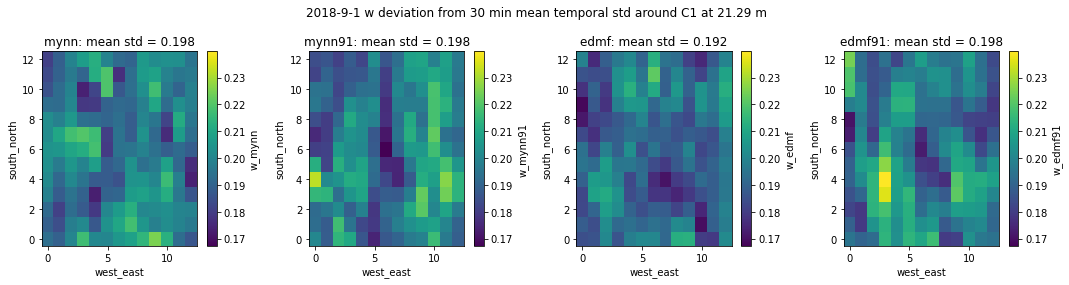


26.04 m
mynn mean: 0.238 std: 0.013
mynn91 mean: 0.236 std: 0.015
edmf mean: 0.23 std: 0.012
edmf91 mean: 0.236 std: 0.014


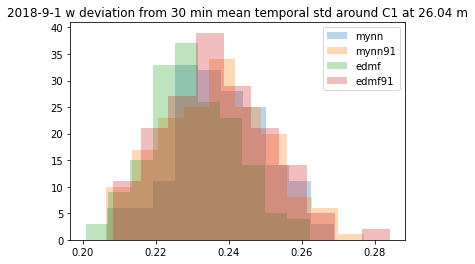

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf91')
('mynn91', 'edmf91')

correlated distributions:


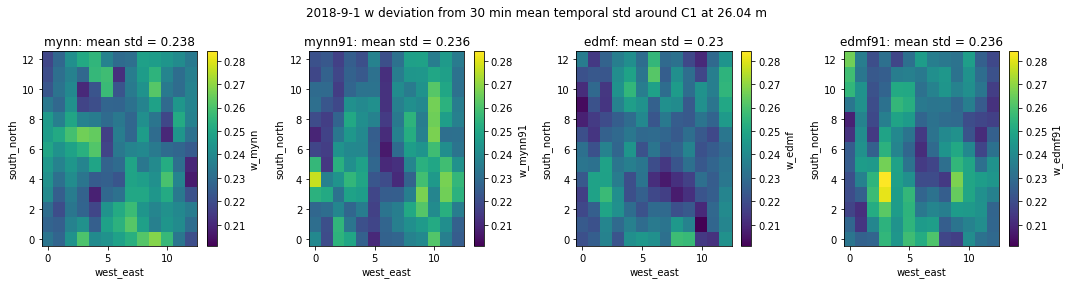


30.79 m
mynn mean: 0.275 std: 0.014
mynn91 mean: 0.272 std: 0.016
edmf mean: 0.266 std: 0.014
edmf91 mean: 0.272 std: 0.015


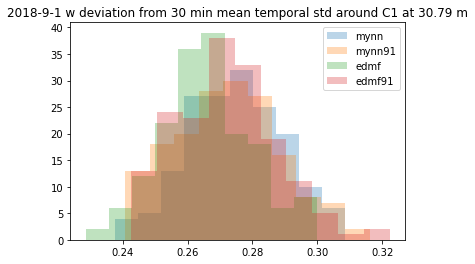

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn', 'edmf91')
('mynn91', 'edmf91')

correlated distributions:


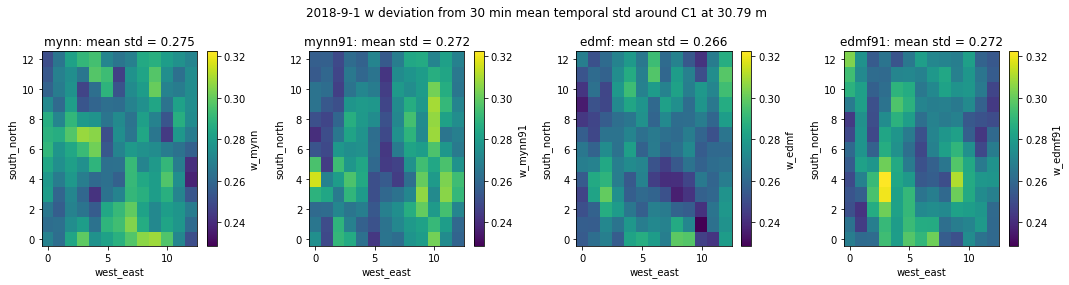


35.49 m
mynn mean: 0.309 std: 0.016
mynn91 mean: 0.305 std: 0.018
edmf mean: 0.298 std: 0.015
edmf91 mean: 0.304 std: 0.016


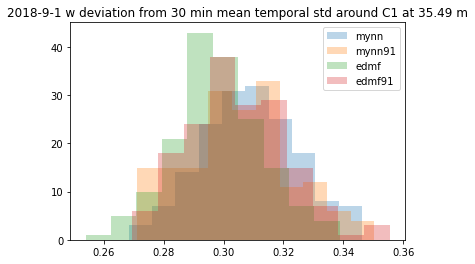

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn91', 'edmf91')

correlated distributions:


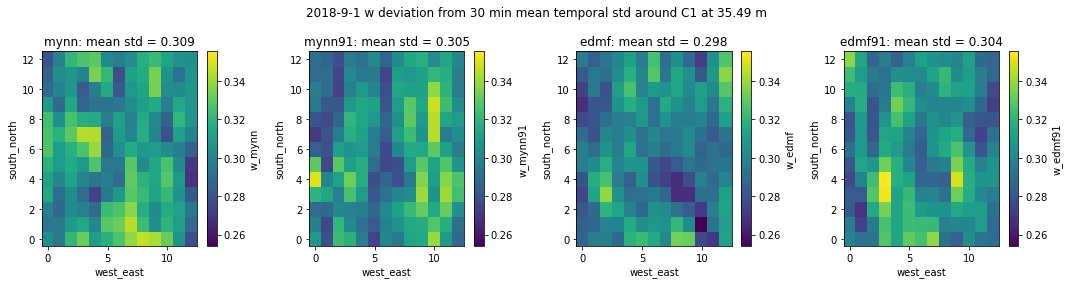


40.2 m
mynn mean: 0.34 std: 0.017
mynn91 mean: 0.335 std: 0.019
edmf mean: 0.328 std: 0.016
edmf91 mean: 0.334 std: 0.017


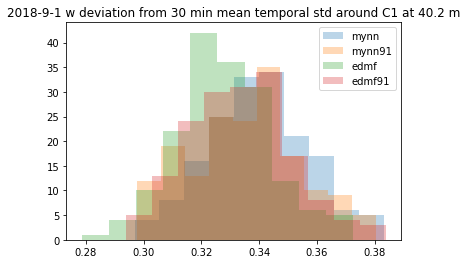

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:


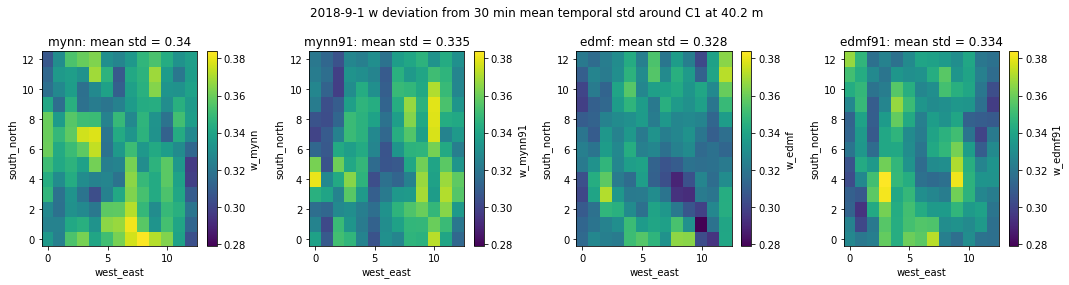


44.91 m
mynn mean: 0.368 std: 0.019
mynn91 mean: 0.363 std: 0.02
edmf mean: 0.355 std: 0.018
edmf91 mean: 0.361 std: 0.018


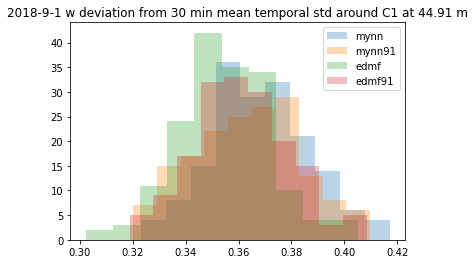

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:


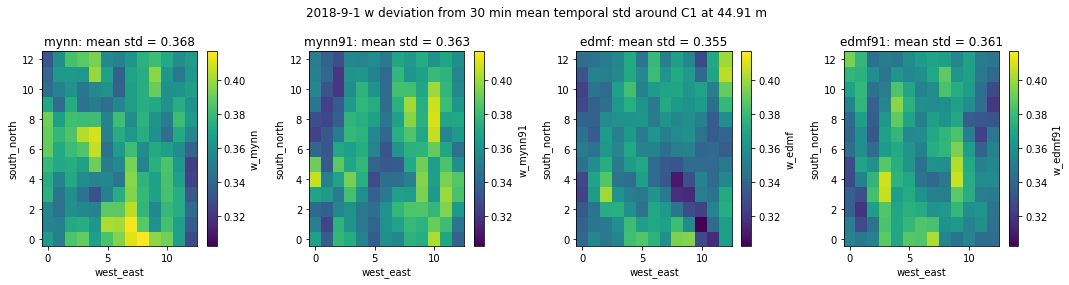

In [160]:
da_list = [ds_0901['w_mynn'], ds_0901['w_mynn91'], ds_0901['w_edmf'], ds_0901['w_edmf91']]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = ds_0901_hgt['hgt_mynn']

plot_dev_std_hist(da_list, run_list, hgt_arr, 'w', 30)

7.14 m
mynn mean: 18.794 std: 0.706
mynn91 mean: 17.089 std: 0.701
edmf mean: 18.471 std: 0.611
edmf91 mean: 16.906 std: 0.836


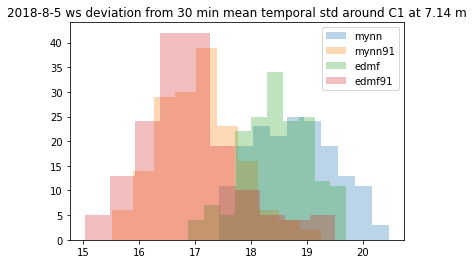

statistically INDIFFERENT distributions:

correlated distributions:


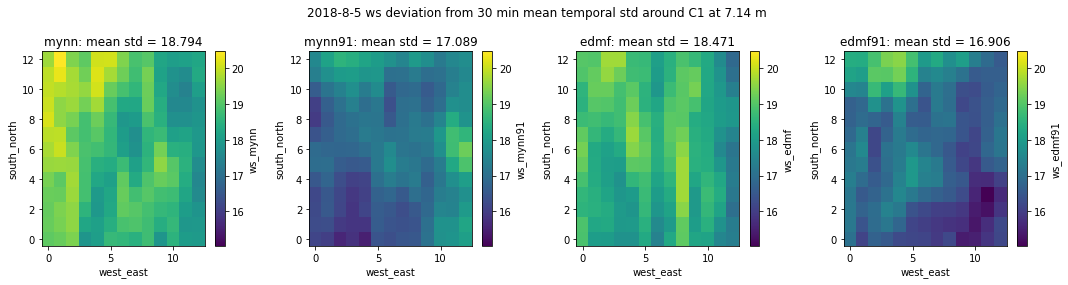


40.27 m
mynn mean: 14.218 std: 0.35
mynn91 mean: 12.798 std: 0.33
edmf mean: 14.311 std: 0.408
edmf91 mean: 13.486 std: 0.335


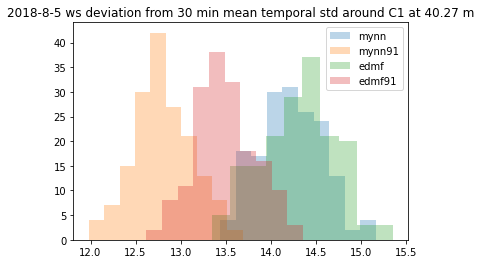

statistically INDIFFERENT distributions:

correlated distributions:


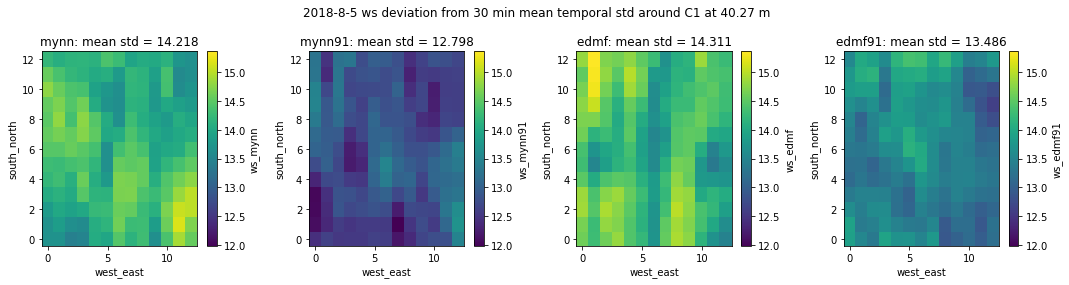


78.01 m
mynn mean: 11.946 std: 0.296
mynn91 mean: 11.074 std: 0.283
edmf mean: 12.083 std: 0.482
edmf91 mean: 11.514 std: 0.25


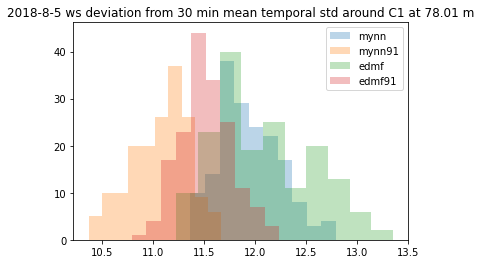

statistically INDIFFERENT distributions:

correlated distributions:


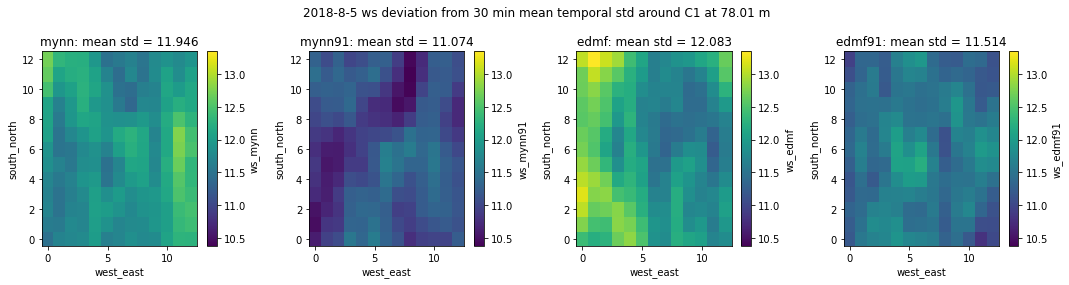


163.19 m
mynn mean: 10.799 std: 0.295
mynn91 mean: 10.124 std: 0.334
edmf mean: 11.058 std: 0.395
edmf91 mean: 10.072 std: 0.43


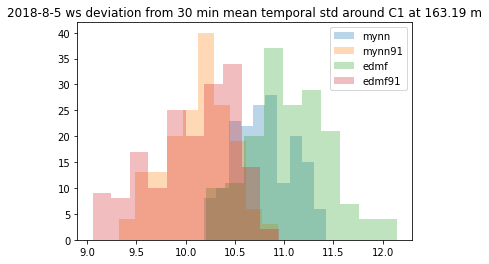

statistically INDIFFERENT distributions:
('mynn91', 'edmf91')

correlated distributions:


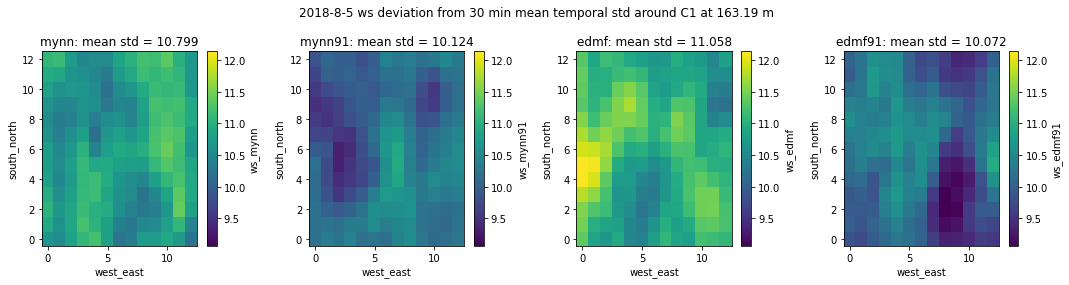


391.27 m
mynn mean: 10.964 std: 0.404
mynn91 mean: 9.783 std: 0.273
edmf mean: 11.183 std: 0.282
edmf91 mean: 10.367 std: 0.334


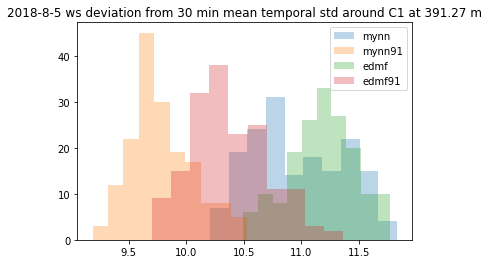

statistically INDIFFERENT distributions:

correlated distributions:


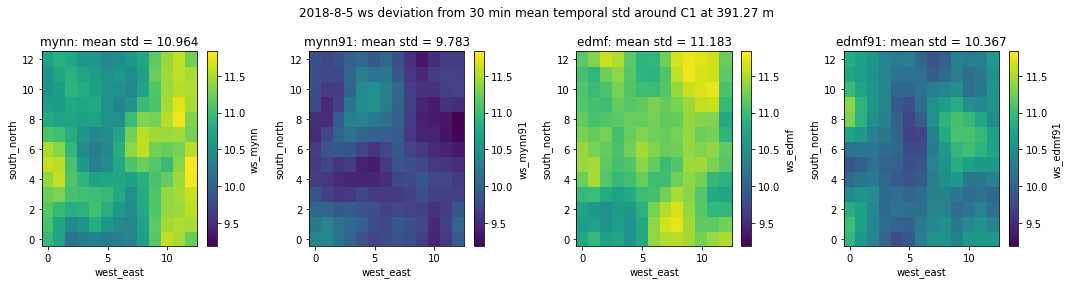

In [118]:
da_list = [ds_0805['ws_mynn'], ds_0805['ws_mynn91'], ds_0805['ws_edmf'], ds_0805['ws_edmf91']]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = ds_0805_hgt['hgt_mynn']

plot_dev_std_hist(da_list, run_list, hgt_arr, 'ws', 30, std_or_mean='mean')

7.14 m
mynn mean: 0.087 std: 0.004
mynn91 mean: 0.097 std: 0.012
edmf mean: 0.083 std: 0.004
edmf91 mean: 0.091 std: 0.011


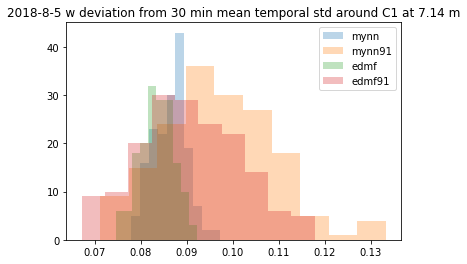

statistically INDIFFERENT distributions:

correlated distributions:
('mynn91', 'edmf91') 0.9145001038530421


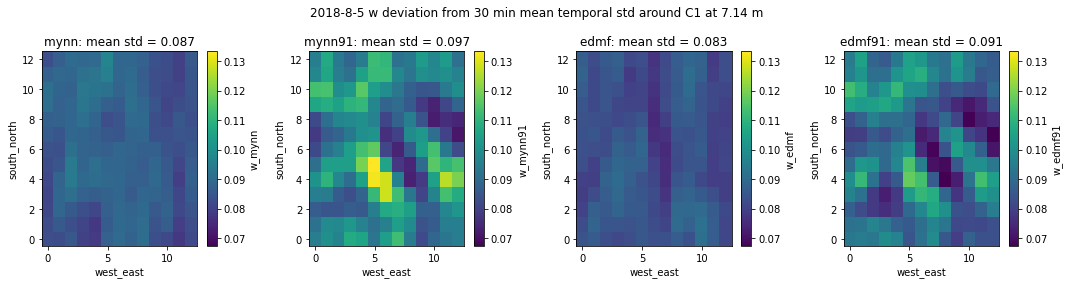


40.27 m
mynn mean: 0.448 std: 0.018
mynn91 mean: 0.447 std: 0.018
edmf mean: 0.444 std: 0.019
edmf91 mean: 0.42 std: 0.016


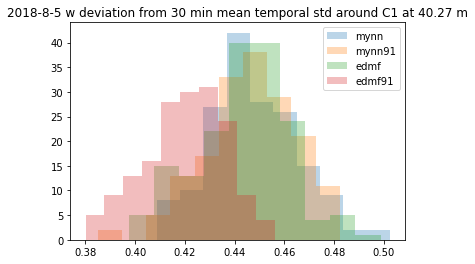

statistically INDIFFERENT distributions:
('mynn', 'mynn91')
('mynn91', 'edmf')

correlated distributions:


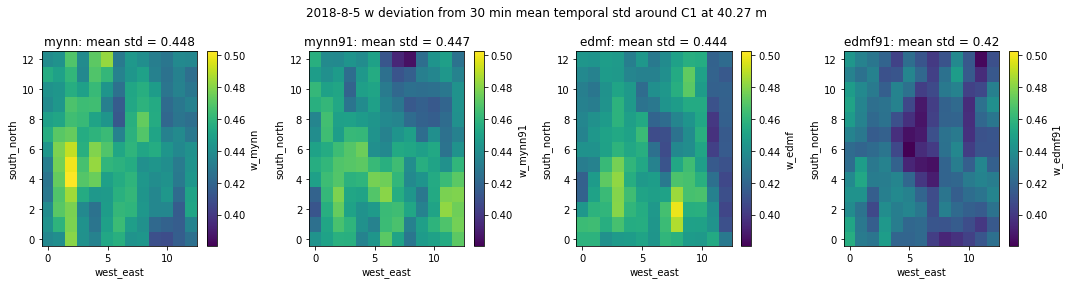


78.01 m
mynn mean: 0.696 std: 0.025
mynn91 mean: 0.695 std: 0.026
edmf mean: 0.707 std: 0.025
edmf91 mean: 0.658 std: 0.019


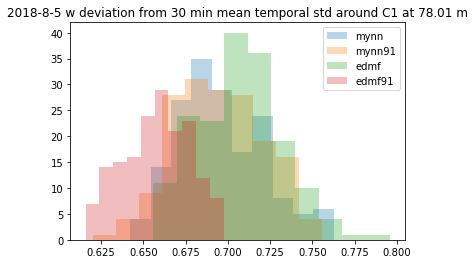

statistically INDIFFERENT distributions:
('mynn', 'mynn91')

correlated distributions:


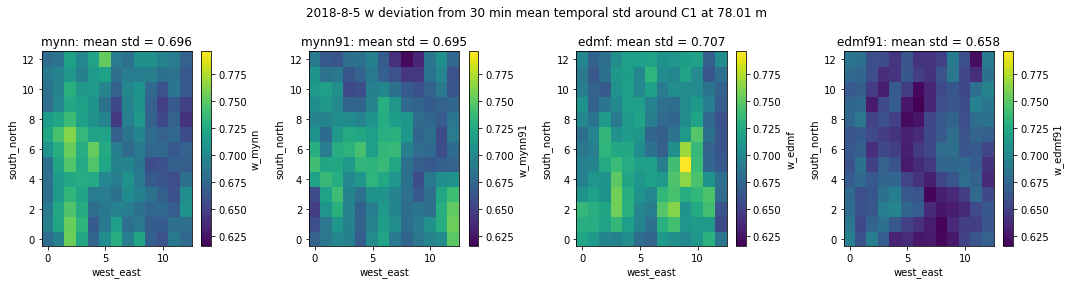


163.19 m
mynn mean: 0.965 std: 0.038
mynn91 mean: 0.924 std: 0.031
edmf mean: 0.983 std: 0.03
edmf91 mean: 0.916 std: 0.022


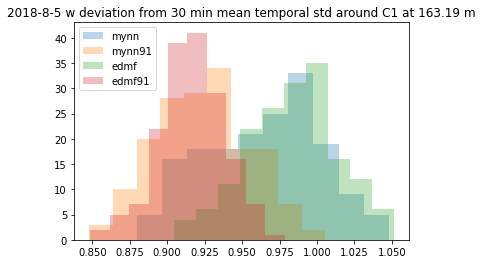

statistically INDIFFERENT distributions:

correlated distributions:


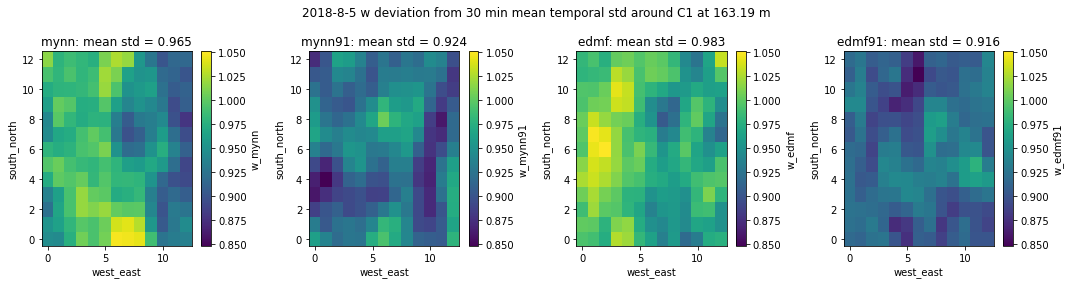


391.27 m
mynn mean: 1.136 std: 0.049
mynn91 mean: 1.026 std: 0.047
edmf mean: 1.146 std: 0.042
edmf91 mean: 1.066 std: 0.032


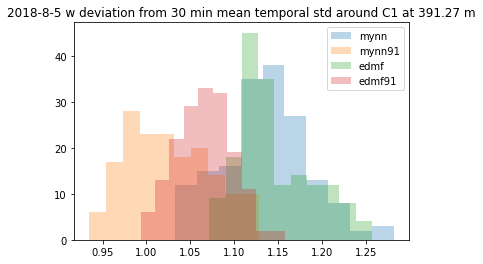

statistically INDIFFERENT distributions:

correlated distributions:


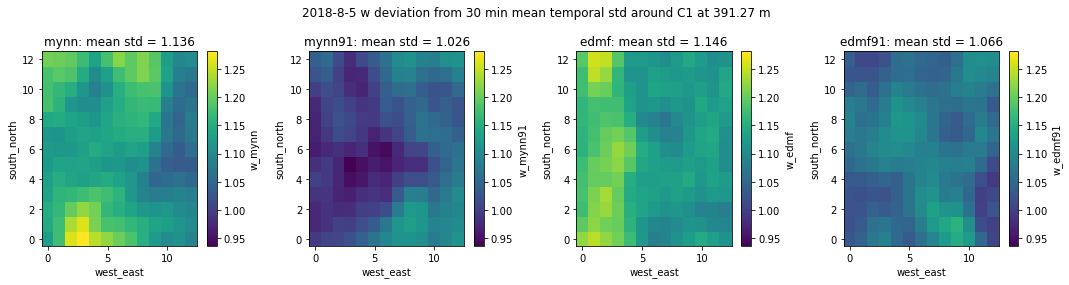

In [117]:
da_list = [ds_0805['w_mynn'], ds_0805['w_mynn91'], ds_0805['w_edmf'], ds_0805['w_edmf91']]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']
hgt_arr = ds_0805_hgt['hgt_mynn']

plot_dev_std_hist(da_list, run_list, hgt_arr, 'w', 30, std_or_mean='mean')

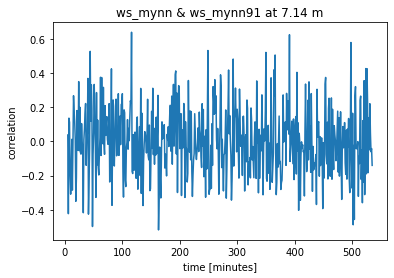

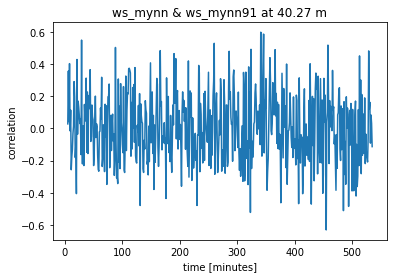

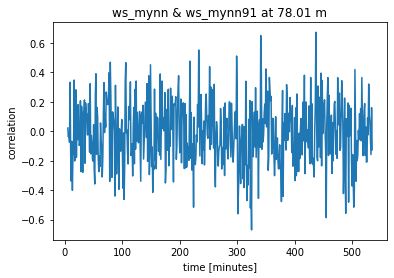

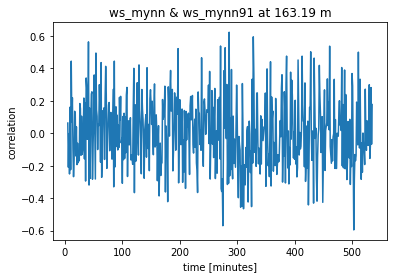

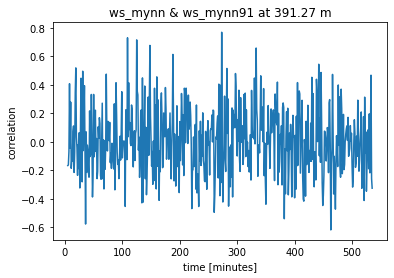

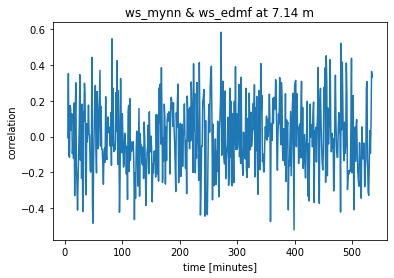

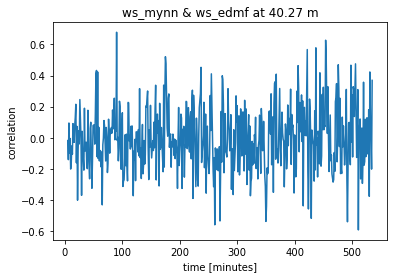

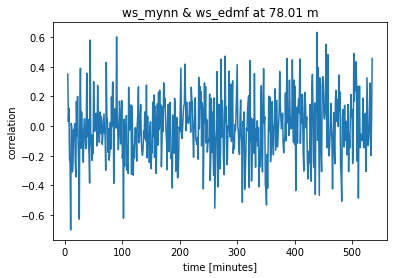

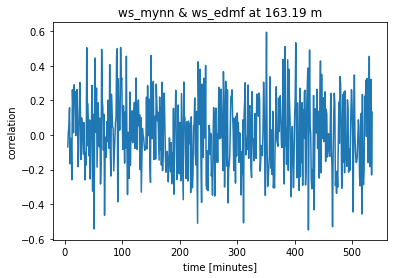

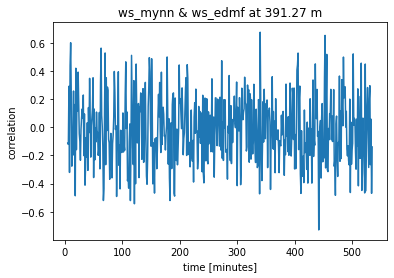

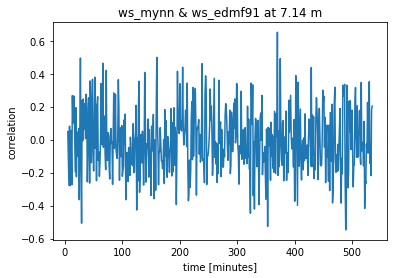

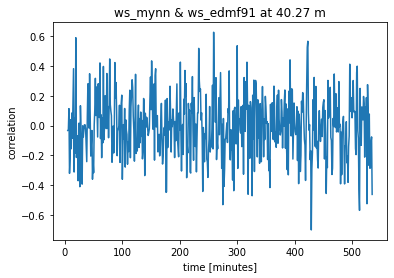

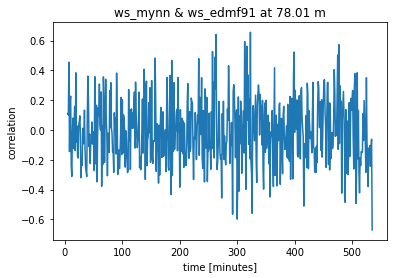

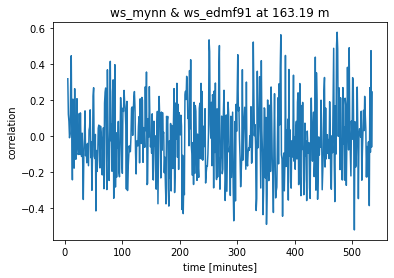

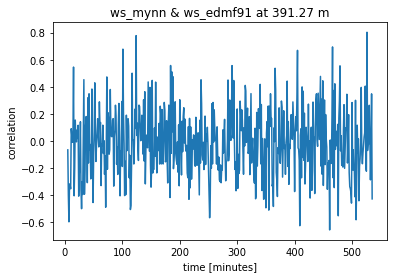

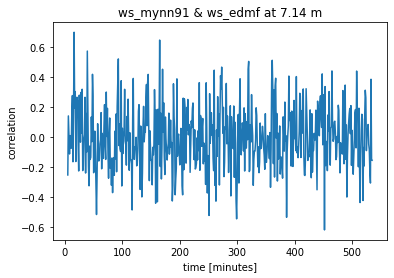

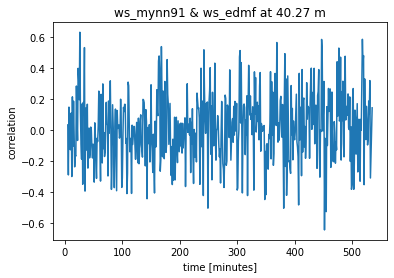

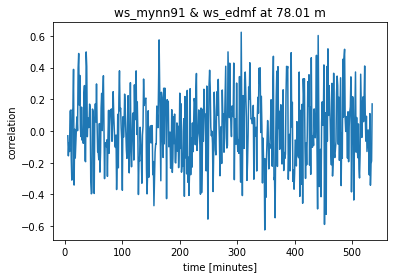

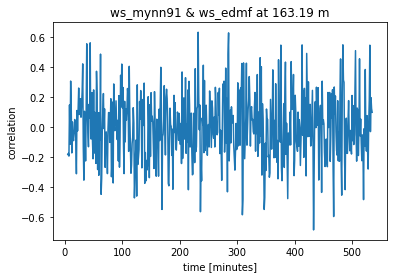

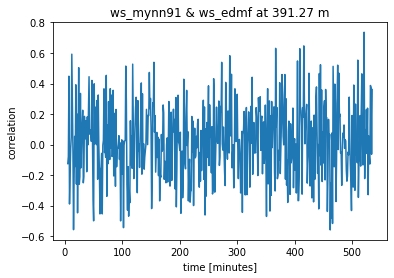

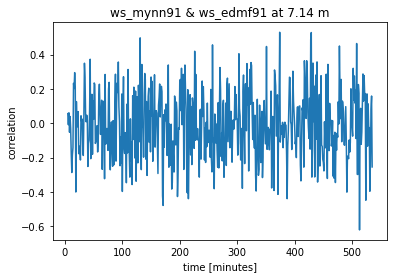

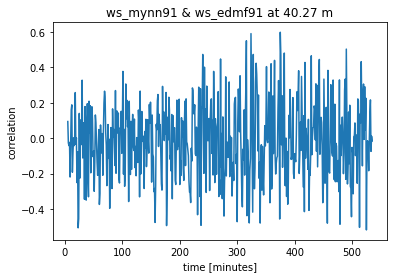

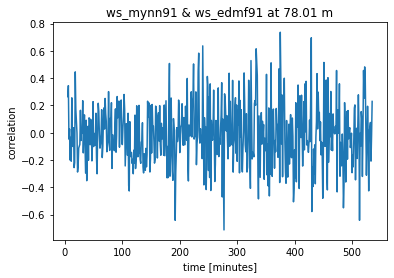

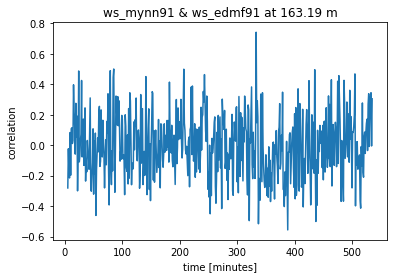

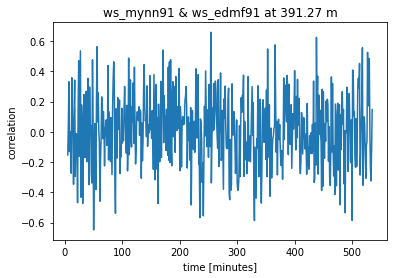

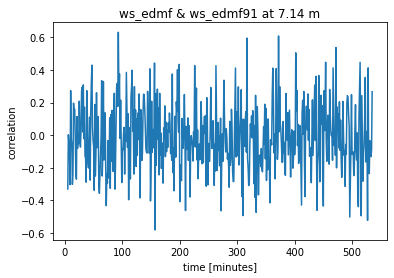

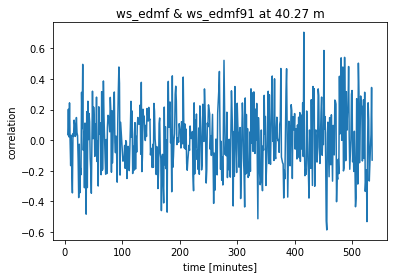

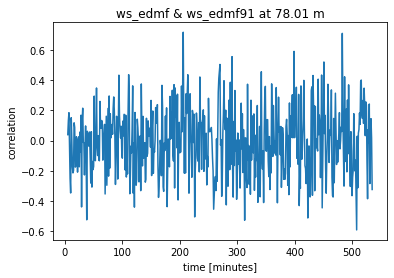

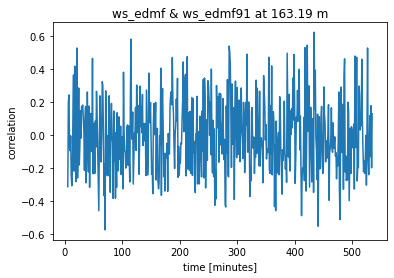

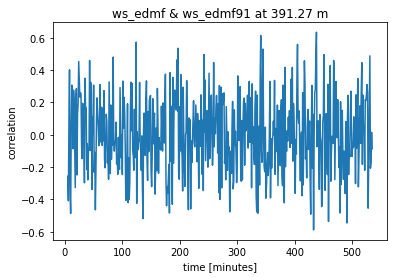

In [102]:
for pair in itertools.combinations(['ws_mynn', 'ws_mynn91', 'ws_edmf', 'ws_edmf91'], 2):

    for hgt_i in [1, 8, 16, 30, 45]:

        da_1h_a = ds_0805[pair[0]][:, hgt_i, :, :]
        dev_a = (abs(da_1h_a - da_1h_a.rolling(Time=10, center=True).mean()))
        da_1h_b = ds_0805[pair[1]][:, hgt_i, :, :]
        dev_b = (abs(da_1h_b - da_1h_b.rolling(Time=10, center=True).mean()))

        corr_list = []

        for i in range(dev_a.shape[0]):

            corr = np.corrcoef(np.array(dev_a[i, :, :]).flatten(), np.array(dev_b[i, :, :]).flatten())

            corr_list.append(corr[0, 1])

        plt.plot(corr_list)
        plt.title(pair[0]+' & '+pair[1]+' at '+str(np.round(ds_0805_hgt['hgt_mynn'][hgt_i].values, 2))+' m')
        plt.ylabel('correlation')
        plt.xlabel('time [minutes]')
        plt.show()

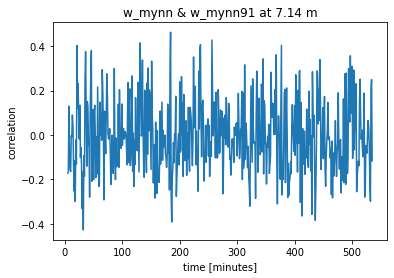

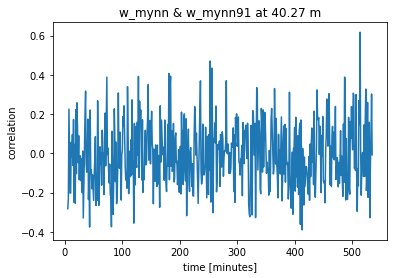

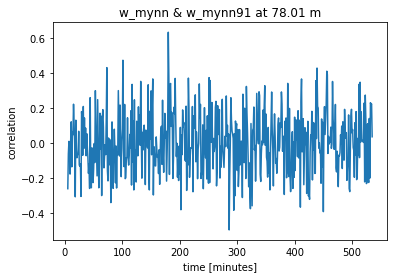

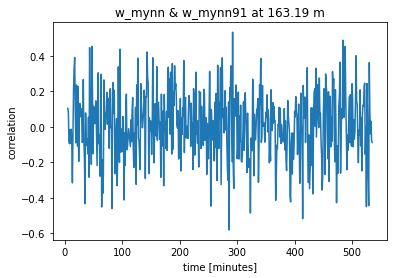

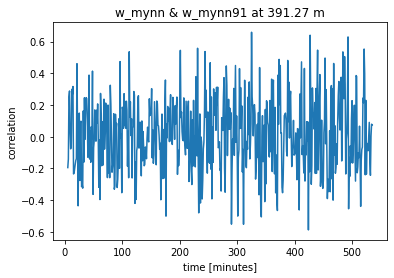

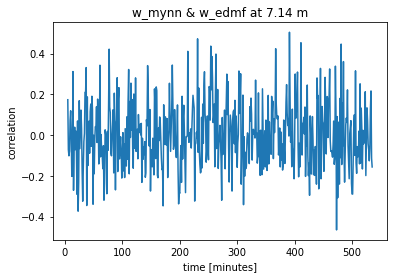

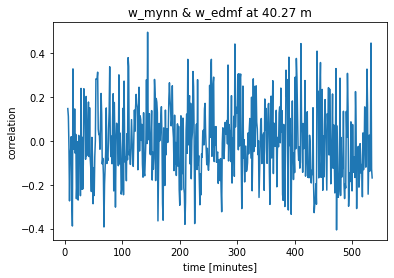

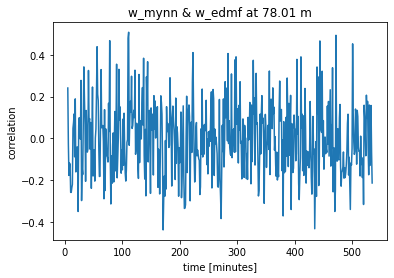

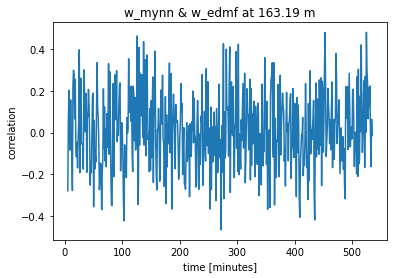

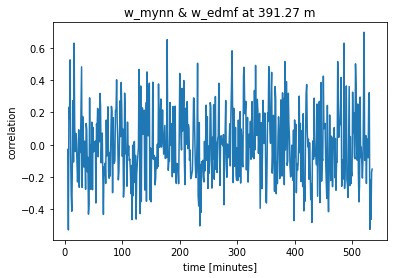

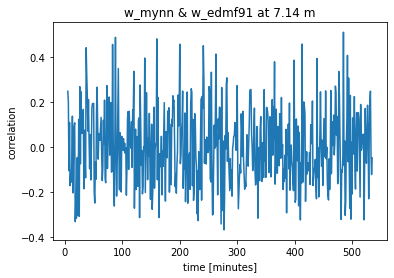

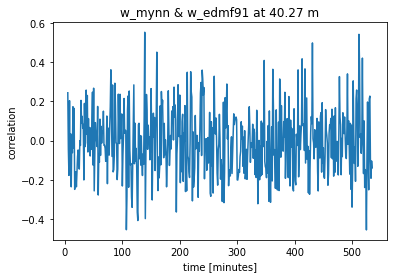

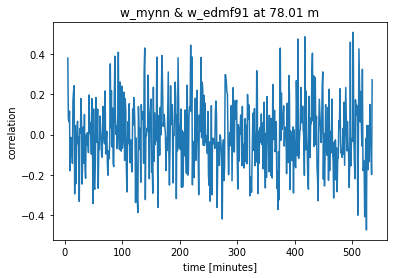

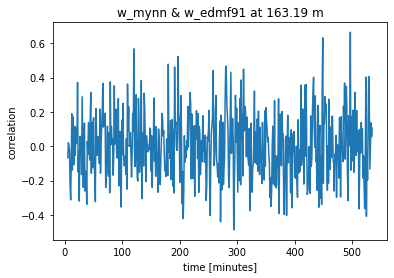

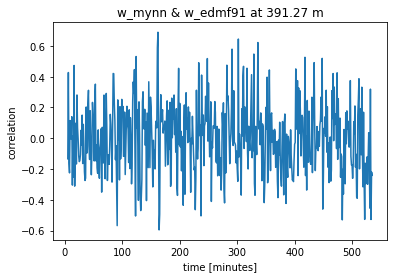

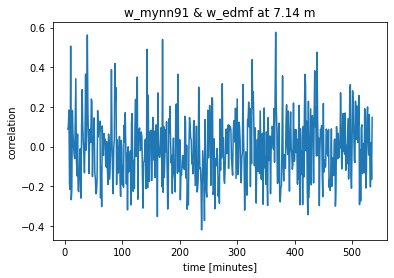

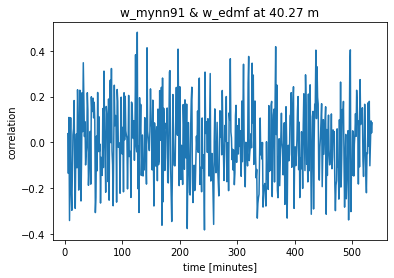

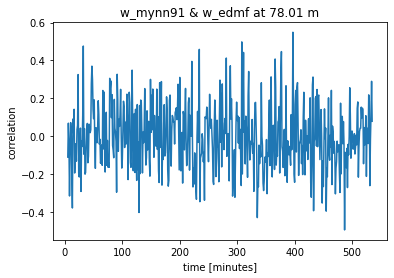

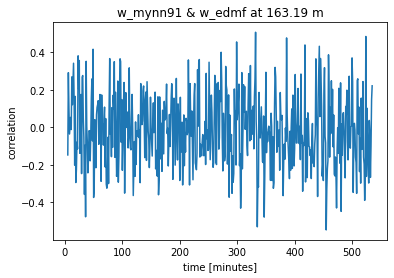

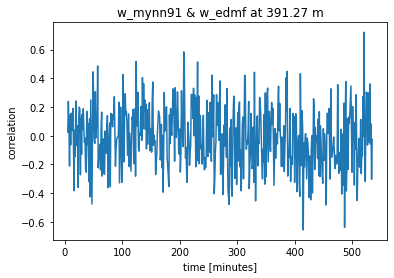

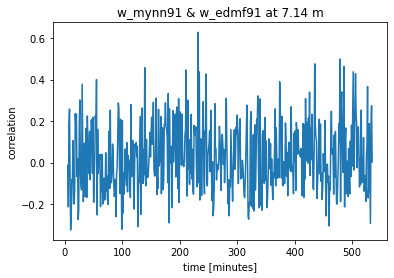

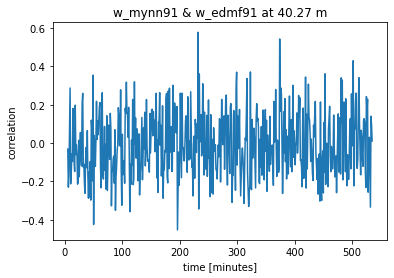

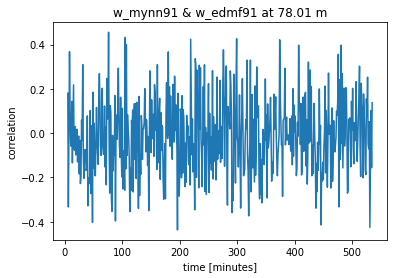

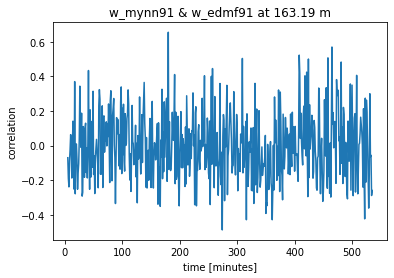

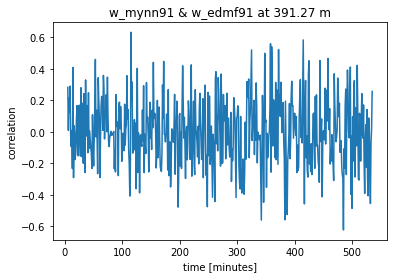

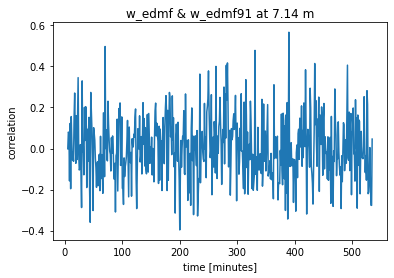

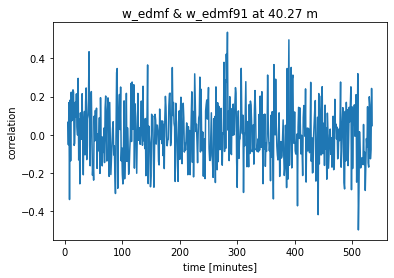

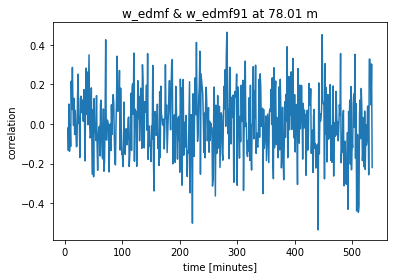

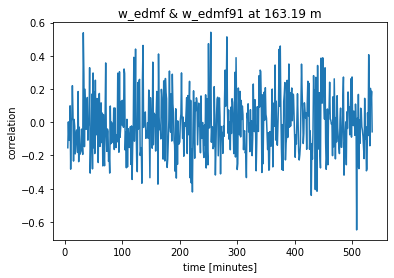

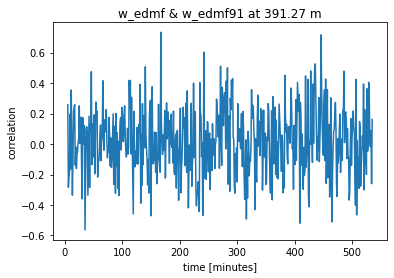

In [101]:
for pair in itertools.combinations(['w_mynn', 'w_mynn91', 'w_edmf', 'w_edmf91'], 2):

    for hgt_i in [1, 8, 16, 30, 45]:

        da_1h_a = ds_0805[pair[0]][:, hgt_i, :, :]
        dev_a = (abs(da_1h_a - da_1h_a.rolling(Time=10, center=True).mean()))
        da_1h_b = ds_0805[pair[1]][:, hgt_i, :, :]
        dev_b = (abs(da_1h_b - da_1h_b.rolling(Time=10, center=True).mean()))

        corr_list = []

        for i in range(dev_a.shape[0]):

            corr = np.corrcoef(np.array(dev_a[i, :, :]).flatten(), np.array(dev_b[i, :, :]).flatten())

            corr_list.append(corr[0, 1])

        plt.plot(corr_list)
        plt.title(pair[0]+' & '+pair[1]+' at '+str(np.round(ds_0805_hgt['hgt_mynn'][hgt_i].values, 2))+' m')
        plt.ylabel('correlation')
        plt.xlabel('time [minutes]')
        plt.show()

In [161]:
def cal_plot_corr_change_btw_run(da, da_hgt, var):

    for hgt_i in np.arange(0, 10):
    
        for pair in itertools.combinations([var+'_mynn', var+'_mynn91', var+'_edmf', var+'_edmf91'], 2):

    #     for hgt_i in [1, 8, 16, 30, 45]:
#         for hgt_i in [1, 8]:

            da_1h_a = da[pair[0]][:, hgt_i, :, :]
            dev_a = (abs(da_1h_a - da_1h_a.rolling(Time=10, center=True).mean()))
            da_1h_b = da[pair[1]][:, hgt_i, :, :]
            dev_b = (abs(da_1h_b - da_1h_b.rolling(Time=10, center=True).mean()))

#             time_frame = '1H'
            time_frame = '30min'
            
            dev_a = dev_a.resample(Time=time_frame).mean()
            dev_b = dev_b.resample(Time=time_frame).mean()

            corr_list = []

            for i in range(dev_a.shape[0]):
                corr = np.corrcoef(np.array(dev_a[i, :, :]).flatten(), np.array(dev_b[i, :, :]).flatten())
                corr_list.append(corr[0, 1])

            if np.abs(corr_list).max() > 0.6:
                plt.plot(corr_list)
                plt.axhline(y=0, linestyle='--', c='k')
                plt.title(pair[0]+' & '+pair[1]+' at '+str(np.round(da_hgt['hgt_mynn'][hgt_i].values, 2))+' m')
                plt.ylabel('correlation')
                plt.xlabel('time [minutes]')
                plt.show()

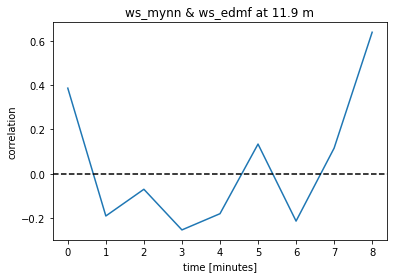

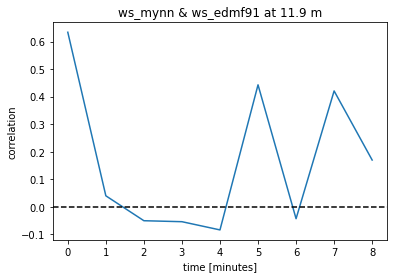

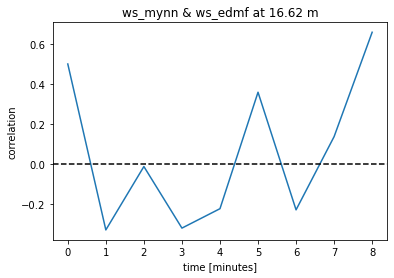

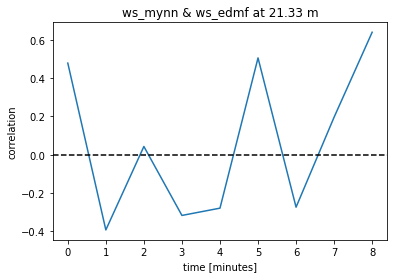

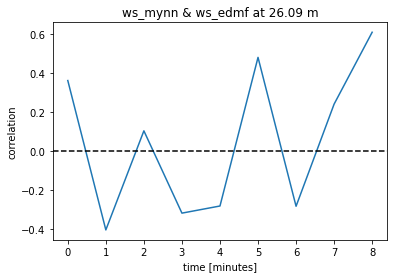

In [153]:
cal_plot_corr_change_btw_run(ds_0805, ds_0805_hgt, 'ws')

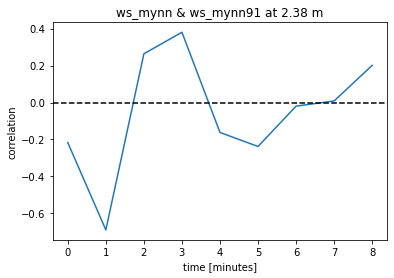

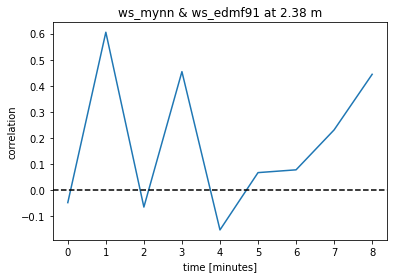

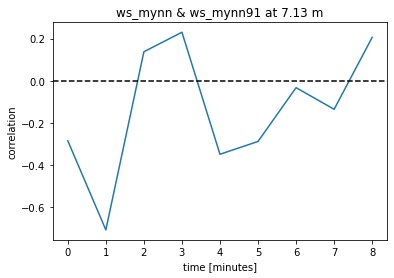

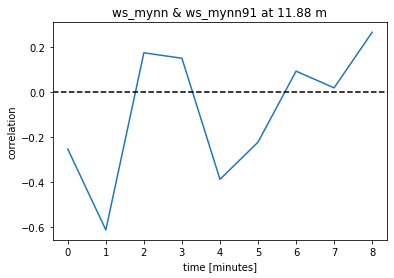

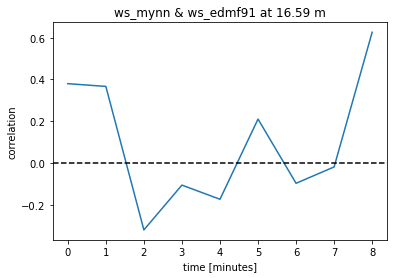

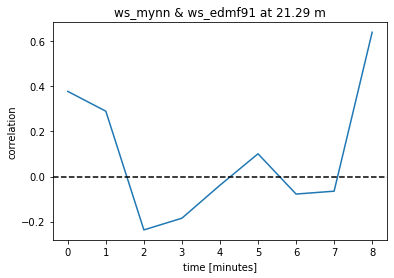

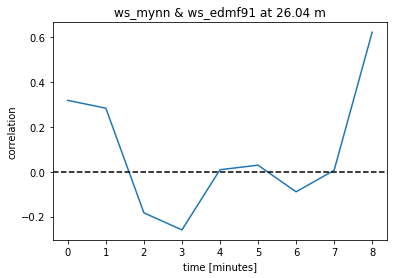

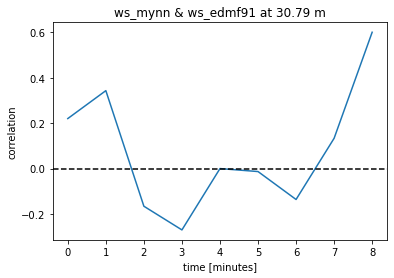

In [154]:
cal_plot_corr_change_btw_run(ds_0901, ds_0901_hgt, 'ws')

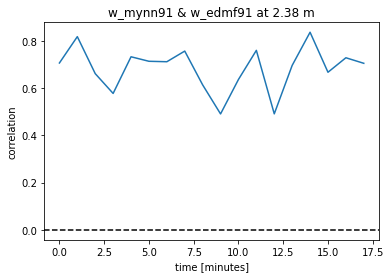

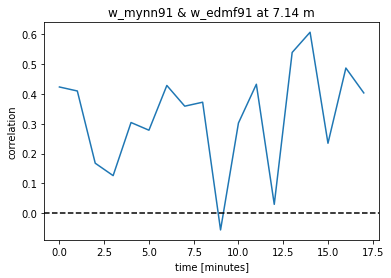

In [162]:
cal_plot_corr_change_btw_run(ds_0805, ds_0805_hgt, 'w')

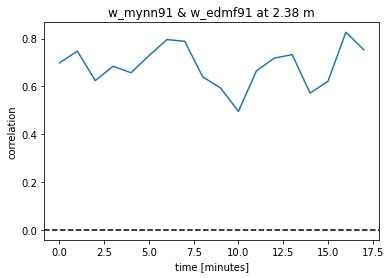

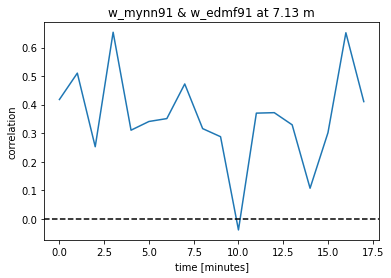

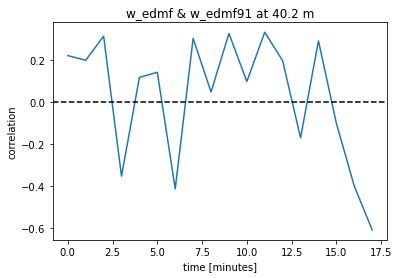

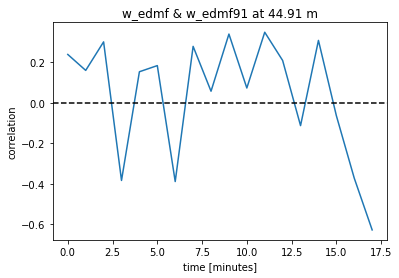

In [163]:
cal_plot_corr_change_btw_run(ds_0901, ds_0901_hgt, 'w')

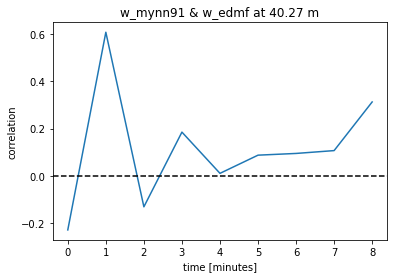

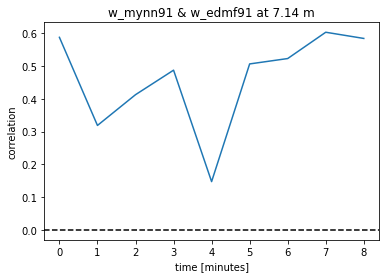

In [134]:
for pair in itertools.combinations(['w_mynn', 'w_mynn91', 'w_edmf', 'w_edmf91'], 2):

#     for hgt_i in [1, 8, 16, 30, 45]:
    for hgt_i in [1, 8]:

        da_1h_a = ds_0805[pair[0]][:, hgt_i, :, :]
        dev_a = (abs(da_1h_a - da_1h_a.rolling(Time=10, center=True).mean()))
        da_1h_b = ds_0805[pair[1]][:, hgt_i, :, :]
        dev_b = (abs(da_1h_b - da_1h_b.rolling(Time=10, center=True).mean()))
        
        dev_a = dev_a.resample(Time='1H').mean()
        dev_b = dev_b.resample(Time='1H').mean()

        corr_list = []

        for i in range(dev_a.shape[0]):

            corr = np.corrcoef(np.array(dev_a[i, :, :]).flatten(), np.array(dev_b[i, :, :]).flatten())

            corr_list.append(corr[0, 1])
            
        if np.abs(corr_list).max() > 0.6:

            plt.plot(corr_list)
            plt.axhline(y=0, linestyle='--', c='k')
            plt.title(pair[0]+' & '+pair[1]+' at '+str(np.round(ds_0805_hgt['hgt_mynn'][hgt_i].values, 2))+' m')
            plt.ylabel('correlation')
            plt.xlabel('time [minutes]')
            plt.show()

In [131]:
np.abs(corr_list).max()

0.35382733679148703

In [123]:
dev_a.resample(Time='10min').mean()

<xarray.DataArray 'w_edmf' (Time: 54, south_north: 13, west_east: 13)>
array([[[0.44682875, 0.42763162, 0.48124084, ..., 0.43161312,
         0.3904655 , 0.42007646],
        [0.36015356, 0.37964007, 0.42847067, ..., 0.27787974,
         0.278232  , 0.33101767],
        [0.3994544 , 0.44108987, 0.47573906, ..., 0.18871257,
         0.18815167, 0.30731565],
        ...,
        [0.18617406, 0.29387707, 0.2765501 , ..., 0.3473905 ,
         0.32994294, 0.23225474],
        [0.24616075, 0.30768093, 0.24540718, ..., 0.28940478,
         0.3355226 , 0.30604038],
        [0.29828316, 0.25364727, 0.25659505, ..., 0.21498165,
         0.30160776, 0.32613996]],

       [[0.24990182, 0.24350135, 0.24624515, ..., 0.28638738,
         0.26523143, 0.2610343 ],
        [0.22209032, 0.24514468, 0.37880725, ..., 0.235153  ,
         0.26143768, 0.27456173],
        [0.27549762, 0.28814846, 0.4425885 , ..., 0.16507581,
         0.275462  , 0.24808621],
...
        [0.35403794, 0.43119135, 0.54150593, ..., 0.41770425,
         0.34331158, 0.3141888 ],
        [0.36375543, 0.44701585, 0.4697236 , ..., 0.48326856,
         0.37386447, 0.27210286],
        [0.38612968, 0.5068811 , 0.45047975, ..., 0.5322958 ,
         0.44998017, 0.29840374]],

       [[0.27518234, 0.36727014, 0.30777037, ..., 0.5321148 ,
         0.38754377, 0.59826064],
        [0.30712715, 0.36231223, 0.45395696, ..., 0.56540626,
         0.44816616, 0.6292835 ],
        [0.37146834, 0.44780505, 0.6234462 , ..., 0.47127834,
         0.481593  , 0.5732396 ],
        ...,
        [0.6166232 , 0.70222354, 0.6513624 , ..., 0.44948968,
         0.38987932, 0.2798607 ],
        [0.6392627 , 0.7543834 , 0.54583323, ..., 0.43711296,
         0.3108466 , 0.28643405],
        [0.59089524, 0.67974573, 0.38337573, ..., 0.35052547,
         0.25844657, 0.2857504 ]]], dtype=float32)
Coordinates:
  * Time       (Time) datetime64[ns] 2018-08-05T14:00:00 ... 2018-08-05T22:50:00
    wspd_wdir  <U4 'wspd'
    XLONG      (south_north, west_east) float32 -97.49 -97.49 ... -97.48 -97.48
    XLAT       (south_north, west_east) float32 36.6 36.6 36.6 ... 36.61 36.61
Dimensions without coordinates: south_north, west_east

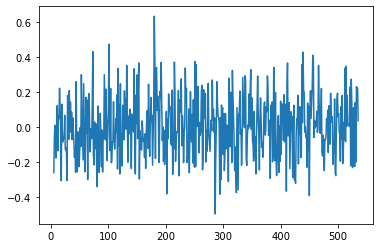

In [92]:
plt.plot(corr_list)

In [83]:
dev_a[0, :, :], dev_b[0, :, :]

<xarray.DataArray 'w_mynn91' (south_north: 13, west_east: 13)>
array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]],
      dtype=float32)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XLONG      (south_north, west_east) float32 -97.49 -97.49 ... -97.48 -97.48
    XLAT       (south_north, west_east) float32 36.6 36.6 36.6 ... 36.61 36.61
    XTIME      float32 1.56e+03
    Time       datetime64[ns] 2018-08-05T14:00:00
Dimensions without coordinates: south_north, west_east

In [78]:
da_1h = ds_0805['w_mynn'][:, 16, :, :]

In [79]:
# ti = (abs(da_1h - da_1h.rolling(Time=10, center=True).mean())
#                   /da_1h.rolling(Time=10, center=True).mean())
            
ti = (abs(da_1h - da_1h.rolling(Time=10, center=True).mean()))

#             if std_or_mean == 'mean':
#                 std = ti.mean(dim='Time')
#             if std_or_mean == 'std':
std = ti.std(dim='Time')

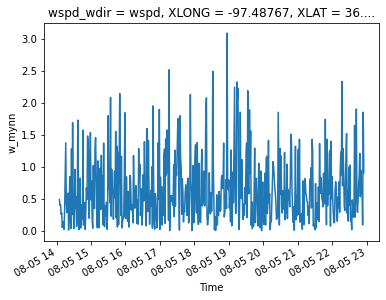

In [80]:
ti[:, 0, 0].plot()

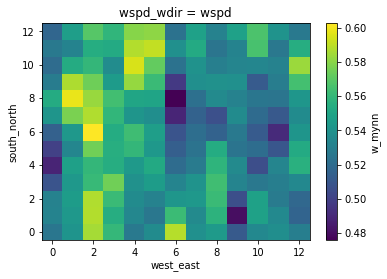

In [74]:
std.plot()

In [47]:
ds_0805['ws_mynn']

<xarray.DataArray 'ws_mynn' (Time: 540, bottom_top: 50, south_north: 13, west_east: 13)>
array([[[[ 2.997243 ,  3.364471 ,  3.7679539, ...,  5.3233347,
           5.3040795,  5.0602374],
         [ 2.9292698,  3.0865705,  3.4402642, ...,  5.085626 ,
           5.057336 ,  4.8528337],
         [ 3.000431 ,  2.9302554,  3.04241  , ...,  4.810353 ,
           4.743955 ,  4.52578  ],
         ...,
         [ 3.589272 ,  3.2625818,  3.375242 , ...,  5.154065 ,
           4.412835 ,  4.111865 ],
         [ 3.6392915,  3.258344 ,  3.3483338, ...,  5.256285 ,
           4.545214 ,  4.1787224],
         [ 3.6805334,  3.2556915,  3.3001251, ...,  5.310964 ,
           4.691541 ,  4.306003 ]],

        [[ 4.1987796,  4.759672 ,  4.9848595, ...,  7.3523707,
           7.3970103,  6.962348 ],
         [ 4.0108204,  4.2782693,  4.5882893, ...,  7.0543804,
           7.162353 ,  6.850852 ],
         [ 4.029023 ,  3.9662056,  4.156565 , ...,  6.748365 ,
           6.8013334,  6.563843 ],
...
         [ 9.511099 ,  9.1476145,  9.394563 , ...,  8.919828 ,
           8.476859 ,  8.473408 ],
         [ 9.208931 ,  8.749333 ,  8.946983 , ...,  9.012828 ,
           8.6370125,  8.436676 ],
         [ 9.199207 ,  8.763544 ,  8.797225 , ...,  8.959053 ,
           8.851499 ,  8.653956 ]],

        [[11.546745 , 11.613924 , 11.559495 , ...,  8.727857 ,
           8.767279 ,  8.926718 ],
         [11.525773 , 11.568379 , 11.5205765, ...,  8.727429 ,
           8.668023 ,  8.68654  ],
         [11.387215 , 11.401025 , 11.446525 , ...,  8.808898 ,
           8.689627 ,  8.581388 ],
         ...,
         [ 9.087676 ,  8.616122 ,  8.760389 , ...,  8.904477 ,
           8.726293 ,  8.349313 ],
         [ 8.866268 ,  8.390422 ,  8.356364 , ...,  8.727235 ,
           8.756763 ,  8.55796  ],
         [ 9.011148 ,  8.661249 ,  8.538356 , ...,  8.694857 ,
           8.669182 ,  8.708225 ]]]], dtype=float32)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XLONG      (south_north, west_east) float32 -97.49 -97.49 ... -97.48 -97.48
    XLAT       (south_north, west_east) float32 36.6 36.6 36.6 ... 36.61 36.61
    XTIME      (Time) float32 1.56e+03 1.561e+03 ... 2.098e+03 2.099e+03
  * Time       (Time) datetime64[ns] 2018-08-05T14:00:00 ... 2018-08-05T22:59:00
Dimensions without coordinates: bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  wspd,wdir in projection space
    units:        m s-1
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...

In [ ]:
hgt_i = 16
fig, ax = plt.subplots()

for da in [ws_da_mynn_0805, ws_da_mynn91_0805, ws_da_edmf_0805, ws_da_edmf91_0805]:
# da = ws_da_mynn_0805

    ti = 100*abs(da - da.rolling(Time=10, center=True).mean())/da.rolling(Time=10, center=True).mean()
    ti_mean = ti[:, hgt_i, :, :].mean(dim=['south_north', 'west_east']).resample(Time='10min').mean()
    ti_std = ti[:, hgt_i, :, :].std(dim=['south_north', 'west_east']).resample(Time='10min').mean()

    ti_std.plot(ax=ax)
#     ti_mean.plot(ax=ax)
#     ax.fill_between(ti_mean['Time'], ti_mean-ti_std, ti_mean+ti_std, alpha=0.2)

In [249]:
ti[5, 16, :, :].std()

<xarray.DataArray 'wspd_wdir' ()>
array(5.20087337)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 1.565e+03
    Time       datetime64[ns] 2018-08-05T14:05:00

In [241]:
ti[:, 16, :, :].std(dim=['south_north', 'west_east'])

/home/jlee/.conda/envs/mmc_sgp/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.DataArray 'wspd_wdir' (Time: 540)>
array([       nan,        nan,        nan,        nan,        nan,
        5.2008734,  7.2970257,  5.749708 ,  4.2442865,  6.2728615,
        7.5687437,  3.870424 ,  3.4693272,  5.2834206,  6.1337585,
        3.8384612,  7.6014853,  7.08139  ,  4.633852 ,  7.2056317,
        7.8408046,  3.4300098,  5.0054483,  6.2777686,  6.194682 ,
        5.8518243,  6.4229193,  5.430184 ,  6.6736135,  6.9499855,
        6.7746897,  5.2983336,  7.0941496,  7.5862274,  5.3019156,
        5.438998 ,  6.9224086,  7.1728196,  5.9762783,  3.088422 ,
        4.256204 ,  8.156367 ,  7.6512594,  3.2544358,  3.8300366,
        3.634949 ,  3.4742503,  4.3714123,  3.7768776,  4.0745993,
        4.3863025,  5.6727676,  4.1883497,  5.4913077,  3.7630746,
        4.880942 ,  4.742226 ,  4.1985793,  6.021315 ,  6.3864903,
        4.392093 ,  4.837147 ,  4.82314  ,  7.514705 ,  7.7104816,
        5.191238 ,  5.89587  ,  4.4762387,  7.864873 ,  5.7456293,
        5.2910104,  4.22754  ,  4.876677 ,  6.459121 ,  4.274204 ,
        5.66744  ,  6.5623536,  7.178898 ,  4.399627 ,  7.350914 ,
        6.172514 ,  6.684669 ,  4.428603 ,  4.553026 ,  4.8551283,
        6.960649 ,  6.674919 ,  9.434396 ,  7.806329 ,  3.7385235,
        8.981329 ,  6.697299 ,  3.9009738,  6.1309457,  4.9031982,
        3.4758835,  2.9450083,  3.8564641,  6.28759  ,  5.3091516,
...
        7.984355 ,  9.1618805,  7.669465 ,  6.3506384,  5.761376 ,
        4.4427056,  4.4228086,  6.8997383,  4.462745 ,  7.839889 ,
        5.919549 ,  5.4103518,  6.744574 ,  7.969469 ,  8.791003 ,
       13.173835 , 10.9745245,  6.75612  ,  8.826807 ,  8.774516 ,
        7.7983594,  9.777884 ,  9.724017 , 10.534878 ,  8.148805 ,
        6.5279474,  9.067014 , 11.533921 ,  8.92026  ,  9.875131 ,
       13.602398 ,  5.482132 , 12.147249 ,  7.872891 ,  5.273065 ,
       10.474446 , 11.3235035,  8.105713 , 10.567486 ,  8.198006 ,
        6.914641 ,  7.4358487,  5.482377 ,  6.0389695,  7.7792835,
        4.260127 ,  4.700151 ,  6.948526 ,  5.440545 ,  7.9451876,
        5.557487 ,  6.7510786,  6.748325 ,  6.0975566,  6.9257116,
        7.899872 ,  6.7611117,  8.456101 , 13.187936 , 10.967333 ,
        9.065206 ,  6.6123075,  7.342775 ,  5.026799 ,  6.9938426,
       10.594318 ,  8.421641 ,  5.0821047,  4.6958795,  6.5026684,
        4.4602203,  5.134373 ,  5.350852 ,  7.7320766,  6.960225 ,
        3.3749416,  4.040562 , 10.1048565,  5.5682774, 11.681674 ,
        4.581795 ,  5.205712 ,  4.742075 ,  5.3427844,  6.108024 ,
        5.2582407, 11.003383 ,  4.0155225,  4.861586 ,  6.800521 ,
        9.087661 ,        nan,        nan,        nan,        nan],
      dtype=float32)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      (Time) float32 1.56e+03 1.561e+03 ... 2.098e+03 2.099e+03
  * Time       (Time) datetime64[ns] 2018-08-05T14:00:00 ... 2018-08-05T22:59:00

In [219]:
ti = abs(da - da.rolling(Time=10, center=True).mean())/da.rolling(Time=10, center=True).mean()

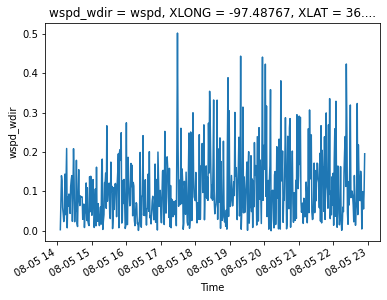

In [223]:
ti[:, 16, 0, 0].plot()

In [195]:
da.resample(Time='10min').mean()

<xarray.DataArray 'destag_W' (Time: 54, bottom_top: 108, south_north: 13, west_east: 13)>
array([[[[ 8.84658098e-03, -3.08111822e-03, -1.33522023e-02, ...,
           4.47354105e-04, -1.43255712e-02, -2.64151152e-02],
         [ 8.91033746e-03,  8.25956289e-04, -6.41404698e-03, ...,
           1.03673832e-02, -1.03255715e-02, -2.70438232e-02],
         [ 3.77233373e-03,  3.64369480e-03,  1.18990557e-03, ...,
           1.16024641e-02, -2.06891284e-03, -2.34664958e-02],
         ...,
         [-1.69641189e-02, -1.62218660e-02, -2.02761721e-02, ...,
          -1.58717055e-02, -2.07988489e-02, -1.45639749e-02],
         [-1.70287136e-02, -1.59423761e-02, -1.61927119e-02, ...,
          -1.39207598e-02, -1.89367738e-02, -1.30946990e-02],
         [-1.73984263e-02, -1.42379608e-02, -1.39601408e-02, ...,
          -9.74321552e-03, -1.56415105e-02, -1.28502520e-02]],

        [[ 2.39300299e-02, -1.07707102e-02, -3.44226435e-02, ...,
           9.70797986e-03, -3.53232846e-02, -6.02017753e-02],
         [ 2.36732792e-02,  2.96191126e-03, -1.54332248e-02, ...,
           3.84636931e-02, -2.24142037e-02, -6.41489625e-02],
         [ 1.07741905e-02,  1.36474688e-02,  7.26242084e-03, ...,
           4.42885384e-02,  8.09032470e-04, -5.61087132e-02],
...
          -2.06562355e-02, -2.06939578e-02, -2.07351595e-02],
         [-2.04401724e-02, -2.04447806e-02, -2.04542000e-02, ...,
          -2.06789151e-02, -2.07080953e-02, -2.07349770e-02],
         [-2.04461850e-02, -2.04475932e-02, -2.04677135e-02, ...,
          -2.06553880e-02, -2.06893440e-02, -2.07254775e-02]],

        [[-4.85687423e-03, -5.19379601e-03, -5.55072259e-03, ...,
          -5.50743658e-03, -5.25787706e-03, -5.65764587e-03],
         [-4.50355653e-03, -4.78227483e-03, -5.86150307e-03, ...,
          -4.81926929e-03, -5.00850473e-03, -5.29264426e-03],
         [-4.66237869e-03, -5.06009767e-03, -4.98073269e-03, ...,
          -4.85286908e-03, -5.34471963e-03, -5.33008855e-03],
         ...,
         [-4.97246673e-03, -4.58664913e-03, -5.21220872e-03, ...,
          -5.20242378e-03, -4.88390028e-03, -5.04942238e-03],
         [-4.55436949e-03, -5.07836975e-03, -5.86006697e-03, ...,
          -5.79338893e-03, -5.39781898e-03, -5.69680426e-03],
         [-5.43802744e-03, -5.14146592e-03, -5.86925494e-03, ...,
          -5.70281129e-03, -5.38465008e-03, -5.61954686e-03]]]],
      dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 2018-08-05T14:00:00 ... 2018-08-05T22:50:00
    XLAT     (south_north, west_east) float32 36.6 36.6 36.6 ... 36.61 36.61
    XLONG    (south_north, west_east) float32 -97.49 -97.49 ... -97.48 -97.48
Dimensions without coordinates: bottom_top, south_north, west_east

In [200]:
da - da.resample(Time='10min').mean()

<xarray.DataArray 'destag_W' (Time: 54, bottom_top: 108, south_north: 13, west_east: 13)>
array([[[[ 1.15584433e-02,  1.51293501e-02,  5.91999963e-02, ...,
           1.53146056e-03,  6.90460205e-03,  1.57706570e-02],
         [ 5.04161417e-03,  1.35448845e-02,  8.70802328e-02, ...,
           4.29033581e-03,  2.99908966e-03,  1.40190916e-02],
         [ 3.61993676e-03,  1.59903560e-02,  9.15030539e-02, ...,
           3.09295487e-03, -5.63378260e-03,  1.02145644e-02],
         ...,
         [-6.30417280e-03, -1.40324235e-02, -1.29514989e-02, ...,
          -4.35937382e-03,  2.08652429e-02,  1.38344662e-02],
         [-4.80224378e-03, -1.08452365e-02, -2.13963352e-02, ...,
          -1.44483149e-02,  1.71166025e-02,  9.15711559e-03],
         [-1.92235224e-03, -7.63388164e-03, -2.84167491e-02, ...,
          -3.00189722e-02,  6.51941355e-03,  6.80605276e-03]],

        [[ 3.74208018e-02,  4.75903749e-02,  1.73545450e-01, ...,
           4.46077157e-03,  1.53474864e-02,  4.42504995e-02],
         [ 1.69783328e-02,  4.66787815e-02,  2.56075323e-01, ...,
           1.49527192e-03,  3.99943441e-04,  4.03205790e-02],
         [ 1.16260471e-02,  5.40445149e-02,  2.74708062e-01, ...,
          -2.43473798e-03, -1.49578294e-02,  3.12593877e-02],
...
           2.43037194e-03,  2.42364593e-03,  2.53289007e-03],
         [ 2.72340700e-03,  2.71913782e-03,  2.69007497e-03, ...,
           2.46402994e-03,  2.41691247e-03,  2.50194781e-03],
         [ 2.76804157e-03,  2.75428034e-03,  2.77070701e-03, ...,
           2.45398469e-03,  2.41411664e-03,  2.47235410e-03]],

        [[ 1.53558329e-04,  1.12347305e-04, -3.47418711e-04, ...,
          -1.02431793e-03, -1.02328556e-03, -1.07426476e-03],
         [-9.57371667e-05, -1.90198887e-04, -1.72056723e-04, ...,
          -7.94680323e-04, -7.67934136e-04, -1.05305482e-03],
         [-1.28941610e-04, -3.19024548e-06, -5.09380829e-04, ...,
          -2.90734228e-04, -6.41337596e-04, -7.66148325e-04],
         ...,
         [-1.28905196e-03, -1.30571984e-03, -1.28925545e-03, ...,
          -9.10930336e-04, -1.14319799e-03, -1.53449457e-03],
         [-1.46487821e-03, -1.49884168e-03, -1.54247787e-03, ...,
          -9.66494437e-04, -9.26664099e-04, -1.60960574e-03],
         [-1.43760676e-03, -1.69796683e-03, -1.77488243e-03, ...,
          -1.10837072e-03, -1.04712974e-03, -1.37986941e-03]]]],
      dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 2018-08-05T14:00:00 ... 2018-08-05T22:50:00
    XLAT     (south_north, west_east) float32 36.6 36.6 36.6 ... 36.61 36.61
    XLONG    (south_north, west_east) float32 -97.49 -97.49 ... -97.48 -97.48
    XTIME    (Time) float32 1.56e+03 1.57e+03 1.58e+03 ... 2.08e+03 2.09e+03
Dimensions without coordinates: bottom_top, south_north, west_east

In [179]:
ws_da_mynn_0805.resample(Time='10min').mean()

<xarray.DataArray 'wspd_wdir' (Time: 54, bottom_top: 108, south_north: 13, west_east: 13)>
array([[[[ 3.9128056,  4.002115 ,  4.1334066, ...,  4.433359 ,
           4.6525993,  4.703406 ],
         [ 3.9323833,  3.9472146,  4.0481443, ...,  4.3645906,
           4.584338 ,  4.706275 ],
         [ 3.984773 ,  3.9175408,  3.9530327, ...,  4.300435 ,
           4.4723225,  4.646506 ],
         ...,
         [ 3.92631  ,  3.8497562,  3.6639187, ...,  4.2903223,
           4.2133007,  4.0513926],
         [ 3.9064775,  3.8538086,  3.6231277, ...,  4.271413 ,
           4.2760305,  4.0986032],
         [ 3.8477929,  3.865652 ,  3.611689 , ...,  4.2235136,
           4.299712 ,  4.173085 ]],

        [[ 5.513118 ,  5.696323 ,  5.8964696, ...,  6.0242815,
           6.375678 ,  6.460679 ],
         [ 5.532325 ,  5.5740795,  5.7428746, ...,  5.936155 ,
           6.3013926,  6.5039916],
         [ 5.606578 ,  5.499614 ,  5.5737963, ...,  5.8903003,
           6.164744 ,  6.456969 ],
...
         [ 9.981691 ,  9.979942 ,  9.978223 , ...,  9.964306 ,
           9.962396 ,  9.960817 ],
         [ 9.98382  ,  9.981992 ,  9.979944 , ...,  9.966477 ,
           9.96478  ,  9.962957 ],
         [ 9.985962 ,  9.984431 ,  9.982563 , ...,  9.968102 ,
           9.9667   ,  9.964979 ]],

        [[14.033796 , 14.035947 , 14.037865 , ..., 14.056814 ,
          14.059443 , 14.061679 ],
         [14.032316 , 14.033394 , 14.035184 , ..., 14.054817 ,
          14.057355 , 14.059649 ],
         [14.030113 , 14.031855 , 14.033705 , ..., 14.052457 ,
          14.05479  , 14.057797 ],
         ...,
         [14.017621 , 14.019697 , 14.021429 , ..., 14.038719 ,
          14.040883 , 14.042872 ],
         [14.016225 , 14.018091 , 14.019953 , ..., 14.036939 ,
          14.039459 , 14.04142  ],
         [14.014646 , 14.016211 , 14.017897 , ..., 14.035246 ,
          14.0380125, 14.04019  ]]]], dtype=float32)
Coordinates:
  * Time       (Time) datetime64[ns] 2018-08-05T14:00:00 ... 2018-08-05T22:50:00
    wspd_wdir  <U4 'wspd'
    XLONG      (south_north, west_east) float32 -97.49 -97.49 ... -97.48 -97.48
    XLAT       (south_north, west_east) float32 36.6 36.6 36.6 ... 36.61 36.61
Dimensions without coordinates: bottom_top, south_north, west_east

(0.0, 3.0)

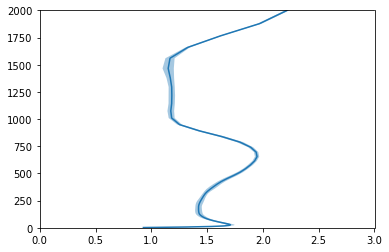

In [145]:
line = ws_da_mynn_0805.std(dim='Time').mean(dim=['south_north', 'west_east'])
shade = ws_da_mynn_0805.std(dim='Time').std(dim=['south_north', 'west_east'])

plt.plot(line, hgt_mynn_0805, label='')
plt.fill_betweenx(hgt_mynn_0805, line-shade, line+shade, alpha=0.4)

plt.ylim(0, 2000)
plt.xlim(0, 3)

In [124]:
hgt_mynn_0805

<xarray.DataArray 'height_agl' (bottom_top: 108)>
array([2.44894004e+00, 7.34470463e+00, 1.22373457e+01, 1.70858746e+01,
       2.19323196e+01, 2.68189964e+01, 3.17042980e+01, 3.65479279e+01,
       4.13911133e+01, 4.62342720e+01, 5.10780525e+01, 5.59637794e+01,
       6.08088722e+01, 6.56549606e+01, 7.05021744e+01, 7.53086548e+01,
       8.01579208e+01, 8.50082397e+01, 8.98596802e+01, 9.47124786e+01,
       9.95251999e+01, 1.04505249e+02, 1.09860184e+02, 1.15548996e+02,
       1.21613708e+02, 1.28096405e+02, 1.34997498e+02, 1.42358856e+02,
       1.50222839e+02, 1.58632095e+02, 1.67587112e+02, 1.77130447e+02,
       1.87305222e+02, 1.98154282e+02, 2.09762512e+02, 2.22131882e+02,
       2.35305817e+02, 2.49369614e+02, 2.64368317e+02, 2.80388550e+02,
       2.97433289e+02, 3.15590332e+02, 3.34989777e+02, 3.55678772e+02,
       3.77746521e+02, 4.01283264e+02, 4.26339203e+02, 4.53048950e+02,
       4.81549011e+02, 5.11892181e+02, 5.44217224e+02, 5.78708923e+02,
       6.15468079e+02, 6.54597961e+02, 6.96290894e+02, 7.40741516e+02,
       7.88062378e+02, 8.38412842e+02, 8.92044006e+02, 9.49169128e+02,
       1.00996362e+03, 1.07469788e+03, 1.14360535e+03, 1.21688416e+03,
       1.29483154e+03, 1.37775562e+03, 1.46593274e+03, 1.55970056e+03,
       1.65936523e+03, 1.76529956e+03, 1.87789722e+03, 1.99748181e+03,
       2.12444849e+03, 2.25927002e+03, 2.40240942e+03, 2.55431885e+03,
       2.71551050e+03, 2.88655762e+03, 3.06814185e+03, 3.26098901e+03,
       3.46576733e+03, 3.68325806e+03, 3.91427563e+03, 4.15946387e+03,
       4.41959668e+03, 4.69562354e+03, 4.98851758e+03, 5.29924805e+03,
       5.62865088e+03, 5.97751855e+03, 6.34679248e+03, 6.73743018e+03,
       7.15064209e+03, 7.58783594e+03, 8.05008252e+03, 8.53807324e+03,
       9.05210156e+03, 9.59282031e+03, 1.01606719e+04, 1.07554316e+04,
       1.13773438e+04, 1.20275391e+04, 1.27073408e+04, 1.34164727e+04,
       1.41585098e+04, 1.49422734e+04, 1.57737725e+04, 1.62882070e+04],
      dtype=float32)
Coordinates:
    XTIME    float32 2.09e+03
    Time     datetime64[ns] 2018-08-05T22:50:00
Dimensions without coordinates: bottom_top

mynn : 1.0575362
mynn91 : 1.1401775
edmf : 1.0975248
edmf91 : 1.1588454


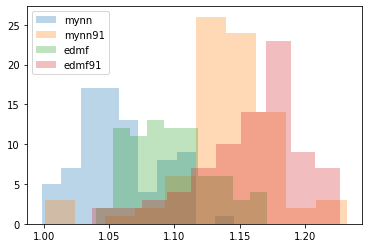

In [85]:
hgt_i = 30
al_pha = 0.3

w_da_list = [w_da_mynn_0901, w_da_mynn91_0901, w_da_edmf_0901, w_da_edmf91_0901]
run_list = ['mynn', 'mynn91', 'edmf', 'edmf91']

for w_da, run_name in zip(w_da_list, run_list):

    plt.hist(np.array(w_da[:, hgt_i, :, :].std(dim='Time')).flatten(), label=run_name, alpha=al_pha)
    print(run_name, ':', w_da[:, hgt_i, :, :].std(dim='Time').mean().values)

plt.legend()
plt.show()

In [72]:
w_da_mynn[:, hgt_i, :, :].std(dim='Time').mean().values

array(0.91623604, dtype=float32)

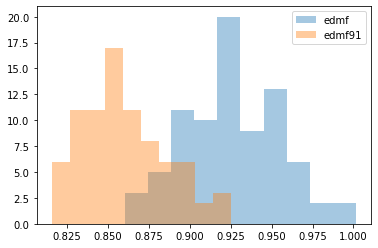

In [61]:
hgt_i = 16
al_pha = 0.4

plt.hist(np.array(w_da_edmf[:, hgt_i, :, :].std(dim='Time')).flatten(), label='edmf', alpha=al_pha)
plt.hist(np.array(w_da_edmf91[:, hgt_i, :, :].std(dim='Time')).flatten(), label='edmf91', alpha=al_pha)

plt.legend()
plt.show()

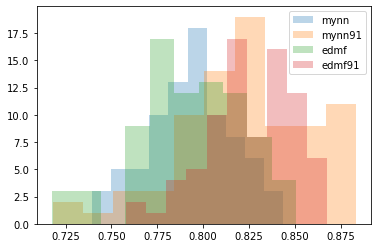

In [69]:
hgt_i = 16
al_pha = 0.3

plt.hist(np.array(w_da_mynn_0901[:, hgt_i, :, :].std(dim='Time')).flatten(), label='mynn', alpha=al_pha)
plt.hist(np.array(w_da_mynn91_0901[:, hgt_i, :, :].std(dim='Time')).flatten(), label='mynn91', alpha=al_pha)
plt.hist(np.array(w_da_edmf_0901[:, hgt_i, :, :].std(dim='Time')).flatten(), label='edmf', alpha=al_pha)
plt.hist(np.array(w_da_edmf91_0901[:, hgt_i, :, :].std(dim='Time')).flatten(), label='edmf91', alpha=al_pha)

plt.legend()
plt.show()

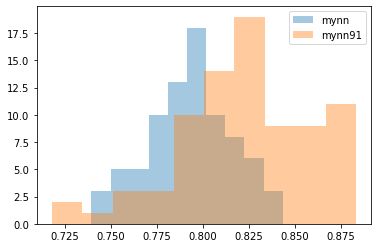

In [63]:
hgt_i = 16
al_pha = 0.4

plt.hist(np.array(w_da_mynn_0901[:, hgt_i, :, :].std(dim='Time')).flatten(), label='mynn', alpha=al_pha)
plt.hist(np.array(w_da_mynn91_0901[:, hgt_i, :, :].std(dim='Time')).flatten(), label='mynn91', alpha=al_pha)
# plt.hist(np.array(w_da_edmf[:, hgt_i, :, :].std(dim='Time')).flatten(), label='edmf', alpha=al_pha)
# plt.hist(np.array(w_da_edmf91[:, hgt_i, :, :].std(dim='Time')).flatten(), label='edmf91', alpha=al_pha)

plt.legend()
plt.show()

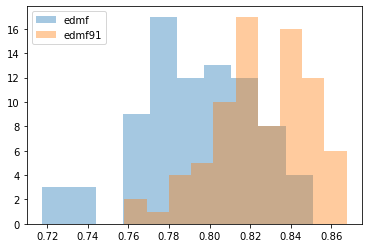

In [66]:
hgt_i = 16
al_pha = 0.4

plt.hist(np.array(w_da_edmf_0901[:, hgt_i, :, :].std(dim='Time')).flatten(), label='edmf', alpha=al_pha)
plt.hist(np.array(w_da_edmf91_0901[:, hgt_i, :, :].std(dim='Time')).flatten(), label='edmf91', alpha=al_pha)

plt.legend()
plt.show()

In [21]:
eval_date = '2018-08-05'
run = 'mynn_d12-9s_d34-1s'
neighbor = 4
    
# def get_neighbor_flux_da(eval_date, run, neighbor):
    
date_col = data_dir_df[eval_date]
try:
    del(w_da)
except:
    pass

for ind, hr in enumerate(np.arange(14, 23, 1)): 

    for minute in np.arange(0, 60, 10):

        if minute == 0:
            minute = '00'
        else:
            minute = str(minute)

        file = wrf_runs_dir+date_col[run]+'/auxout/mmc_d04_'+eval_date+'_'+str(hr)+':'+minute+':00'
        print(file)

        wrf_single = Dataset(file, 'r')

        site_loc_ij = wrf.ll_to_xy(wrf_single, site_latitude, site_longitude)
        sn_ind, we_ind = site_loc_ij.values[1], site_loc_ij.values[0]

#         wrf_time = wrf.extract_times(wrf_single, timeidx=wrf.ALL_TIMES)

        var = wrf.getvar(wrf_single, 'W', timeidx=wrf.ALL_TIMES)
        w = wrf.destagger(var, 1, meta=True)
        w = w.assign_coords(var.coords)

        if wrf_time.shape[0] > 1:
            w_sel = w[:, :, sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1]
        else: 
            w_sel = w[:, sn_ind-neighbor:sn_ind+neighbor+1, we_ind-neighbor:we_ind+neighbor+1].values
            
#         print(w_sel.shape)

        try:
            w_da = xr.concat([w_da, w_sel], dim='Time')
        except NameError:
            w_da = w_sel
            
height = wrf.getvar(wrf_single, 'height_agl').mean(dim=['south_north', 'west_east'])

# return hfx_da, lh_da

/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_14:00:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_14:10:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_14:20:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_14:30:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_14:40:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_14:50:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:00:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:10:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:20:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:30:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:40:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_15:50:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_16:00:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_16:10:00
/scratch/jlee/mmc/a5_0805m_9s1s/auxout/mmc_d04_2018-08-05_16:2

In [28]:
w_da

<xarray.DataArray 'destag_W' (Time: 540, bottom_top: 108, south_north: 9, west_east: 9)>
array([[[[ 6.02409951e-02,  5.40514328e-02,  1.21254928e-01, ...,
          -1.07177630e-01, -5.18764406e-02,  4.65998352e-02],
         [ 6.79965094e-02,  8.11348334e-02,  9.20086727e-02, ...,
          -1.18280336e-01, -2.84399278e-02, -1.66663211e-02],
         [ 1.01429923e-02,  4.93706465e-02,  3.46281789e-02, ...,
           4.71600629e-02,  4.07821499e-02, -5.44084683e-02],
         ...,
         [-1.24755621e-01, -1.18994549e-01, -9.20820609e-02, ...,
           1.14557929e-02, -5.05841803e-04,  4.03001904e-02],
         [-1.83082342e-01, -2.34093010e-01, -1.75958246e-01, ...,
           3.93833667e-02,  5.50638810e-02,  6.87383711e-02],
         [-1.28940791e-01, -2.26844758e-01, -2.32309461e-01, ...,
          -1.28552597e-03, -9.72054340e-03, -8.48459452e-03]],

        [[ 1.00815937e-01,  1.68386102e-01,  2.68139482e-01, ...,
          -1.86986163e-01, -1.30410343e-01,  5.13949953e-02],
         [ 1.08744770e-01,  1.74336314e-01,  2.21158281e-01, ...,
          -1.84454426e-01, -9.31291431e-02, -7.61063304e-03],
         [ 3.86179723e-02,  1.19739853e-01,  1.53483436e-01, ...,
           2.96209548e-02,  1.71512663e-02, -2.66177673e-02],
...
          -1.52282994e-02, -1.52375251e-02, -1.52623001e-02],
         [-1.52184432e-02, -1.51859820e-02, -1.51386717e-02, ...,
          -1.52361831e-02, -1.52628608e-02, -1.52621130e-02],
         [-1.52642448e-02, -1.52315367e-02, -1.52088664e-02, ...,
          -1.52375810e-02, -1.52722728e-02, -1.52506568e-02]],

        [[-7.77924713e-03, -8.04275461e-03, -8.50775465e-03, ...,
          -7.97571614e-03, -7.68793514e-03, -7.62458425e-03],
         [-7.18321837e-03, -7.53361592e-03, -7.87903741e-03, ...,
          -7.24265352e-03, -7.56585412e-03, -7.21703097e-03],
         [-7.32094422e-03, -7.33627612e-03, -7.27360230e-03, ...,
          -7.76666356e-03, -7.92591181e-03, -7.38962647e-03],
         ...,
         [-6.64165709e-03, -7.12231081e-03, -7.50512350e-03, ...,
          -7.96815287e-03, -8.87120143e-03, -8.66623875e-03],
         [-6.22018520e-03, -6.90383464e-03, -7.05561368e-03, ...,
          -7.72906560e-03, -8.02914612e-03, -8.42034817e-03],
         [-6.79878797e-03, -6.74803369e-03, -7.49202864e-03, ...,
          -7.53690535e-03, -8.06550588e-03, -7.77522847e-03]]]],
      dtype=float32)
Coordinates:
    XLAT     (south_north, west_east) float32 36.6 36.6 36.6 ... 36.61 36.61
    XLONG    (south_north, west_east) float32 -97.49 -97.49 ... -97.48 -97.48
  * Time     (Time) datetime64[ns] 2018-08-05T14:00:00 ... 2018-08-05T22:59:00
    XTIME    (Time) float32 1.56e+03 1.561e+03 1.562e+03 ... 2.098e+03 2.099e+03
Dimensions without coordinates: bottom_top, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  z-wind component
    units:        m s-1
    stagger:      Z
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=-97.48758697509766, moad_cen_lat...
    destag_dim:   1

(array([ 3., 11., 13., 12.,  2.,  9., 13.,  9.,  6.,  3.]),
 array([0.854367  , 0.86501753, 0.87566805, 0.88631856, 0.8969691 ,
        0.9076196 , 0.91827005, 0.92892057, 0.9395711 , 0.9502216 ,
        0.9608721 ], dtype=float32),
 <BarContainer object of 10 artists>)

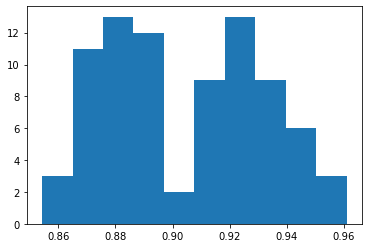

In [48]:
plt.hist(np.array(w_da[:, 16, :, :].std(dim='Time')).flatten())

In [13]:
height.values[16]

78.719154